In [ ]:
# TODO
# 1. Complete make_one_shot_task
# 2. Complete test one shot task
# 3. Complete plotting
# 4. See if using attention with some static probabilities help the detection of spoofing
# 5. Look at triple loss and computing it
# 6. CNN and attention to top of the book - https://towardsdatascience.com/self-attention-in-computer-vision-2782727021f6
    #Propose probabilities learnt through an LSTM network 
# 7. Higher prediction probabilities for top of book
    #https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
# 8. Fuck with data to get the desired result -b rebuild project
# 9. Clean up code, make fancy plots, write comments and so on
# 10. See if using LSTM to learn probabilities for attention would work 
# 11. Learn Families of classes for spoofing 
# 12. Custom loss function for family of identifications

In [5]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)

import config
import spoof_ground_truth
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from imageio import imread
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import time
import numpy.random as rng
import tensorflow as tf
import tensorflow_addons as tfa

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D,Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

from tensorflow_addons.losses import triplet_semihard_loss


### Data Loading and Cleansing

In [7]:
abeo_train_pos = np.load(project_path + '/data/train/20160901_Positive/ABEO_BATS.npy')
abeo_train_neg = np.load(project_path + '/data/train/20160901_Negative/ABEO_BATS.npy')

abeo_val_pos = np.load(project_path + '/data/train/20160901_Positive/ABEO_NASDAQ.npy')
abeo_val_neg = np.load(project_path + '/data/train/20160901_Negative/ABEO_NASDAQ.npy')

goog_train_pos = np.load(project_path + '/data/train/20160901_Positive/GOOG_BATS.npy')
goog_train_neg = np.load(project_path + '/data/train/20160901_Negative/GOOG_BATS.npy')

goog_val_pos = np.load(project_path + '/data/train/20160901_Positive/GOOG_NASDAQ.npy')
goog_val_neg = np.load(project_path + '/data/train/20160901_Negative/GOOG_NASDAQ.npy')

model_path = project_path + '/weights/spoof'

In [8]:
def retrieve_cleansed_data(pos_raw, neg_raw, side):
        # Retrieve data where the last update was on the side required since otherwise we will be duplicating 
        pos_side = [i for i, s in enumerate(pos_raw['side'][:]) if s == side]
        neg_side = [i for i, s in enumerate(neg_raw['side'][:]) if s == side]
        
        df_pos = pos_raw[pos_side]
        df_neg = neg_raw[neg_side]
        
        p_mask_large_tops = (df_pos['quantity'][:,0,0,0:15]>1000).any(1)
        n_mask_small_tops = (df_neg['quantity'][:,0,0,0:15] < 1500).all(1)
        n_mask_large_bottoms = (df_pos['quantity'][:,0,0,0:15] < 2500).all(1) & \
                               (df_pos['quantity'][:,0,0,20:29] > 1000).any(1)
        
        df_pos_data = df_pos[p_mask_large_tops]
        df_neg_small = df_neg[n_mask_small_tops]
        df_neg_large = df_pos[n_mask_large_bottoms]
        df_neg = np.append(df_neg_small['quantity'], df_neg_large['quantity'], axis=0) 
        
        return df_pos_data['quantity'], df_neg
    
pos_train, neg_train = retrieve_cleansed_data(goog_train_pos, goog_train_neg, 'B')    
pos_val, neg_val = retrieve_cleansed_data(goog_val_pos, goog_val_neg, 'B') 

### Model Initialisation

In [13]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

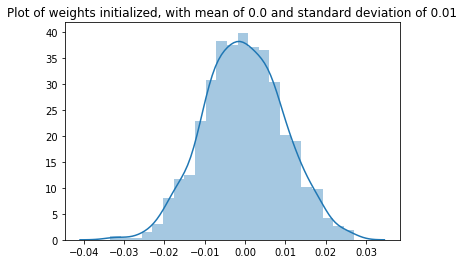

In [14]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

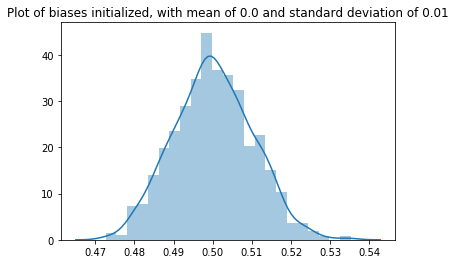

In [15]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [19]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
                     use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', strides=1, padding="same", input_shape=input_shape,
                     use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    # model.add(MaxPooling2D())
    #model.add(Conv2D(128,kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
     #                use_bias = True, kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='random_uniform',bias_initializer=initialize_bias))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

     # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net
    
model = get_siamese_model((2, 30, 1))
model.summary()
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         3954816     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

In [311]:
class TripletNet(Model):
    def __init__(self, shape=(2, 30, 1), dimensions=60):
        super(TripletNet, self).__init__()
        self.model = self.build_triplets_model(shape, dimensions)
        self.model.compile(
            #loss=tfa.losses.TripletSemiHardLoss(),
            loss = triplet_loss,
            optimizer=tfa.optimizers.RectifiedAdam(0.001)
           # metrics=['accuracy']
            #tfa.metrics.MultiLabelConfusionMatrix(num_classes=2)
        )
        self.fit = self.model.fit
        self.fit_generator = self.model.fit_generator
        self.predict = self.model.predict
        self.evaluate = self.model.evaluate
        self.summary = self.model.summary
        
        
    def build_triplets_model(self, shape, dimensions):
        net = self.build_embedding(shape, dimensions)
     
        anchor_input = Input(shape=shape, name='anchor')
        positive_input = Input(shape=shape, name='positive')
        negative_input = Input(shape=shape, name='negative')

        # Get the embedded values
        encoded_a = net(anchor_input)
        encoded_p = net(positive_input)
        encoded_n = net(negative_input)
        
        # Get the differences
      #  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
      #  d1 = L1_layer([encoded_a, encoded_p])
      #  d2 = L1_layer([encoded_a, encoded_n])

        # Normalize the differences
       # L2_layer = Lambda(lambda tensors:tf.norm(tensors))
       # n1 = L2_layer(d1)
       # n2 = L2_layer(d2)

        # Compare
        #out = Activation('sigmoid')(tf.subtract(n2, n1))
        # Add a dense layer with a sigmoid unit to generate the similarity score
           # Add a customized layer to compute the absolute difference between the encodings
        
      #  L1_distance = L1_layer([n2, n1])
        
       # prediction = Dense(1,bias_initializer='zeros')(d1)
        merged = concatenate([encoded_a, encoded_p, encoded_n], axis=-1, name='tripleLossLayer')
        output = Dense(180)(merged)
        triplet_net = Model(inputs=[anchor_input, positive_input, negative_input],\
                            outputs=[output])
        return triplet_net

    def build_embedding(self, input_shape, dimensions):
        inp = Input(shape=input_shape)
     
        out = Conv2D(32, kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(inp)
        out = MaxPooling2D()(out)
        out = Conv2D(64, kernel_size=(3,3), activation='relu', strides=1, padding="same",
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
        out = Flatten()(out)
        out = Dense(dimensions, kernel_regularizer=l2(1e-3), kernel_initializer='random_uniform',
                        bias_initializer=initialize_bias)(out)
        
        L1_layer = Lambda(lambda tensors:tf.math.l2_normalize(tensors, axis=1))
        out = L1_layer(out)
        
        return Model(inputs=inp, outputs=out)

triplet_model = TripletNet(shape=(2, 30, 1), dimensions=60)
triplet_model.summary()
triplet_model.model.metrics_names

Tensor("loss_45/dense_76_loss/triplet_loss/Sum:0", shape=(), dtype=float32)
Tensor("loss_45/dense_76_loss/triplet_loss/Max:0", shape=(), dtype=float32)
Model: "model_112"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
model_111 (Model)               (None

['loss']

### Training Triplet Net

In [398]:
def get_triplet_batch(batch_size, positive_samples, negative_samples, anchor):
    n_examples_p, d, w, h = positive_samples.shape
    n_examples_n = negative_samples.shape[0]
    triplets = [np.zeros((batch_size, w, h, 1)) for i in range(3)]
    
    # initialize vector for the targets
    targets = np.ones((batch_size,2))
    targets[:,1] = 0
    
    for i in range(batch_size):
        idx_p = rng.randint(0, n_examples_p)
        idx_n = rng.randint(0, n_examples_n)
        triplets[0][i,:,:,:] = anchor.reshape(w, h, 1)
        triplets[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
        triplets[2][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
    return [triplets[0], triplets[1], triplets[2]], targets

def triplet_generator(batch_size, train_data, test_data, anchor):
    while True:
        inputs, targets = get_triplet_batch(batch_size, pos_train, neg_train, anchor)
        yield [inputs, targets], None

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    print(pos_dist)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
  #  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    hardest_positive_dist = tf.reduce_max(tf.square(tf.subtract(anchor, positive)), axis=-1)
    print(hardest_positive_dist)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))
    
    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(tf.subtract(anchor, negative), axis=-1)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))
    
     # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + alpha, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    # Step 3: subtract the two previous distances and add alpha.
   # basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(triplet_loss, 0))
    ### END CODE HERE ###
    
    return loss

In [399]:
def triplet_loss1(y_true, y_pred, alpha=0.4):
    print("for distance branch, y_pred.shape:  ", y_pred)       # [Batch_dim, vec_dim*3]

    vec_len = y_pred.shape.as_list()[-1]

    anchor = y_pred[:, :int(vec_len/3)]
    positve = y_pred[:, int(vec_len/3):int(vec_len*2/3)]
    negative = y_pred[:, int(vec_len*2/3):]

    pos_dist = K.sum(K.square(anchor - positve), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    loss = K.maximum(0., pos_dist - neg_dist + alpha)

    return loss
a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    y_true = (None, None, None)
    a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)
    print(a)
    p = tf.compat.v1.random_normal([5, 60], mean=1, stddev=1, seed = 1)
    n = tf.compat.v1.random_normal([5, 60], mean=3, stddev=4, seed = 1)
    merged = concatenate([a, p, n], axis=-1)
    y_pred = (tf.compat.v1.random_normal([3, 60], mean=6, stddev=0.1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=1, stddev=1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1), 
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1))
    loss = triplet_loss1(y_true, merged)
    
    print("loss = " + str(loss.eval()))


Tensor("random_normal_352:0", shape=(5, 60), dtype=float32)
for distance branch, y_pred.shape:   Tensor("concatenate_33/concat:0", shape=(5, 180), dtype=float32)
loss = [290.07104 161.85742   0.        0.      152.97095]


In [400]:
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [401]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)

  
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------
0.25678894
0.26142317
0.26491317
0.24955595
0.25389108
0.25461754
0.2594513
0.28797406
0.2487621
0.2519029

 ------------- 

Time for 10 iterations: 0.00322723388671875 mins
Train Loss: 0.25190290808677673
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 0.0% 20 way one-shot learning accuracy 

Current best: 0.0, previous best: -1
0.25978944
0.25397995
0.26558772
0.25741553
0.25765023
0.25558805
0.26162177
0.24968973
0.25585136
0.2471016

 ------------- 

Time for 20 iterations: 0.027243399620056154 mins
Train Loss: 0.24710160493850708
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 0.0% 20 way one-shot learning accuracy 

Current best: 0.0, previous best: 0.0
0.24802911
0.2556439
0.27399987
0.25708437
0.25462848
0.2640526
0.26670802
0.26530692
0.24975201
0.24861415

 ------------- 

Time for 30 iterations: 0.04733421802520752 mins
Train Loss: 0.24

KeyboardInterrupt: 

In [327]:
import tensorflow as tf
import numpy as np

data = [[1,2,3],[4,5,6]]
data_np = np.asarray(data, np.float32)

data_tf = tf.convert_to_tensor(data_np, np.float32)

data_np.shape

(2, 3)

In [272]:
train_generator = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
val_generator = triplet_generator(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)

model.fit(generator=train_generator, steps_per_epoch=20, epochs=100,
                        validation_data=val_generator,
                        validation_steps=10,
                        verbose=1) #callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


ValueError: Please provide model inputs as a list or tuple of 2 or 3 elements: (input, target) or (input, target, sample_weights) Received ((<tf.Tensor: shape=(32, 2, 30, 1), dtype=float64, numpy=
array([[[[9.0e+01],
         [1.0e+04],
         [1.0e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]],

        [[7.0e+00],
         [9.7e+02],
         [1.5e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]]],


       [[[9.0e+01],
         [1.0e+04],
         [1.0e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]],

        [[7.0e+00],
         [9.7e+02],
         [1.5e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]]],


       [[[9.0e+01],
         [1.0e+04],
         [1.0e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]],

        [[7.0e+00],
         [9.7e+02],
         [1.5e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]]],


       ...,


       [[[9.0e+01],
         [1.0e+04],
         [1.0e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]],

        [[7.0e+00],
         [9.7e+02],
         [1.5e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]]],


       [[[9.0e+01],
         [1.0e+04],
         [1.0e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]],

        [[7.0e+00],
         [9.7e+02],
         [1.5e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]]],


       [[[9.0e+01],
         [1.0e+04],
         [1.0e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]],

        [[7.0e+00],
         [9.7e+02],
         [1.5e+01],
         ...,
         [0.0e+00],
         [0.0e+00],
         [0.0e+00]]]])>, <tf.Tensor: shape=(32, 2, 30, 1), dtype=float64, numpy=
array([[[[3.7625e+04],
         [5.8610e+05],
         [3.3610e+05],
         ...,
         [5.0850e+05],
         [7.7970e+05],
         [1.0506e+06]],

        [[2.6000e+01],
         [1.0000e+02],
         [2.0000e+02],
         ...,
         [1.0000e+02],
         [1.0000e+02],
         [1.0000e+02]]],


       [[[3.9070e+03],
         [1.1570e+06],
         [2.3620e+05],
         ...,
         [8.6210e+05],
         [6.4957e+06],
         [4.3970e+05]],

        [[2.0000e+02],
         [1.0000e+02],
         [1.0000e+02],
         ...,
         [1.0000e+02],
         [1.0000e+02],
         [1.0000e+02]]],


       [[[7.9430e+03],
         [8.7960e+05],
         [3.1110e+05],
         ...,
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00]],

        [[1.0000e+02],
         [2.0000e+02],
         [1.9000e+01],
         ...,
         [1.0000e+02],
         [1.0000e+02],
         [1.0000e+02]]],


       ...,


       [[[2.9694e+05],
         [9.0690e+03],
         [1.0430e+04],
         ...,
         [7.6940e+05],
         [4.0330e+05],
         [5.9610e+05]],

        [[1.0000e+02],
         [1.0000e+02],
         [2.0000e+02],
         ...,
         [1.0000e+02],
         [1.0000e+02],
         [1.0000e+02]]],


       [[[1.4920e+03],
         [7.4200e+05],
         [3.2820e+05],
         ...,
         [1.9982e+04],
         [7.0250e+05],
         [5.6190e+05]],

        [[1.0000e+02],
         [1.0000e+01],
         [2.0000e+02],
         ...,
         [1.0000e+02],
         [1.0000e+02],
         [2.0000e+00]]],


       [[[2.2960e+03],
         [9.3480e+03],
         [4.9090e+03],
         ...,
         [7.0250e+05],
         [5.6190e+05],
         [2.4870e+05]],

        [[1.0000e+02],
         [1.0000e+02],
         [1.0000e+02],
         ...,
         [1.0000e+02],
         [1.0000e+02],
         [1.0000e+02]]]])>, <tf.Tensor: shape=(32, 2, 30, 1), dtype=float64, numpy=
array([[[[8.200e+01],
         [2.360e+02],
         [9.810e+02],
         ...,
         [1.119e+03],
         [3.800e+02],
         [3.280e+02]],

        [[1.000e+02],
         [1.000e+02],
         [1.000e+02],
         ...,
         [1.000e+02],
         [1.000e+02],
         [1.000e+02]]],


       [[[1.760e+02],
         [1.136e+03],
         [5.270e+02],
         ...,
         [0.000e+00],
         [0.000e+00],
         [0.000e+00]],

        [[1.000e+02],
         [1.000e+02],
         [1.000e+02],
         ...,
         [1.000e+02],
         [1.000e+02],
         [1.000e+02]]],


       [[[3.560e+02],
         [9.780e+02],
         [5.100e+02],
         ...,
         [6.150e+02],
         [4.150e+02],
         [1.078e+03]],

        [[1.000e+02],
         [1.000e+02],
         [1.000e+02],
         ...,
         [1.000e+02],
         [1.000e+02],
         [1.000e+02]]],


       ...,


       [[[8.050e+02],
         [1.484e+03],
         [1.176e+03],
         ...,
         [9.890e+02],
         [1.011e+03],
         [9.130e+02]],

        [[1.000e+02],
         [1.000e+02],
         [1.000e+02],
         ...,
         [1.000e+02],
         [1.000e+02],
         [1.000e+02]]],


       [[[6.100e+01],
         [1.002e+03],
         [6.800e+02],
         ...,
         [6.150e+02],
         [4.150e+02],
         [1.078e+03]],

        [[2.000e+02],
         [5.000e+01],
         [1.000e+01],
         ...,
         [1.000e+02],
         [1.000e+02],
         [1.000e+02]]],


       [[[1.094e+03],
         [1.256e+03],
         [1.161e+03],
         ...,
         [1.452e+03],
         [6.150e+02],
         [9.330e+02]],

        [[1.000e+00],
         [1.000e+02],
         [1.000e+02],
         ...,
         [1.000e+02],
         [1.000e+02],
         [1.000e+02]]]])>), <tf.Tensor: shape=(32, 3), dtype=float64, numpy=
array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.]])>)

In [216]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
      #  val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
       # if val_acc >= best:
        #    print("Current best: {0}, previous best: {1}".format(val_acc, best))
         #   best = val_acc

Starting training process!
-------------------------------------
[1.292777, 0.2, 0.76052946, 0.28448996]
[0.91208804, 0.2, 0.35548675, 0.30884406]
[1.0889847, 0.2, 0.49864873, 0.34257892]
[1.0894365, 0.2, 0.51800793, 0.32367185]
[0.9980485, 0.2, 0.46863583, 0.28165603]
[1.007574, 0.2, 0.51967084, 0.24014668]
[1.2048166, 0.2, 0.6302284, 0.32684714]
[1.0634065, 0.2, 0.5271299, 0.28855067]
[1.2564203, 0.2, 0.32316518, 0.68554676]
[0.8869104, 0.2, 0.34534407, 0.29387838]

 ------------- 

Time for 10 iterations: 0.054940231641133624 mins
Train Loss: [0.8869104, 0.2, 0.34534407, 0.29387838]
[0.97349346, 0.2, 0.39905876, 0.32676992]
[1.23887, 0.2, 0.7331495, 0.25808102]
[1.0832039, 0.2, 0.39756158, 0.43802994]
[1.0466359, 0.2, 0.52938354, 0.26966965]
[0.8787669, 0.2, 0.3762797, 0.2549361]
[0.80763364, 0.2, 0.29604995, 0.2640664]
[0.832484, 0.2, 0.2966424, 0.28836006]
[1.1554942, 0.2, 0.43964, 0.46841034]
[0.8073968, 0.2, 0.31956008, 0.24043189]
[1.0688647, 0.2, 0.55870295, 0.26279783]

 ----

[0.67347395, 0.2, 0.22632739, 0.20951179]
[0.68037933, 0.2, 0.22497106, 0.21783069]
[0.6920162, 0.2, 0.23904033, 0.21545546]
[0.6707344, 0.2, 0.21939407, 0.21387674]
[0.6660047, 0.2, 0.21521159, 0.2133862]
[0.7496261, 0.2, 0.2175811, 0.29469457]

 ------------- 

Time for 170 iterations: 0.1326890985171 mins
Train Loss: [0.7496261, 0.2, 0.2175811, 0.29469457]
[0.6872586, 0.2, 0.24037504, 0.20958881]
[0.67462486, 0.2, 0.22878648, 0.2085992]
[0.683156, 0.2, 0.23518766, 0.21078429]
[0.67316514, 0.2, 0.22284289, 0.21319354]
[0.660046, 0.2, 0.20816018, 0.21481204]
[0.6888587, 0.2, 0.24013665, 0.21170315]
[0.67550236, 0.2, 0.23175265, 0.2067852]
[0.67248285, 0.2, 0.22814265, 0.20742995]
[0.6579684, 0.2, 0.20912951, 0.21198273]
[0.65598, 0.2, 0.21032085, 0.2088572]

 ------------- 

Time for 180 iterations: 0.1359485348065694 mins
Train Loss: [0.65598, 0.2, 0.21032085, 0.2088572]
[0.68075186, 0.2, 0.229491, 0.214513]
[0.6634684, 0.2, 0.21403924, 0.21273518]
[0.6726183, 0.2, 0.2294075, 0.20657

[0.66612524, 0.2, 0.22920041, 0.20575172]
[0.6605266, 0.2, 0.218644, 0.21074033]
[0.6490301, 0.2, 0.21102698, 0.20689145]
[0.6441749, 0.2, 0.20731227, 0.20578162]
[0.65372235, 0.2, 0.21704052, 0.20563148]
[0.66076607, 0.2, 0.2256972, 0.20404884]
[0.64069355, 0.2, 0.20610307, 0.20360008]
[0.6489851, 0.2, 0.21545988, 0.20256452]
[0.65865606, 0.2, 0.22315523, 0.20457022]

 ------------- 

Time for 330 iterations: 0.1792203664779663 mins
Train Loss: [0.65865606, 0.2, 0.22315523, 0.20457022]
[0.6512725, 0.2, 0.21760201, 0.20276958]
[0.6446004, 0.2, 0.21129878, 0.20243046]
[0.63807607, 0.2, 0.20420595, 0.20302896]
[0.6539358, 0.2, 0.21445692, 0.20866795]
[0.66259146, 0.2, 0.22610104, 0.2057097]
[0.66296226, 0.2, 0.22633989, 0.20587173]
[0.64891034, 0.2, 0.21184587, 0.2063439]
[0.6397767, 0.2, 0.204196, 0.20489044]
[0.64379615, 0.2, 0.2114341, 0.20170219]
[0.6474191, 0.2, 0.21042238, 0.20636694]

 ------------- 

Time for 340 iterations: 0.18169318437576293 mins
Train Loss: [0.6474191, 0.2, 0

[0.64154315, 0.2, 0.21052256, 0.20404798]
[0.63456756, 0.2, 0.20287585, 0.20474173]
[0.634871, 0.2, 0.20506571, 0.2028779]
[0.6410287, 0.2, 0.21221676, 0.20190755]
[0.6315559, 0.2, 0.2030358, 0.20163898]
[0.6457309, 0.2, 0.21587482, 0.20299827]
[0.64930713, 0.2, 0.20377435, 0.2186982]

 ------------- 

Time for 490 iterations: 0.22984215021133422 mins
Train Loss: [0.64930713, 0.2, 0.20377435, 0.2186982]
[0.64167166, 0.2, 0.20623302, 0.2086273]
[0.6367811, 0.2, 0.20268135, 0.20731127]
[0.6478152, 0.2, 0.2162887, 0.20476109]
[0.65216446, 0.2, 0.22298238, 0.20243932]
[0.642221, 0.2, 0.21212901, 0.2033716]
[0.64388263, 0.2, 0.21443856, 0.20274583]
[0.64686435, 0.2, 0.21507606, 0.20511188]
[0.6428902, 0.2, 0.21467504, 0.20156066]
[0.6393032, 0.2, 0.20822072, 0.20445004]
[0.63053304, 0.2, 0.20147708, 0.20244585]

 ------------- 

Time for 500 iterations: 0.23336573441823324 mins
Train Loss: [0.63053304, 0.2, 0.20147708, 0.20244585]
[0.63845277, 0.2, 0.208793, 0.2030724]
[0.63127846, 0.2, 0.2

[0.64371026, 0.2, 0.21533555, 0.20455135]

 ------------- 

Time for 640 iterations: 0.2847805460294088 mins
Train Loss: [0.64371026, 0.2, 0.21533555, 0.20455135]
[0.6304865, 0.2, 0.20650625, 0.20017438]
[0.65156174, 0.2, 0.2201939, 0.20757972]
[0.6490005, 0.2, 0.21504606, 0.21018425]
[0.63574785, 0.2, 0.21049869, 0.2014966]
[0.65805894, 0.2, 0.22826476, 0.20605914]
[0.6355591, 0.2, 0.20910312, 0.20273808]
[0.6482463, 0.2, 0.22222093, 0.20232445]
[0.6365824, 0.2, 0.21095932, 0.20193915]
[0.6300658, 0.2, 0.20603056, 0.20036842]
[0.63786364, 0.2, 0.21234468, 0.2018695]

 ------------- 

Time for 650 iterations: 0.2874864339828491 mins
Train Loss: [0.63786364, 0.2, 0.21234468, 0.2018695]
[0.6306251, 0.2, 0.2012057, 0.20578775]
[0.63675046, 0.2, 0.21093078, 0.20220582]
[0.6303856, 0.2, 0.20375973, 0.20303014]
[0.6365608, 0.2, 0.2100776, 0.20290555]
[0.63975906, 0.2, 0.21197812, 0.20422119]
[0.6389843, 0.2, 0.21469483, 0.20074743]
[0.62419474, 0.2, 0.19910544, 0.20156527]
[0.63503057, 0.2, 

[0.6439478, 0.2, 0.2184235, 0.20430958]
[0.64095354, 0.2, 0.21121602, 0.20853804]
[0.64118785, 0.2, 0.2136998, 0.20630394]
[0.6428028, 0.2, 0.21851774, 0.20311606]
[0.62668264, 0.2, 0.20285143, 0.20267734]
[0.6367379, 0.2, 0.21248274, 0.20311648]

 ------------- 

Time for 800 iterations: 0.3250646988550822 mins
Train Loss: [0.6367379, 0.2, 0.21248274, 0.20311648]
[0.6262817, 0.2, 0.20375015, 0.2014084]
[0.63502795, 0.2, 0.21066166, 0.20325893]
[0.6320311, 0.2, 0.20738587, 0.2035536]
[0.6403738, 0.2, 0.21374522, 0.20555286]
[0.65649325, 0.2, 0.23443718, 0.20099588]
[0.63417244, 0.2, 0.20974453, 0.20338449]
[0.6296684, 0.2, 0.20434631, 0.20429514]
[0.62691593, 0.2, 0.20334491, 0.20256026]
[0.6262366, 0.2, 0.20252942, 0.2027125]
[0.65098375, 0.2, 0.226981, 0.20302412]

 ------------- 

Time for 810 iterations: 0.32708326578140257 mins
Train Loss: [0.65098375, 0.2, 0.226981, 0.20302412]
[0.6304683, 0.2, 0.2069645, 0.20254178]
[0.6350126, 0.2, 0.21086136, 0.2032056]
[0.6303199, 0.2, 0.2057

[0.6266286, 0.2, 0.20408508, 0.20356596]
[0.63485706, 0.2, 0.21149199, 0.20440112]
[0.65782434, 0.2, 0.23473203, 0.20414181]
[0.6348045, 0.2, 0.20941772, 0.20644921]

 ------------- 

Time for 960 iterations: 0.3722790320714315 mins
Train Loss: [0.6348045, 0.2, 0.20941772, 0.20644921]
[0.6585184, 0.2, 0.21447688, 0.22511674]
[0.64738166, 0.2, 0.22253226, 0.20593725]
[0.62393004, 0.2, 0.2028537, 0.20217657]
[0.6273235, 0.2, 0.20445974, 0.20397653]
[0.6300175, 0.2, 0.20710213, 0.20404062]
[0.6599506, 0.2, 0.20921935, 0.23186865]
[0.63467103, 0.2, 0.21303885, 0.20278268]
[0.64513373, 0.2, 0.22395043, 0.20234665]
[0.6406206, 0.2, 0.21788657, 0.20390975]
[0.6263615, 0.2, 0.20401642, 0.2035328]

 ------------- 

Time for 970 iterations: 0.3751255830128988 mins
Train Loss: [0.6263615, 0.2, 0.20401642, 0.2035328]
[0.6428429, 0.2, 0.21647075, 0.20757194]
[0.626579, 0.2, 0.20308664, 0.20470329]
[0.6318025, 0.2, 0.21135329, 0.20167133]
[0.63962895, 0.2, 0.21657582, 0.20428646]
[0.6399732, 0.2, 0.

[0.6258728, 0.2, 0.20652595, 0.20219317]
[0.63240135, 0.2, 0.2106733, 0.20458338]
[0.62427926, 0.2, 0.2028099, 0.20433381]
[0.6551752, 0.2, 0.2293895, 0.20865978]
[0.6381166, 0.2, 0.2149257, 0.20607255]

 ------------- 

Time for 1120 iterations: 0.41563348372777303 mins
Train Loss: [0.6381166, 0.2, 0.2149257, 0.20607255]
[0.6321769, 0.2, 0.20889607, 0.20617041]
[0.6276914, 0.2, 0.20749633, 0.20309241]
[0.6244196, 0.2, 0.2027122, 0.20461233]
[0.65376705, 0.2, 0.22758126, 0.20909822]
[0.64252853, 0.2, 0.22298068, 0.20246767]
[0.621437, 0.2, 0.20200785, 0.20235634]
[0.63131213, 0.2, 0.21091838, 0.20332865]
[0.66352254, 0.2, 0.21075852, 0.23570666]
[0.6274737, 0.2, 0.2089268, 0.20149693]
[0.6301822, 0.2, 0.2092183, 0.2039212]

 ------------- 

Time for 1130 iterations: 0.4191747665405273 mins
Train Loss: [0.6301822, 0.2, 0.2092183, 0.2039212]
[0.62490803, 0.2, 0.20612371, 0.20174876]
[0.62093854, 0.2, 0.20245278, 0.2014575]
[0.62736505, 0.2, 0.20777984, 0.20256451]
[0.625073, 0.2, 0.20619

[0.62673753, 0.2, 0.20889929, 0.20214286]
[0.62617993, 0.2, 0.20949867, 0.20099601]
[0.62753505, 0.2, 0.2109171, 0.20094262]
[0.6431785, 0.2, 0.22400613, 0.20350744]
[0.62233156, 0.2, 0.20497485, 0.20170148]
[0.6293278, 0.2, 0.21091036, 0.20277253]

 ------------- 

Time for 1280 iterations: 0.46804479757944745 mins
Train Loss: [0.6293278, 0.2, 0.21091036, 0.20277253]
[0.6240835, 0.2, 0.20577115, 0.2026775]
[0.62594056, 0.2, 0.20694853, 0.20336749]
[0.62062347, 0.2, 0.20403105, 0.20097822]
[0.6275619, 0.2, 0.21134903, 0.2006088]
[0.62264353, 0.2, 0.20518366, 0.20186599]
[0.62531537, 0.2, 0.20713621, 0.20259586]
[0.6361311, 0.2, 0.21738137, 0.20317711]
[0.62786335, 0.2, 0.2093615, 0.20294012]
[0.61975634, 0.2, 0.20216353, 0.20204179]
[0.62833256, 0.2, 0.21083173, 0.2019603]

 ------------- 

Time for 1290 iterations: 0.47093343337376914 mins
Train Loss: [0.62833256, 0.2, 0.21083173, 0.2019603]
[0.6221047, 0.2, 0.20499216, 0.20158237]
[0.6227642, 0.2, 0.20620872, 0.2010359]
[0.6236044, 0

[0.62126654, 0.2, 0.20512292, 0.20182836]
[0.622988, 0.2, 0.20731355, 0.20136818]
[0.62496716, 0.2, 0.20915297, 0.20151678]
[0.6435101, 0.2, 0.22660366, 0.20261802]
[0.64223033, 0.2, 0.2245409, 0.20340973]
[0.62960756, 0.2, 0.21194208, 0.20339453]
[0.6276525, 0.2, 0.2085691, 0.20482096]
[0.6255532, 0.2, 0.21048884, 0.20081028]
[0.6240859, 0.2, 0.20761113, 0.20222926]
[0.6207053, 0.2, 0.2040602, 0.20240827]

 ------------- 

Time for 1440 iterations: 0.5177619496981303 mins
Train Loss: [0.6207053, 0.2, 0.2040602, 0.20240827]
[0.62388295, 0.2, 0.2067371, 0.20291807]
[0.6231865, 0.2, 0.20700866, 0.20195927]
[0.624244, 0.2, 0.20663117, 0.20340346]
[0.6247846, 0.2, 0.2077608, 0.20282373]
[0.6189882, 0.2, 0.20228904, 0.20250818]
[0.63157624, 0.2, 0.21408816, 0.20330644]
[0.6246296, 0.2, 0.20771126, 0.2027459]
[0.62157637, 0.2, 0.20608471, 0.20132798]
[0.6154174, 0.2, 0.20037334, 0.2008888]
[0.6234311, 0.2, 0.20756383, 0.20172021]

 ------------- 

Time for 1450 iterations: 0.5205224831899007

[0.63044226, 0.2, 0.21490638, 0.20231973]
[0.61814225, 0.2, 0.20147066, 0.2034606]
[0.6209691, 0.2, 0.20582919, 0.20193468]
[0.6224326, 0.2, 0.2072775, 0.20195608]
[0.62284505, 0.2, 0.20682333, 0.20282915]
[0.62417674, 0.2, 0.20548223, 0.20550877]
[0.6219089, 0.2, 0.20568563, 0.20304447]
[0.61810744, 0.2, 0.20229045, 0.20264511]

 ------------- 

Time for 1600 iterations: 0.562298850218455 mins
Train Loss: [0.61810744, 0.2, 0.20229045, 0.20264511]
[0.6195792, 0.2, 0.2046464, 0.20176822]
[0.6241559, 0.2, 0.20528807, 0.20571081]
[0.6182254, 0.2, 0.20181912, 0.2032577]
[0.6245357, 0.2, 0.20939043, 0.20200554]
[0.62952274, 0.2, 0.2117144, 0.20467733]
[0.62405443, 0.2, 0.20838177, 0.20255005]
[0.6194567, 0.2, 0.20421566, 0.20212685]
[0.62800354, 0.2, 0.21310227, 0.20179537]
[0.6236091, 0.2, 0.20301905, 0.20749266]
[0.652728, 0.2, 0.23729524, 0.20234394]

 ------------- 

Time for 1610 iterations: 0.5646645665168762 mins
Train Loss: [0.652728, 0.2, 0.23729524, 0.20234394]
[0.6361425, 0.2, 0.

[0.6207254, 0.2, 0.20194702, 0.20649064]
[0.6203406, 0.2, 0.20562008, 0.20244016]
[0.62884736, 0.2, 0.21400288, 0.20257148]
[0.6236574, 0.2, 0.2080038, 0.20338807]
[0.6188941, 0.2, 0.20323531, 0.20340036]
[0.63140535, 0.2, 0.21717505, 0.20197906]
[0.62700295, 0.2, 0.20947216, 0.2052866]
[0.6220958, 0.2, 0.20463528, 0.20522343]
[0.6225055, 0.2, 0.20819189, 0.20208344]
[0.62294203, 0.2, 0.20832767, 0.20239139]

 ------------- 

Time for 1760 iterations: 0.6102170666058858 mins
Train Loss: [0.62294203, 0.2, 0.20832767, 0.20239139]
[0.62264967, 0.2, 0.20853747, 0.20189694]
[0.6190884, 0.2, 0.20565557, 0.20122497]
[0.62186533, 0.2, 0.20181096, 0.20785372]
[0.61964923, 0.2, 0.20621781, 0.20123813]
[0.6272955, 0.2, 0.21432056, 0.20078838]
[0.6189802, 0.2, 0.2057707, 0.20103021]
[0.6172868, 0.2, 0.20208979, 0.20302483]
[0.6254023, 0.2, 0.21244249, 0.20079502]
[0.6241115, 0.2, 0.21111022, 0.20084356]
[0.6188257, 0.2, 0.20559728, 0.20107755]

 ------------- 

Time for 1770 iterations: 0.61563608

[0.618936, 0.2, 0.20660634, 0.20094174]
[0.62107277, 0.2, 0.20846072, 0.20122758]
[0.6179864, 0.2, 0.20415957, 0.20244603]

 ------------- 

Time for 1920 iterations: 0.6573917349179585 mins
Train Loss: [0.6179864, 0.2, 0.20415957, 0.20244603]
[0.6216832, 0.2, 0.2075993, 0.20270692]
[0.6190041, 0.2, 0.20552832, 0.20210284]
[0.61921173, 0.2, 0.20782137, 0.20002183]
[0.61530185, 0.2, 0.20211303, 0.20182487]
[0.65689385, 0.2, 0.21133098, 0.23420352]
[0.6158503, 0.2, 0.2035395, 0.20095588]
[0.6276118, 0.2, 0.2139376, 0.20232354]
[0.62069726, 0.2, 0.20666672, 0.20268412]
[0.62131304, 0.2, 0.20940952, 0.20056169]
[0.6251983, 0.2, 0.21050596, 0.2033553]

 ------------- 

Time for 1930 iterations: 0.6611026326815287 mins
Train Loss: [0.6251983, 0.2, 0.21050596, 0.2033553]
[0.6230993, 0.2, 0.21061663, 0.20115042]
[0.62094355, 0.2, 0.2070919, 0.20252451]
[0.6280016, 0.2, 0.21371366, 0.20296578]
[0.6234959, 0.2, 0.20879577, 0.20338315]
[0.62888676, 0.2, 0.21355116, 0.20402388]
[0.6182497, 0.2, 0.

[0.61550426, 0.2, 0.20246978, 0.20229594]
[0.61966914, 0.2, 0.208103, 0.20083384]
[0.63131577, 0.2, 0.21922879, 0.20136102]
[0.62812567, 0.2, 0.21577786, 0.20162824]
[0.61498976, 0.2, 0.20253439, 0.20174193]
[0.6204353, 0.2, 0.20429851, 0.20542979]
[0.61874247, 0.2, 0.20652702, 0.20151477]
[0.6198289, 0.2, 0.20661615, 0.20251836]
[0.6144528, 0.2, 0.20247857, 0.2012854]

 ------------- 

Time for 2080 iterations: 0.702396563688914 mins
Train Loss: [0.6144528, 0.2, 0.20247857, 0.2012854]
[0.620924, 0.2, 0.20880131, 0.20143959]
[0.6173267, 0.2, 0.204961, 0.20168823]
[0.6148007, 0.2, 0.20255624, 0.20157266]
[0.6190258, 0.2, 0.20691028, 0.2014495]
[0.6173961, 0.2, 0.2029338, 0.20380227]
[0.61888266, 0.2, 0.20455915, 0.2036696]
[0.63201463, 0.2, 0.22093388, 0.20043322]
[0.61540127, 0.2, 0.20252052, 0.2022401]
[0.6249395, 0.2, 0.21288759, 0.20141791]
[0.6157002, 0.2, 0.20287788, 0.20219375]

 ------------- 

Time for 2090 iterations: 0.7074198365211487 mins
Train Loss: [0.6157002, 0.2, 0.2028

[0.6128509, 0.2, 0.20217608, 0.20040955]
[0.63303995, 0.2, 0.21857171, 0.20419611]
[0.62910837, 0.2, 0.21707304, 0.2017576]
[0.6174019, 0.2, 0.2026388, 0.20448041]
[0.61221045, 0.2, 0.20079964, 0.20112395]

 ------------- 

Time for 2240 iterations: 0.7552114009857178 mins
Train Loss: [0.61221045, 0.2, 0.20079964, 0.20112395]
[0.65273917, 0.2, 0.24216805, 0.2002811]
[0.62370086, 0.2, 0.20345184, 0.20995656]
[0.6267371, 0.2, 0.21285792, 0.203585]
[0.62651587, 0.2, 0.21077465, 0.2054435]
[0.6147276, 0.2, 0.20302391, 0.2014016]
[0.6282112, 0.2, 0.21322414, 0.20468093]
[0.6648844, 0.2, 0.20323333, 0.25134104]
[0.6298781, 0.2, 0.21749261, 0.20207162]
[0.6282283, 0.2, 0.21455885, 0.20335163]
[0.63913417, 0.2, 0.22833519, 0.20047735]

 ------------- 

Time for 2250 iterations: 0.7583551327387492 mins
Train Loss: [0.63913417, 0.2, 0.22833519, 0.20047735]
[0.63382447, 0.2, 0.22192544, 0.20157354]
[0.61297613, 0.2, 0.20014925, 0.20249891]
[0.62524986, 0.2, 0.21418618, 0.20073391]
[0.62927085, 0.

[0.6174353, 0.2, 0.20653181, 0.20077762]
[0.6134998, 0.2, 0.20218508, 0.20120123]
[0.65398616, 0.2, 0.20248526, 0.24139972]
[0.6184335, 0.2, 0.206824, 0.20151982]
[0.6234706, 0.2, 0.21058828, 0.20280425]
[0.62865853, 0.2, 0.2173558, 0.20123634]
[0.6180996, 0.2, 0.2065143, 0.20153016]
[0.6135456, 0.2, 0.20133357, 0.20216817]
[0.62543, 0.2, 0.21235226, 0.20304543]
[0.6130586, 0.2, 0.20176597, 0.20127228]

 ------------- 

Time for 2410 iterations: 0.8090789834658305 mins
Train Loss: [0.6130586, 0.2, 0.20176597, 0.20127228]
[0.6194063, 0.2, 0.2082238, 0.20117414]
[0.6227668, 0.2, 0.21061729, 0.20215333]
[0.62373835, 0.2, 0.20904398, 0.20471047]
[0.6268198, 0.2, 0.20986436, 0.20698376]
[0.6256955, 0.2, 0.21365917, 0.20207691]
[0.6156965, 0.2, 0.20448516, 0.20126422]
[0.6137098, 0.2, 0.20156963, 0.20220535]
[0.61426914, 0.2, 0.20356524, 0.20078115]
[0.6277152, 0.2, 0.21628189, 0.20152248]
[0.6272216, 0.2, 0.21531712, 0.20200531]

 ------------- 

Time for 2420 iterations: 0.8118281960487366

[0.6262494, 0.2, 0.21579438, 0.20097765]
[0.61967427, 0.2, 0.20820278, 0.20199727]
[0.62491727, 0.2, 0.21428248, 0.20116372]
[0.6202507, 0.2, 0.20655079, 0.20423204]

 ------------- 

Time for 2560 iterations: 0.8541211326917012 mins
Train Loss: [0.6202507, 0.2, 0.20655079, 0.20423204]
[0.6185002, 0.2, 0.2078677, 0.20116818]
[0.627509, 0.2, 0.21526437, 0.20278387]
[0.6128076, 0.2, 0.20224068, 0.20110978]
[0.61612296, 0.2, 0.20498042, 0.2016894]
[0.6189638, 0.2, 0.20786951, 0.20164563]
[0.6150368, 0.2, 0.2029559, 0.20263709]
[0.6125936, 0.2, 0.2019329, 0.201222]
[0.61494493, 0.2, 0.20414855, 0.20136335]
[0.62504685, 0.2, 0.21512623, 0.20049381]
[0.63883203, 0.2, 0.20543726, 0.22397383]

 ------------- 

Time for 2570 iterations: 0.8567400654157002 mins
Train Loss: [0.63883203, 0.2, 0.20543726, 0.22397383]
[0.6171166, 0.2, 0.2040881, 0.20361246]
[0.6242889, 0.2, 0.21351852, 0.20135865]
[0.61330134, 0.2, 0.20271073, 0.20118256]
[0.6256504, 0.2, 0.21547757, 0.20076847]
[0.6170565, 0.2, 0.2

[0.6132623, 0.2, 0.20306705, 0.20109442]
[0.6251519, 0.2, 0.21570775, 0.20034902]
[0.62503004, 0.2, 0.2150648, 0.20087597]
[0.67122364, 0.2, 0.26159927, 0.20054069]
[0.6169417, 0.2, 0.20758988, 0.20027623]
[0.6169111, 0.2, 0.20716202, 0.2006805]
[0.616069, 0.2, 0.20598708, 0.2010195]
[0.6275901, 0.2, 0.21592611, 0.20260718]
[0.62187964, 0.2, 0.21077268, 0.20205545]

 ------------- 

Time for 2730 iterations: 0.8999837795893352 mins
Train Loss: [0.62187964, 0.2, 0.21077268, 0.20205545]
[0.61917555, 0.2, 0.20872599, 0.20140302]
[0.65869343, 0.2, 0.2483361, 0.20131542]
[0.6145748, 0.2, 0.2031624, 0.20237918]
[0.61997473, 0.2, 0.20919603, 0.20175275]
[0.61514485, 0.2, 0.20407309, 0.20205201]
[0.6197494, 0.2, 0.20973459, 0.2010005]
[0.6239036, 0.2, 0.21220335, 0.20269065]
[0.6238796, 0.2, 0.21380968, 0.2010646]
[0.6423348, 0.2, 0.214774, 0.21855925]
[0.64142036, 0.2, 0.21229935, 0.22012295]

 ------------- 

Time for 2740 iterations: 0.9027657667795818 mins
Train Loss: [0.64142036, 0.2, 0.2

[0.61505616, 0.2, 0.20501027, 0.2011138]
[0.6222042, 0.2, 0.21174131, 0.20153421]
[0.6116747, 0.2, 0.20094933, 0.20180008]

 ------------- 

Time for 2880 iterations: 0.939057715733846 mins
Train Loss: [0.6116747, 0.2, 0.20094933, 0.20180008]
[0.6201744, 0.2, 0.21010937, 0.20114383]
[0.6312463, 0.2, 0.20389715, 0.21843192]
[0.619706, 0.2, 0.20924667, 0.2015432]
[0.6233083, 0.2, 0.21205647, 0.20233671]
[0.6248823, 0.2, 0.21271487, 0.20325287]
[0.61433345, 0.2, 0.20485057, 0.20056841]
[0.6254297, 0.2, 0.2123091, 0.20420644]
[0.6210231, 0.2, 0.20901923, 0.20308983]
[0.63738805, 0.2, 0.22529347, 0.20318049]
[0.6397344, 0.2, 0.2293043, 0.20151561]

 ------------- 

Time for 2890 iterations: 0.9418810486793519 mins
Train Loss: [0.6397344, 0.2, 0.2293043, 0.20151561]
[0.62023836, 0.2, 0.20929801, 0.20202486]
[0.6358799, 0.2, 0.22334513, 0.20361759]
[0.6364859, 0.2, 0.22365105, 0.20391618]
[0.6167758, 0.2, 0.20643035, 0.20142491]
[0.6187976, 0.2, 0.20788273, 0.20199166]
[0.6212746, 0.2, 0.2101

[0.623392, 0.2, 0.21129057, 0.2035303]
[0.6258531, 0.2, 0.21580425, 0.20147981]
[0.6279043, 0.2, 0.21773842, 0.20159894]
[0.61565244, 0.2, 0.204959, 0.20212848]
[0.616644, 0.2, 0.20698103, 0.20110053]
[0.6219978, 0.2, 0.21237332, 0.20106493]
[0.6134298, 0.2, 0.20371845, 0.2011548]
[0.6145679, 0.2, 0.20502684, 0.20098823]
[0.61546206, 0.2, 0.20609567, 0.20081797]
[0.6152189, 0.2, 0.20547146, 0.20120376]

 ------------- 

Time for 3040 iterations: 0.9833221316337586 mins
Train Loss: [0.6152189, 0.2, 0.20547146, 0.20120376]
[0.61715215, 0.2, 0.207741, 0.20087226]
[0.6222662, 0.2, 0.21298364, 0.20074792]
[0.6267088, 0.2, 0.2166967, 0.20148163]
[0.6160022, 0.2, 0.20680915, 0.20066674]
[0.6131643, 0.2, 0.20366953, 0.2009728]
[0.6330825, 0.2, 0.20853059, 0.21603462]
[0.6142729, 0.2, 0.2056004, 0.20015806]
[0.6142716, 0.2, 0.20464839, 0.20111144]
[0.61541516, 0.2, 0.20599069, 0.2009158]
[0.6108493, 0.2, 0.20163994, 0.20070376]

 ------------- 

Time for 3050 iterations: 0.9872758189837137 mins

[0.6188983, 0.2, 0.20898801, 0.20159109]
[0.6651675, 0.2, 0.22286005, 0.23398311]
[0.6184508, 0.2, 0.20889863, 0.20122257]
[0.623067, 0.2, 0.21365832, 0.20107433]

 ------------- 

Time for 3200 iterations: 1.0265620827674866 mins
Train Loss: [0.623067, 0.2, 0.21365832, 0.20107433]
[0.62653905, 0.2, 0.21595664, 0.2022433]
[0.61945146, 0.2, 0.20968977, 0.20141801]
[0.62664914, 0.2, 0.21668072, 0.2016212]
[0.6533445, 0.2, 0.22128233, 0.22371218]
[0.6252663, 0.2, 0.21454483, 0.20237045]
[0.6450626, 0.2, 0.23482534, 0.20188507]
[0.61450505, 0.2, 0.20582286, 0.20032911]
[0.61855227, 0.2, 0.2085324, 0.2016665]
[0.62382495, 0.2, 0.21487948, 0.20059204]
[0.6209589, 0.2, 0.20635143, 0.20625491]

 ------------- 

Time for 3210 iterations: 1.0290189822514852 mins
Train Loss: [0.6209589, 0.2, 0.20635143, 0.20625491]
[0.6157324, 0.2, 0.20557424, 0.2018068]
[0.671187, 0.2, 0.26186767, 0.20096962]
[0.62095505, 0.2, 0.21094213, 0.20166324]
[0.62270427, 0.2, 0.20960012, 0.2047542]
[0.6306992, 0.2, 0.21

[0.62264824, 0.2, 0.21358377, 0.20092662]
[0.62454695, 0.2, 0.21635562, 0.20005682]
[0.6115, 0.2, 0.20199543, 0.2013738]
[0.6129521, 0.2, 0.20466965, 0.20015563]

 ------------- 

Time for 3360 iterations: 1.0687175671259561 mins
Train Loss: [0.6129521, 0.2, 0.20466965, 0.20015563]
[0.6146177, 0.2, 0.20511001, 0.20138502]
[0.62745976, 0.2, 0.21911845, 0.20022245]
[0.6316726, 0.2, 0.22284408, 0.20071349]
[0.66197, 0.2, 0.21689478, 0.23696312]
[0.62452424, 0.2, 0.2137194, 0.20269449]
[0.6103813, 0.2, 0.20141375, 0.20085819]
[0.62079215, 0.2, 0.21184315, 0.20084015]
[0.61730194, 0.2, 0.20859572, 0.2005979]
[0.6145738, 0.2, 0.20665866, 0.19980724]
[0.62157595, 0.2, 0.21252087, 0.20094794]

 ------------- 

Time for 3370 iterations: 1.0705211798350016 mins
Train Loss: [0.62157595, 0.2, 0.21252087, 0.20094794]
[0.6147102, 0.2, 0.20553763, 0.2010658]
[0.6213648, 0.2, 0.21230818, 0.20095073]
[0.6227223, 0.2, 0.2141922, 0.20042543]
[0.6115129, 0.2, 0.20258324, 0.20082644]
[0.6101723, 0.2, 0.200

[0.6133465, 0.2, 0.20481992, 0.20049201]
[0.6169191, 0.2, 0.2083464, 0.20053138]
[0.61149913, 0.2, 0.20283869, 0.20061308]
[0.62053096, 0.2, 0.21147123, 0.20100692]
[0.6590732, 0.2, 0.2181605, 0.2328549]
[0.6160896, 0.2, 0.20745566, 0.20057201]
[0.6209863, 0.2, 0.21191862, 0.20100169]
[0.6136431, 0.2, 0.20514148, 0.20043226]
[0.6104561, 0.2, 0.20192301, 0.20046082]

 ------------- 

Time for 3520 iterations: 1.1131883978843689 mins
Train Loss: [0.6104561, 0.2, 0.20192301, 0.20046082]
[0.61950326, 0.2, 0.21096201, 0.20046712]
[0.61641216, 0.2, 0.20737842, 0.20095776]
[0.61705345, 0.2, 0.20793733, 0.20103863]
[0.6173374, 0.2, 0.20812026, 0.20113924]
[0.62728554, 0.2, 0.21832472, 0.20088317]
[0.6198164, 0.2, 0.21137092, 0.20036939]
[0.6231685, 0.2, 0.21393551, 0.20115979]
[0.6133339, 0.2, 0.20379098, 0.20147264]
[0.6137143, 0.2, 0.20489782, 0.20074973]
[0.61695915, 0.2, 0.20782511, 0.2010718]

 ------------- 

Time for 3530 iterations: 1.116114568710327 mins
Train Loss: [0.61695915, 0.2, 

[0.6127526, 0.2, 0.2036481, 0.2013513]
[0.60989594, 0.2, 0.20176312, 0.20037751]
[0.6115488, 0.2, 0.20288725, 0.20090352]
[0.62061805, 0.2, 0.21270029, 0.20015606]
[0.6087569, 0.2, 0.20020086, 0.2007897]
[0.6110484, 0.2, 0.20059095, 0.20268385]
[0.61068374, 0.2, 0.20133688, 0.20156556]
[0.612545, 0.2, 0.20302638, 0.20172572]
[0.61343294, 0.2, 0.20350988, 0.20211302]

 ------------- 

Time for 3680 iterations: 1.1601399858792623 mins
Train Loss: [0.61343294, 0.2, 0.20350988, 0.20211302]
[0.6312395, 0.2, 0.22181357, 0.20159192]
[0.61256546, 0.2, 0.20422617, 0.2004791]
[0.6238431, 0.2, 0.2150964, 0.2008584]
[0.6095049, 0.2, 0.20183398, 0.19975069]
[0.61546344, 0.2, 0.20674478, 0.20077169]
[0.6113927, 0.2, 0.20192681, 0.2014966]
[0.60905594, 0.2, 0.20022073, 0.20083646]
[0.60988784, 0.2, 0.20105107, 0.20080401]
[0.61393255, 0.2, 0.20445926, 0.20140715]
[0.61305076, 0.2, 0.20131843, 0.20362468]

 ------------- 

Time for 3690 iterations: 1.164134669303894 mins
Train Loss: [0.61305076, 0.2, 

[0.63704664, 0.2, 0.22492161, 0.20446236]
[0.6338263, 0.2, 0.22529046, 0.20087668]
[0.6462543, 0.2, 0.23549484, 0.20310344]
[0.63774383, 0.2, 0.22843586, 0.20165394]
[0.61431676, 0.2, 0.2050715, 0.20159313]
[0.6168033, 0.2, 0.20648824, 0.20266455]
[0.61653775, 0.2, 0.20742261, 0.20146601]
[0.60847294, 0.2, 0.199862, 0.20096299]
[0.6251786, 0.2, 0.21242246, 0.2051093]
[0.6338246, 0.2, 0.22351994, 0.20265916]

 ------------- 

Time for 3840 iterations: 1.2065545837084453 mins
Train Loss: [0.6338246, 0.2, 0.22351994, 0.20265916]
[0.62564486, 0.2, 0.21745162, 0.2005484]
[0.61834294, 0.2, 0.20692348, 0.20377529]
[0.61850274, 0.2, 0.20890725, 0.20195155]
[0.62431633, 0.2, 0.21269996, 0.20397156]
[0.6166705, 0.2, 0.20701179, 0.20201276]
[0.62225425, 0.2, 0.21235998, 0.20224719]
[0.6132401, 0.2, 0.20451039, 0.20108141]
[0.61056226, 0.2, 0.20150876, 0.20140414]
[0.6179708, 0.2, 0.20685004, 0.20347068]
[0.6344283, 0.2, 0.22347407, 0.20330344]

 ------------- 

Time for 3850 iterations: 1.2103357

[0.6375641, 0.2, 0.21109363, 0.21900399]
[0.6175653, 0.2, 0.20781454, 0.20228283]
[0.61744815, 0.2, 0.20884547, 0.20113175]

 ------------- 

Time for 3990 iterations: 1.2450690984725952 mins
Train Loss: [0.61744815, 0.2, 0.20884547, 0.20113175]
[0.6199331, 0.2, 0.21107328, 0.20138484]
[0.62017643, 0.2, 0.21260847, 0.20009243]
[0.61302525, 0.2, 0.20539813, 0.20014966]
[0.61055446, 0.2, 0.20201345, 0.2010608]
[0.6115573, 0.2, 0.20398119, 0.20009267]
[0.61026984, 0.2, 0.2016817, 0.20110172]
[0.6117871, 0.2, 0.20392866, 0.20036939]
[0.6283533, 0.2, 0.21884876, 0.20201321]
[0.62315077, 0.2, 0.21347238, 0.20218472]
[0.6105787, 0.2, 0.20146574, 0.2016176]

 ------------- 

Time for 4000 iterations: 1.248282500108083 mins
Train Loss: [0.6105787, 0.2, 0.20146574, 0.2016176]
[0.619937, 0.2, 0.21027026, 0.20217021]
[0.61425644, 0.2, 0.20605616, 0.20070285]
[0.62819767, 0.2, 0.21930146, 0.20139894]
[0.6109566, 0.2, 0.20261224, 0.20084715]
[0.61573, 0.2, 0.20641139, 0.2018226]
[0.62389356, 0.2, 0.

[0.61884576, 0.2, 0.20595233, 0.20561005]
[0.6155758, 0.2, 0.20534883, 0.20288272]
[0.6143061, 0.2, 0.20233399, 0.20456116]
[0.6161812, 0.2, 0.2044618, 0.20424242]
[0.6573756, 0.2, 0.20238918, 0.24744436]
[0.6128032, 0.2, 0.20339109, 0.2018061]
[0.62670827, 0.2, 0.2177932, 0.20124675]
[0.6327801, 0.2, 0.22412416, 0.20092854]
[0.6231459, 0.2, 0.21261874, 0.20273969]
[0.6109801, 0.2, 0.2024396, 0.20069961]

 ------------- 

Time for 4150 iterations: 1.2860806306203207 mins
Train Loss: [0.6109801, 0.2, 0.2024396, 0.20069961]
[0.62376547, 0.2, 0.21117805, 0.20470014]
[0.6128074, 0.2, 0.20187162, 0.20301105]
[0.6324973, 0.2, 0.22337924, 0.20116283]
[0.6185229, 0.2, 0.20831147, 0.20223166]
[0.6161055, 0.2, 0.20741683, 0.20069149]
[0.65040904, 0.2, 0.24191795, 0.20048173]
[0.6096105, 0.2, 0.20117417, 0.20041287]
[0.62117046, 0.2, 0.21089472, 0.20224261]
[0.6164435, 0.2, 0.2069124, 0.20149264]
[0.61408997, 0.2, 0.20590316, 0.20014675]

 ------------- 

Time for 4160 iterations: 1.2881481965382

[0.62658393, 0.2, 0.21914901, 0.20051035]
[0.6172906, 0.2, 0.20885709, 0.20151582]

 ------------- 

Time for 4300 iterations: 1.3230477968851726 mins
Train Loss: [0.6172906, 0.2, 0.20885709, 0.20151582]
[0.61056614, 0.2, 0.20298086, 0.20067425]
[0.6223421, 0.2, 0.21403424, 0.20140336]
[0.6176793, 0.2, 0.20977223, 0.20100911]
[0.62713796, 0.2, 0.21947102, 0.20077482]
[0.62023807, 0.2, 0.21222432, 0.20112722]
[0.61470217, 0.2, 0.20661655, 0.2012041]
[0.6155153, 0.2, 0.20780249, 0.20083626]
[0.6497437, 0.2, 0.21170253, 0.23116952]
[0.6078949, 0.2, 0.20034233, 0.20068817]
[0.62921065, 0.2, 0.22139895, 0.20095307]

 ------------- 

Time for 4310 iterations: 1.3248578151067099 mins
Train Loss: [0.62921065, 0.2, 0.22139895, 0.20095307]
[0.61974174, 0.2, 0.21264015, 0.20024684]
[0.61203766, 0.2, 0.20466022, 0.20052557]
[0.6095329, 0.2, 0.20195828, 0.2007251]
[0.60787463, 0.2, 0.20085421, 0.20017257]
[0.60952955, 0.2, 0.20161545, 0.20106804]
[0.60959184, 0.2, 0.200797, 0.20194969]
[0.60982853,

[0.60656124, 0.2, 0.20023422, 0.20030658]
[0.60663164, 0.2, 0.20037855, 0.20024005]
[0.6067647, 0.2, 0.20028988, 0.20046915]
[0.6059647, 0.2, 0.20000033, 0.19996613]
[0.6076239, 0.2, 0.200614, 0.20101908]
[0.6074515, 0.2, 0.20030038, 0.20116782]
[0.60665244, 0.2, 0.20031437, 0.20036228]

 ------------- 

Time for 4460 iterations: 1.3589762489000956 mins
Train Loss: [0.60665244, 0.2, 0.20031437, 0.20036228]
[0.6064641, 0.2, 0.20022474, 0.200271]
[0.60659075, 0.2, 0.20051517, 0.20011471]
[0.60644495, 0.2, 0.2002113, 0.20028023]
[0.606564, 0.2, 0.20019883, 0.20041928]
[0.60617083, 0.2, 0.2001158, 0.20011671]
[0.6062734, 0.2, 0.20013987, 0.20020276]
[0.60620034, 0.2, 0.2001835, 0.20009354]
[0.6062668, 0.2, 0.20008647, 0.2002645]
[0.60628575, 0.2, 0.20013604, 0.20024136]
[0.6062982, 0.2, 0.200269, 0.20012859]

 ------------- 

Time for 4470 iterations: 1.3616636315981547 mins
Train Loss: [0.6062982, 0.2, 0.200269, 0.20012859]
[0.6062126, 0.2, 0.20021021, 0.20010945]
[0.60626787, 0.2, 0.2002

[0.60522276, 0.2, 0.2000736, 0.20021446]
[0.6052647, 0.2, 0.20014724, 0.20018822]
[0.60513467, 0.2, 0.2001463, 0.20006467]
[0.60539526, 0.2, 0.200358, 0.20011917]

 ------------- 

Time for 4620 iterations: 1.3938535849253337 mins
Train Loss: [0.60539526, 0.2, 0.200358, 0.20011917]
[0.6051619, 0.2, 0.20010553, 0.20014387]
[0.6055371, 0.2, 0.20056589, 0.20006432]
[0.6051215, 0.2, 0.2000943, 0.20012581]
[0.6050865, 0.2, 0.20004404, 0.2001465]
[0.605497, 0.2, 0.20005476, 0.20055185]
[0.6051523, 0.2, 0.20006816, 0.20019905]
[0.6050851, 0.2, 0.20012374, 0.20008157]
[0.60508734, 0.2, 0.20013288, 0.20007996]
[0.60519224, 0.2, 0.20010163, 0.20022155]
[0.6049983, 0.2, 0.20005988, 0.20007491]

 ------------- 

Time for 4630 iterations: 1.3961869478225708 mins
Train Loss: [0.6049983, 0.2, 0.20005988, 0.20007491]
[0.60508835, 0.2, 0.20011535, 0.20011501]
[0.6050276, 0.2, 0.20008011, 0.20009509]
[0.60501957, 0.2, 0.20009257, 0.20008016]
[0.6050892, 0.2, 0.2001551, 0.20009291]
[0.6049898, 0.2, 0.200

[0.60418415, 0.2, 0.20004794, 0.20006235]
[0.6042341, 0.2, 0.20006244, 0.20010257]
[0.6041707, 0.2, 0.20003253, 0.2000737]
[0.60425735, 0.2, 0.20007533, 0.20012228]

 ------------- 

Time for 4780 iterations: 1.434445865948995 mins
Train Loss: [0.60425735, 0.2, 0.20007533, 0.20012228]
[0.6041545, 0.2, 0.20003174, 0.2000677]
[0.60420895, 0.2, 0.20004727, 0.20011117]
[0.60416895, 0.2, 0.20008658, 0.20003648]
[0.60423803, 0.2, 0.2000451, 0.20015153]
[0.60416883, 0.2, 0.20007609, 0.20005581]
[0.604147, 0.2, 0.2000715, 0.20004311]
[0.6041506, 0.2, 0.20002836, 0.20009436]
[0.60487473, 0.2, 0.2008165, 0.20003493]
[0.60432994, 0.2, 0.20010503, 0.20020607]
[0.6042111, 0.2, 0.20013168, 0.20006499]

 ------------- 

Time for 4790 iterations: 1.4375429511070252 mins
Train Loss: [0.6042111, 0.2, 0.20013168, 0.20006499]
[0.6040844, 0.2, 0.200039, 0.20003547]
[0.6041294, 0.2, 0.20007183, 0.20005217]
[0.60417557, 0.2, 0.2001286, 0.2000462]
[0.60423815, 0.2, 0.20014656, 0.20009544]
[0.6040924, 0.2, 0.2

[0.6041487, 0.2, 0.2003688, 0.200224]
[0.6038846, 0.2, 0.20013624, 0.20013098]
[0.6043243, 0.2, 0.20036563, 0.20025092]
[0.60436225, 0.2, 0.20041594, 0.20012964]
[0.6044174, 0.2, 0.20025176, 0.2002289]
[0.6044767, 0.2, 0.2000002, 0.20041443]

 ------------- 

Time for 4950 iterations: 1.4764654517173768 mins
Train Loss: [0.6044767, 0.2, 0.2000002, 0.20041443]
[0.6050251, 0.2, 0.20034677, 0.2004907]
[0.60453814, 0.2, 0.20017244, 0.20005536]
[0.60497594, 0.2, 0.20021184, 0.20033649]
[0.60471195, 0.2, 0.2000001, 0.2001739]
[0.60497105, 0.2, 0.2001313, 0.20019947]
[0.6051643, 0.2, 0.20018889, 0.20024146]
[0.60555583, 0.2, 0.2001579, 0.20057946]
[0.60530746, 0.2, 0.20007673, 0.20033638]
[0.60544837, 0.2, 0.2001631, 0.2003241]
[0.60596347, 0.2, 0.20031735, 0.20062698]

 ------------- 

Time for 4960 iterations: 1.4782735308011372 mins
Train Loss: [0.60596347, 0.2, 0.20031735, 0.20062698]
[0.6057954, 0.2, 0.2004371, 0.20028976]
[0.60582954, 0.2, 0.20020317, 0.2005162]
[0.60563195, 0.2, 0.2001

[0.6037893, 0.2, 0.20005412, 0.20036171]
[0.6035799, 0.2, 0.20007865, 0.20013393]
[0.60363024, 0.2, 0.20009474, 0.20017436]
[0.60434234, 0.2, 0.20085153, 0.2001357]
[0.6038478, 0.2, 0.20039065, 0.20010832]
[0.6036737, 0.2, 0.20004548, 0.20028564]

 ------------- 

Time for 5120 iterations: 1.518731951713562 mins
Train Loss: [0.6036737, 0.2, 0.20004548, 0.20028564]
[0.6040301, 0.2, 0.20006907, 0.20062466]
[0.6036622, 0.2, 0.20016192, 0.20017008]
[0.60378337, 0.2, 0.20017378, 0.20028558]
[0.6041815, 0.2, 0.20076057, 0.200103]
[0.6046007, 0.2, 0.20009793, 0.20119087]
[0.60462224, 0.2, 0.20127359, 0.20004268]
[0.60358256, 0.2, 0.20001027, 0.20027214]
[0.60370195, 0.2, 0.20014925, 0.20025826]
[0.6036027, 0.2, 0.20013617, 0.20017767]
[0.60351175, 0.2, 0.20014092, 0.20008752]

 ------------- 

Time for 5130 iterations: 1.5210865497589112 mins
Train Loss: [0.60351175, 0.2, 0.20014092, 0.20008752]
[0.60454136, 0.2, 0.20073491, 0.20052873]
[0.60375875, 0.2, 0.20046364, 0.20002303]
[0.60343474, 0

[0.6035704, 0.2, 0.20077938, 0.20019759]
[0.60284114, 0.2, 0.2001678, 0.20008373]
[0.6029074, 0.2, 0.20022883, 0.20009302]
[0.60306644, 0.2, 0.20024957, 0.2002352]

 ------------- 

Time for 5280 iterations: 1.5568724513053893 mins
Train Loss: [0.60306644, 0.2, 0.20024957, 0.2002352]
[0.6028962, 0.2, 0.20012642, 0.20019206]
[0.6027336, 0.2, 0.20008399, 0.20007585]
[0.6031635, 0.2, 0.20029707, 0.20029652]
[0.6027496, 0.2, 0.20005912, 0.20012443]
[0.60256517, 0.2, 0.2000413, 0.19996169]
[0.60270524, 0.2, 0.20005797, 0.20008898]
[0.6027325, 0.2, 0.20015495, 0.20002304]
[0.6026367, 0.2, 0.20010635, 0.19997968]
[0.6028843, 0.2, 0.20021684, 0.20012055]
[0.6026867, 0.2, 0.20010987, 0.20003365]

 ------------- 

Time for 5290 iterations: 1.559515380859375 mins
Train Loss: [0.6026867, 0.2, 0.20010987, 0.20003365]
[0.6030239, 0.2, 0.20016852, 0.20031586]
[0.602824, 0.2, 0.1999902, 0.20029785]
[0.6028366, 0.2, 0.20010139, 0.20020281]
[0.60303926, 0.2, 0.20019896, 0.20031147]
[0.60263735, 0.2, 0.1

[0.6023224, 0.2, 0.20006691, 0.20020042]
[0.6021383, 0.2, 0.20006275, 0.20002358]
[0.6025418, 0.2, 0.20004843, 0.20044446]

 ------------- 

Time for 5440 iterations: 1.5952545483907064 mins
Train Loss: [0.6025418, 0.2, 0.20004843, 0.20044446]
[0.6022611, 0.2, 0.20013471, 0.20008041]
[0.60255915, 0.2, 0.20004879, 0.20046723]
[0.60232866, 0.2, 0.20020683, 0.20008153]
[0.60211337, 0.2, 0.20005059, 0.2000253]
[0.60230696, 0.2, 0.20015074, 0.20012157]
[0.60211754, 0.2, 0.2000151, 0.20007063]
[0.6024794, 0.2, 0.20020352, 0.20024687]
[0.60217667, 0.2, 0.20011216, 0.20003831]
[0.6021756, 0.2, 0.2000893, 0.20006295]
[0.60247344, 0.2, 0.20006226, 0.20039079]

 ------------- 

Time for 5450 iterations: 1.5975905656814575 mins
Train Loss: [0.60247344, 0.2, 0.20006226, 0.20039079]
[0.6022961, 0.2, 0.20002632, 0.20025228]
[0.60234636, 0.2, 0.20027658, 0.20005521]
[0.60209185, 0.2, 0.20002979, 0.20005043]
[0.6025177, 0.2, 0.20040685, 0.20010217]
[0.6026218, 0.2, 0.20038804, 0.20022798]
[0.60279614, 

[0.6020729, 0.2, 0.20002483, 0.20039153]
[0.6018219, 0.2, 0.20006135, 0.20010644]
[0.6017327, 0.2, 0.20002618, 0.20005482]
[0.6017464, 0.2, 0.20001736, 0.20007978]
[0.60183203, 0.2, 0.20003873, 0.20014648]

 ------------- 

Time for 5600 iterations: 1.6273393670717875 mins
Train Loss: [0.60183203, 0.2, 0.20003873, 0.20014648]
[0.60197425, 0.2, 0.20028245, 0.2000475]
[0.60173047, 0.2, 0.20005038, 0.20003822]
[0.6018386, 0.2, 0.20018375, 0.20001549]
[0.6017782, 0.2, 0.20004183, 0.2000995]
[0.60176134, 0.2, 0.20004378, 0.20008309]
[0.6017243, 0.2, 0.20003907, 0.20005323]
[0.6017443, 0.2, 0.20007272, 0.20004198]
[0.60186005, 0.2, 0.2001757, 0.20005716]
[0.6017715, 0.2, 0.20003766, 0.20010908]
[0.6017872, 0.2, 0.20005241, 0.20011234]

 ------------- 

Time for 5610 iterations: 1.6291454156239829 mins
Train Loss: [0.6017872, 0.2, 0.20005241, 0.20011234]
[0.6016963, 0.2, 0.2000504, 0.2000258]
[0.60177046, 0.2, 0.2000544, 0.20009828]
[0.6018939, 0.2, 0.20006378, 0.2002147]
[0.6019364, 0.2, 0.2

[0.60154974, 0.2, 0.20015177, 0.20006394]
[0.6014864, 0.2, 0.20003378, 0.20012033]
[0.6015021, 0.2, 0.20003484, 0.20013674]
[0.60140103, 0.2, 0.20001924, 0.20005292]
[0.6014629, 0.2, 0.20002939, 0.20010631]
[0.6014368, 0.2, 0.20006394, 0.20004728]
[0.6015345, 0.2, 0.20015652, 0.20005414]
[0.601476, 0.2, 0.20004377, 0.20011005]
[0.60141486, 0.2, 0.20002559, 0.20006874]
[0.6014695, 0.2, 0.2000579, 0.20009273]

 ------------- 

Time for 5760 iterations: 1.6597460508346558 mins
Train Loss: [0.6014695, 0.2, 0.2000579, 0.20009273]
[0.6014916, 0.2, 0.20010881, 0.2000655]
[0.6014125, 0.2, 0.20005058, 0.20004629]
[0.6013818, 0.2, 0.20003897, 0.20002887]
[0.60157657, 0.2, 0.2000211, 0.20024328]
[0.6013686, 0.2, 0.20001839, 0.20003961]
[0.6013732, 0.2, 0.20003165, 0.20003262]
[0.6017506, 0.2, 0.20011787, 0.20032546]
[0.60145456, 0.2, 0.2001397, 0.20000921]
[0.60152346, 0.2, 0.20009436, 0.20012498]
[0.6015208, 0.2, 0.20010485, 0.20011348]

 ------------- 

Time for 5770 iterations: 1.6616289496421

[0.6029408, 0.2, 0.2, 0.20039114]
[0.6039359, 0.2, 0.20089711, 0.20050384]
[0.60338014, 0.2, 0.20047516, 0.20038493]
[0.6030969, 0.2, 0.20015104, 0.2004406]
[0.6040457, 0.2, 0.20070322, 0.20085162]
[0.60318327, 0.2, 0.20052034, 0.20018694]

 ------------- 

Time for 5920 iterations: 1.690856365362803 mins
Train Loss: [0.60318327, 0.2, 0.20052034, 0.20018694]
[0.60312366, 0.2, 0.20017202, 0.20049013]
[0.60307586, 0.2, 0.20034575, 0.2002828]
[0.6025946, 0.2, 0.200226, 0.199935]
[0.60376656, 0.2, 0.20086622, 0.20048028]
[0.6030568, 0.2, 0.20038815, 0.20026222]
[0.603455, 0.2, 0.20000088, 0.20106137]
[0.6031376, 0.2, 0.2002923, 0.2004659]
[0.6033528, 0.2, 0.20028348, 0.20070313]
[0.6034077, 0.2, 0.2003483, 0.20070611]
[0.60299635, 0.2, 0.20023365, 0.20042259]

 ------------- 

Time for 5930 iterations: 1.6927843332290649 mins
Train Loss: [0.60299635, 0.2, 0.20023365, 0.20042259]
[0.60332996, 0.2, 0.20016311, 0.20083973]
[0.602946, 0.2, 0.20034352, 0.20028791]
[0.60297364, 0.2, 0.20048107, 

[0.6015159, 0.2, 0.20015179, 0.20000981]

 ------------- 

Time for 6080 iterations: 1.7261265993118287 mins
Train Loss: [0.6015159, 0.2, 0.20015179, 0.20000981]
[0.6016032, 0.2, 0.20019452, 0.20005788]
[0.60152423, 0.2, 0.2002368, 0.19994012]
[0.6019261, 0.2, 0.20022064, 0.20036156]
[0.6015625, 0.2, 0.20006655, 0.20015535]
[0.60176826, 0.2, 0.20034091, 0.20008992]
[0.60149086, 0.2, 0.20006262, 0.20009409]
[0.6017468, 0.2, 0.20019309, 0.20022282]
[0.60187465, 0.2, 0.20026232, 0.20028462]
[0.6019086, 0.2, 0.20006227, 0.20052171]
[0.6016682, 0.2, 0.20019104, 0.20015544]

 ------------- 

Time for 6090 iterations: 1.728061314423879 mins
Train Loss: [0.6016682, 0.2, 0.20019104, 0.20015544]
[0.6017138, 0.2, 0.20005135, 0.20034364]
[0.60175264, 0.2, 0.20014672, 0.20029001]
[0.601632, 0.2, 0.20021607, 0.20010322]
[0.6018672, 0.2, 0.20008574, 0.20047188]
[0.60200506, 0.2, 0.20022959, 0.20046888]
[0.60151595, 0.2, 0.2001791, 0.20003295]
[0.6014689, 0.2, 0.20012204, 0.20004566]
[0.6017102, 0.2, 

[0.60156566, 0.2, 0.20029537, 0.20029758]
[0.60111463, 0.2, 0.20004742, 0.20009589]
[0.601234, 0.2, 0.20033668, 0.19992754]
[0.6010169, 0.2, 0.20009224, 0.19995615]

 ------------- 

Time for 6250 iterations: 1.7596025149027505 mins
Train Loss: [0.6010169, 0.2, 0.20009224, 0.19995615]
[0.6011806, 0.2, 0.20018637, 0.20002703]
[0.60174406, 0.2, 0.20021597, 0.20056197]
[0.60127383, 0.2, 0.2001557, 0.20015301]
[0.60147613, 0.2, 0.20003967, 0.20047227]
[0.6017963, 0.2, 0.2001143, 0.20071855]
[0.60164845, 0.2, 0.20016997, 0.20051558]
[0.601153, 0.2, 0.20008709, 0.20010367]
[0.6012965, 0.2, 0.20000008, 0.20033468]
[0.60140467, 0.2, 0.20008692, 0.20035642]
[0.6017686, 0.2, 0.20013657, 0.20067132]

 ------------- 

Time for 6260 iterations: 1.761428133646647 mins
Train Loss: [0.6017686, 0.2, 0.20013657, 0.20067132]
[0.6011943, 0.2, 0.20003924, 0.20019518]
[0.6011665, 0.2, 0.20007701, 0.20013046]
[0.60128736, 0.2, 0.20018943, 0.20013988]
[0.6010574, 0.2, 0.20005023, 0.20005019]
[0.6013355, 0.2, 

[0.6014071, 0.2, 0.20027113, 0.2003418]

 ------------- 

Time for 6410 iterations: 1.7930221637090047 mins
Train Loss: [0.6014071, 0.2, 0.20027113, 0.2003418]
[0.60113627, 0.2, 0.20042984, 0.19991367]
[0.6015323, 0.2, 0.20009711, 0.2006438]
[0.60113317, 0.2, 0.200197, 0.2001463]
[0.60075474, 0.2, 0.2000646, 0.19990163]
[0.6013284, 0.2, 0.20006968, 0.20047142]
[0.6007209, 0.2, 0.20007452, 0.19986007]
[0.6012255, 0.2, 0.20028518, 0.20015506]
[0.6012103, 0.2, 0.20020677, 0.20021932]
[0.6016006, 0.2, 0.20048226, 0.20033501]
[0.6010052, 0.2, 0.20021118, 0.20001145]

 ------------- 

Time for 6420 iterations: 1.7948490818341574 mins
Train Loss: [0.6010052, 0.2, 0.20021118, 0.20001145]
[0.60127926, 0.2, 0.20037684, 0.20012052]
[0.6008491, 0.2, 0.20006292, 0.20000501]
[0.600945, 0.2, 0.20008649, 0.20007785]
[0.60133094, 0.2, 0.20011891, 0.20043166]
[0.6008009, 0.2, 0.20023829, 0.19978249]
[0.6012136, 0.2, 0.20030516, 0.20012857]
[0.6013996, 0.2, 0.20012677, 0.20049319]
[0.6019817, 0.2, 0.2005

[0.60118246, 0.2, 0.20042051, 0.20006125]
[0.60143006, 0.2, 0.20036244, 0.20036677]
[0.6012851, 0.2, 0.20028223, 0.20030192]

 ------------- 

Time for 6570 iterations: 1.8252626180648803 mins
Train Loss: [0.6012851, 0.2, 0.20028223, 0.20030192]
[0.6016368, 0.2, 0.20029438, 0.20064141]
[0.60122436, 0.2, 0.20027511, 0.2002481]
[0.600864, 0.2, 0.20003013, 0.2001328]
[0.6014275, 0.2, 0.20023791, 0.20048855]
[0.60135347, 0.2, 0.20042758, 0.20022526]
[0.600817, 0.2, 0.20013218, 0.19998461]
[0.60142285, 0.2, 0.20031282, 0.20041026]
[0.6012027, 0.2, 0.20037149, 0.20013197]
[0.60145044, 0.2, 0.20019785, 0.20055366]
[0.60102564, 0.2, 0.20032196, 0.20000514]

 ------------- 

Time for 6580 iterations: 1.8271462162335714 mins
Train Loss: [0.60102564, 0.2, 0.20032196, 0.20000514]
[0.601105, 0.2, 0.20011939, 0.20028739]
[0.60153925, 0.2, 0.20018016, 0.20066114]
[0.6010676, 0.2, 0.20001864, 0.20035149]
[0.6014912, 0.2, 0.2004379, 0.20035599]
[0.60130715, 0.2, 0.2000002, 0.20060962]
[0.60106415, 0.2,

[0.6011932, 0.2, 0.2002266, 0.2002927]
[0.60131556, 0.2, 0.2003744, 0.20026693]
[0.60147184, 0.2, 0.20043842, 0.20035836]
[0.6012901, 0.2, 0.20027031, 0.20034386]
[0.6012907, 0.2, 0.20027179, 0.20034182]
[0.6009116, 0.2, 0.20007311, 0.20016009]
[0.60141534, 0.2, 0.2006948, 0.20004062]
[0.60256696, 0.2, 0.20137714, 0.20050861]

 ------------- 

Time for 6730 iterations: 1.8569973150889079 mins
Train Loss: [0.60256696, 0.2, 0.20137714, 0.20050861]
[0.60176176, 0.2, 0.20031708, 0.20076217]
[0.60213536, 0.2, 0.20122379, 0.20022795]
[0.6012695, 0.2, 0.2005012, 0.20008399]
[0.6017245, 0.2, 0.20028077, 0.20075835]
[0.6014866, 0.2, 0.20044383, 0.2003559]
[0.6010128, 0.2, 0.20027827, 0.20004606]
[0.60117656, 0.2, 0.2002735, 0.20021285]
[0.6017405, 0.2, 0.20060496, 0.20044336]
[0.6011713, 0.2, 0.20012636, 0.20035148]
[0.60187477, 0.2, 0.20031807, 0.20086138]

 ------------- 

Time for 6740 iterations: 1.85885009765625 mins
Train Loss: [0.60187477, 0.2, 0.20031807, 0.20086138]
[0.6015337, 0.2, 0.

[0.6013397, 0.2, 0.20019396, 0.20049044]
[0.6012486, 0.2, 0.20043789, 0.2001544]
[0.6014509, 0.2, 0.20025022, 0.20054328]

 ------------- 

Time for 6890 iterations: 1.8937268654505413 mins
Train Loss: [0.6014509, 0.2, 0.20025022, 0.20054328]
[0.60166395, 0.2, 0.20045248, 0.20055309]
[0.6015566, 0.2, 0.200295, 0.20060222]
[0.6013166, 0.2, 0.20029831, 0.20035782]
[0.602147, 0.2, 0.20053093, 0.20095429]
[0.6015714, 0.2, 0.20028329, 0.200625]
[0.6013355, 0.2, 0.20052554, 0.20014548]
[0.60154504, 0.2, 0.20055705, 0.20032196]
[0.60233736, 0.2, 0.20095684, 0.20071287]
[0.601532, 0.2, 0.200329, 0.20053382]
[0.6013422, 0.2, 0.20034528, 0.20032601]

 ------------- 

Time for 6900 iterations: 1.896233566602071 mins
Train Loss: [0.6013422, 0.2, 0.20034528, 0.20032601]
[0.6016025, 0.2, 0.20028552, 0.20064422]
[0.60151917, 0.2, 0.2003861, 0.20045845]
[0.60103136, 0.2, 0.2003445, 0.20001043]
[0.6014769, 0.2, 0.20020097, 0.20059766]
[0.60101336, 0.2, 0.20018268, 0.2001506]
[0.6015889, 0.2, 0.20011663

[0.6013083, 0.2, 0.20032409, 0.20035736]
[0.6011334, 0.2, 0.20027606, 0.2002317]
[0.6014322, 0.2, 0.20029059, 0.20051692]
[0.6011767, 0.2, 0.2003493, 0.20020387]
[0.6010717, 0.2, 0.20021777, 0.20023152]
[0.60156757, 0.2, 0.20023887, 0.20070757]
[0.6011979, 0.2, 0.20018493, 0.2003932]
[0.6010207, 0.2, 0.20019312, 0.20020908]
[0.6009009, 0.2, 0.20013757, 0.20014623]
[0.6009661, 0.2, 0.20013966, 0.20021072]

 ------------- 

Time for 7050 iterations: 1.9265654802322387 mins
Train Loss: [0.6009661, 0.2, 0.20013966, 0.20021072]
[0.6010444, 0.2, 0.20022774, 0.20020242]
[0.6008028, 0.2, 0.20010568, 0.20008434]
[0.6012801, 0.2, 0.20032717, 0.20034175]
[0.60120904, 0.2, 0.20031266, 0.20028697]
[0.6008387, 0.2, 0.20018995, 0.20004123]
[0.6009094, 0.2, 0.20011102, 0.20019275]
[0.6008738, 0.2, 0.20016298, 0.20010711]
[0.60093087, 0.2, 0.20010495, 0.20022412]
[0.60113317, 0.2, 0.20045021, 0.20008314]
[0.60092074, 0.2, 0.20008296, 0.20024]

 ------------- 

Time for 7060 iterations: 1.92859859863917

[0.60082793, 0.2, 0.20012978, 0.20023124]
[0.60078245, 0.2, 0.2001509, 0.20016526]
[0.60086495, 0.2, 0.20026058, 0.20013884]

 ------------- 

Time for 7200 iterations: 1.9566557168960572 mins
Train Loss: [0.60086495, 0.2, 0.20026058, 0.20013884]
[0.6008316, 0.2, 0.20013782, 0.20022881]
[0.60068846, 0.2, 0.2000327, 0.20019129]
[0.6006398, 0.2, 0.20021921, 0.19995672]
[0.60086685, 0.2, 0.20019008, 0.20021325]
[0.60063857, 0.2, 0.20008352, 0.20009199]
[0.6010079, 0.2, 0.20014906, 0.20039621]
[0.60094637, 0.2, 0.20019576, 0.20028861]
[0.601025, 0.2, 0.2003131, 0.20025046]
[0.60083324, 0.2, 0.20014454, 0.20022805]
[0.6006359, 0.2, 0.20012058, 0.2000554]

 ------------- 

Time for 7210 iterations: 1.958478319644928 mins
Train Loss: [0.6006359, 0.2, 0.20012058, 0.2000554]
[0.6009064, 0.2, 0.20022607, 0.20022109]
[0.60083437, 0.2, 0.20011446, 0.20026141]
[0.6009891, 0.2, 0.20021442, 0.20031694]
[0.60065806, 0.2, 0.20006275, 0.20013814]
[0.6011911, 0.2, 0.20026217, 0.20047233]
[0.6009358, 0.2,

[0.6012012, 0.2, 0.2001969, 0.20056564]
[0.60062844, 0.2, 0.2001255, 0.20006317]
[0.6011533, 0.2, 0.2003934, 0.200319]
[0.60095584, 0.2, 0.20041448, 0.20009932]
[0.60146743, 0.2, 0.20061411, 0.20041023]
[0.6009207, 0.2, 0.20019652, 0.20028023]

 ------------- 

Time for 7360 iterations: 1.9888305823008219 mins
Train Loss: [0.6009207, 0.2, 0.20019652, 0.20028023]
[0.6010015, 0.2, 0.20037529, 0.2001814]
[0.60086733, 0.2, 0.20022361, 0.20019801]
[0.6008052, 0.2, 0.20008336, 0.20027532]
[0.6008907, 0.2, 0.20034385, 0.2000995]
[0.6010494, 0.2, 0.20027085, 0.20033053]
[0.6010149, 0.2, 0.20033316, 0.20023313]
[0.6010088, 0.2, 0.2003885, 0.20017104]
[0.60076964, 0.2, 0.2001175, 0.20020242]
[0.6008613, 0.2, 0.20010987, 0.20030127]
[0.6008737, 0.2, 0.20025536, 0.20016788]

 ------------- 

Time for 7370 iterations: 1.9906568328539531 mins
Train Loss: [0.6008737, 0.2, 0.20025536, 0.20016788]
[0.6007819, 0.2, 0.20017384, 0.20015737]
[0.6011545, 0.2, 0.20046303, 0.20024036]
[0.60115093, 0.2, 0.2005

[0.6005819, 0.2, 0.20011331, 0.20005825]
[0.60057855, 0.2, 0.20007366, 0.20009564]
[0.60050553, 0.2, 0.20003033, 0.20006707]
[0.6008458, 0.2, 0.20020743, 0.20023137]
[0.60063374, 0.2, 0.20007402, 0.20015402]
[0.6006101, 0.2, 0.20014723, 0.20005843]

 ------------- 

Time for 7530 iterations: 2.027329150835673 mins
Train Loss: [0.6006101, 0.2, 0.20014723, 0.20005843]
[0.6006824, 0.2, 0.20007919, 0.2002]
[0.6006593, 0.2, 0.2000561, 0.2002012]
[0.6006178, 0.2, 0.20009826, 0.20011874]
[0.6006906, 0.2, 0.20013806, 0.2001528]
[0.6007929, 0.2, 0.20016822, 0.200226]
[0.60094905, 0.2, 0.20020811, 0.20034337]
[0.6005847, 0.2, 0.20002633, 0.20016192]
[0.60056305, 0.2, 0.2000807, 0.20008697]
[0.6005811, 0.2, 0.20003481, 0.20015176]
[0.6009482, 0.2, 0.20034222, 0.20021228]

 ------------- 

Time for 7540 iterations: 2.0292264660199484 mins
Train Loss: [0.6009482, 0.2, 0.20034222, 0.20021228]
[0.60080415, 0.2, 0.20016247, 0.2002487]
[0.60084593, 0.2, 0.20022008, 0.2002335]
[0.6011403, 0.2, 0.2005483

[0.6008329, 0.2, 0.2002943, 0.20013765]
[0.60078615, 0.2, 0.20028368, 0.20010248]
[0.60084736, 0.2, 0.20022242, 0.2002258]
[0.60105824, 0.2, 0.20039381, 0.20026617]
[0.6006853, 0.2, 0.20010471, 0.20018317]
[0.60061216, 0.2, 0.20007683, 0.2001386]
[0.60060525, 0.2, 0.20007823, 0.20013091]
[0.6006191, 0.2, 0.20016333, 0.20006017]
[0.6008827, 0.2, 0.20021592, 0.20027182]
[0.60058683, 0.2, 0.20000006, 0.20019226]

 ------------- 

Time for 7700 iterations: 2.063573630650838 mins
Train Loss: [0.60058683, 0.2, 0.20000006, 0.20019226]
[0.6008019, 0.2, 0.20025751, 0.20015031]
[0.6010689, 0.2, 0.2003616, 0.20031384]
[0.60084087, 0.2, 0.20028254, 0.20016545]
[0.600829, 0.2, 0.20016637, 0.20027041]
[0.6007508, 0.2, 0.20015891, 0.20020023]
[0.6007867, 0.2, 0.20030247, 0.20009294]
[0.6009097, 0.2, 0.20040151, 0.20011729]
[0.6006476, 0.2, 0.20017898, 0.20007817]
[0.6006606, 0.2, 0.20019248, 0.20007794]
[0.6008324, 0.2, 0.20031679, 0.20012556]

 ------------- 

Time for 7710 iterations: 2.06587973435

[0.6005473, 0.2, 0.2001011, 0.20008257]
[0.6009448, 0.2, 0.20036997, 0.20021182]
[0.6008808, 0.2, 0.200175, 0.20034337]

 ------------- 

Time for 7850 iterations: 2.093796380360921 mins
Train Loss: [0.6008808, 0.2, 0.200175, 0.20034337]
[0.6010015, 0.2, 0.20008513, 0.20055455]
[0.6005514, 0.2, 0.20005879, 0.20013124]
[0.6008373, 0.2, 0.20018576, 0.20029056]
[0.60089993, 0.2, 0.20043737, 0.200102]
[0.6008078, 0.2, 0.2002437, 0.20020394]
[0.60087764, 0.2, 0.20023403, 0.20028369]
[0.60130906, 0.2, 0.20054178, 0.2004073]
[0.60079074, 0.2, 0.2001595, 0.20027113]
[0.60077095, 0.2, 0.20016766, 0.20024294]
[0.60099834, 0.2, 0.20031966, 0.20031792]

 ------------- 

Time for 7860 iterations: 2.0956711332003275 mins
Train Loss: [0.60099834, 0.2, 0.20031966, 0.20031792]
[0.60059315, 0.2, 0.20010002, 0.20013191]
[0.60068643, 0.2, 0.2002361, 0.20008864]
[0.600591, 0.2, 0.20002516, 0.20020376]
[0.6005173, 0.2, 0.20014147, 0.20001346]
[0.6007329, 0.2, 0.20027284, 0.2000975]
[0.60119253, 0.2, 0.20046

[0.60070676, 0.2, 0.20016903, 0.20020448]
[0.60060304, 0.2, 0.2000887, 0.200182]
[0.6005259, 0.2, 0.20010634, 0.20008793]

 ------------- 

Time for 8010 iterations: 2.1268545031547545 mins
Train Loss: [0.6005259, 0.2, 0.20010634, 0.20008793]
[0.60047936, 0.2, 0.20009004, 0.20005825]
[0.6005574, 0.2, 0.20011312, 0.20011379]
[0.60058266, 0.2, 0.20015307, 0.20009965]
[0.60069716, 0.2, 0.20019053, 0.20017736]
[0.6007373, 0.2, 0.200264, 0.20014481]
[0.6009113, 0.2, 0.20025489, 0.20032878]
[0.6006686, 0.2, 0.20027272, 0.20006894]
[0.60071963, 0.2, 0.20026316, 0.20012999]
[0.60075325, 0.2, 0.20013857, 0.20028861]
[0.60050505, 0.2, 0.20007822, 0.20010099]

 ------------- 

Time for 8020 iterations: 2.128632966677348 mins
Train Loss: [0.60050505, 0.2, 0.20007822, 0.20010099]
[0.6007752, 0.2, 0.20011239, 0.20033698]
[0.60059315, 0.2, 0.20009522, 0.20017181]
[0.60074025, 0.2, 0.20024419, 0.20016977]
[0.6006906, 0.2, 0.20015438, 0.20020953]
[0.6009093, 0.2, 0.20039423, 0.20018806]
[0.6006502, 0.2

[0.6010869, 0.2, 0.20040523, 0.20027165]

 ------------- 

Time for 8170 iterations: 2.1591836333274843 mins
Train Loss: [0.6010869, 0.2, 0.20040523, 0.20027165]
[0.60112906, 0.2, 0.20044066, 0.20027858]
[0.60070986, 0.2, 0.20000012, 0.2003002]
[0.6007572, 0.2, 0.20012146, 0.20022662]
[0.6009189, 0.2, 0.20023075, 0.20027927]
[0.60075355, 0.2, 0.20015289, 0.20019184]
[0.6006714, 0.2, 0.2001782, 0.20008434]
[0.60105747, 0.2, 0.20027888, 0.20036969]
[0.60133505, 0.2, 0.20057274, 0.20035365]
[0.6008527, 0.2, 0.20022434, 0.20022075]
[0.60112125, 0.2, 0.20037875, 0.20033586]

 ------------- 

Time for 8180 iterations: 2.161224635442098 mins
Train Loss: [0.60112125, 0.2, 0.20037875, 0.20033586]
[0.60085875, 0.2, 0.20023581, 0.20021743]
[0.6006888, 0.2, 0.2001749, 0.2001093]
[0.6009927, 0.2, 0.20024146, 0.20034738]
[0.60076916, 0.2, 0.20012784, 0.20023821]
[0.6006691, 0.2, 0.20016924, 0.20009768]
[0.6008876, 0.2, 0.20021656, 0.20026974]
[0.60086024, 0.2, 0.20013458, 0.20032535]
[0.6010716, 0.2

[0.60064024, 0.2, 0.20000009, 0.20019594]
[0.60086244, 0.2, 0.20022851, 0.20018902]
[0.6010169, 0.2, 0.20039953, 0.20017166]

 ------------- 

Time for 8330 iterations: 2.1923292835553485 mins
Train Loss: [0.6010169, 0.2, 0.20039953, 0.20017166]
[0.6010725, 0.2, 0.20040615, 0.20021991]
[0.601092, 0.2, 0.20024268, 0.20040192]
[0.60108227, 0.2, 0.20026454, 0.2003693]
[0.601079, 0.2, 0.20029621, 0.2003331]
[0.60104203, 0.2, 0.20029636, 0.200295]
[0.6008966, 0.2, 0.20010304, 0.2003423]
[0.60156107, 0.2, 0.2005207, 0.20058845]
[0.6010394, 0.2, 0.20016491, 0.20042218]
[0.6010224, 0.2, 0.20019192, 0.20037784]
[0.6008952, 0.2, 0.20032993, 0.20011228]

 ------------- 

Time for 8340 iterations: 2.194341584046682 mins
Train Loss: [0.6008952, 0.2, 0.20032993, 0.20011228]
[0.6009075, 0.2, 0.20018265, 0.2002716]
[0.6010052, 0.2, 0.20016846, 0.20038314]
[0.60123086, 0.2, 0.20019947, 0.20057745]
[0.6007294, 0.2, 0.20008937, 0.20018579]
[0.6012367, 0.2, 0.20027122, 0.2005109]
[0.6006972, 0.2, 0.200111

[0.6009376, 0.2, 0.20027044, 0.20029858]
[0.60093236, 0.2, 0.2003645, 0.20019777]
[0.60080826, 0.2, 0.20026717, 0.20016943]
[0.6007133, 0.2, 0.20017566, 0.20016445]
[0.6010406, 0.2, 0.20029604, 0.20036985]
[0.6012131, 0.2, 0.2003033, 0.20053366]
[0.6008288, 0.2, 0.20023529, 0.20021613]

 ------------- 

Time for 8490 iterations: 2.224939235051473 mins
Train Loss: [0.6008288, 0.2, 0.20023529, 0.20021613]
[0.6008599, 0.2, 0.2001407, 0.20034048]
[0.6008933, 0.2, 0.20041198, 0.20010139]
[0.6009229, 0.2, 0.20033462, 0.20020686]
[0.6009148, 0.2, 0.2003842, 0.20014776]
[0.6008116, 0.2, 0.20027223, 0.2001551]
[0.6006335, 0.2, 0.20017642, 0.2000714]
[0.6007121, 0.2, 0.20018215, 0.20014288]
[0.60126495, 0.2, 0.20038486, 0.20049186]
[0.60083777, 0.2, 0.20023619, 0.20021228]
[0.6006291, 0.2, 0.20007588, 0.20016314]

 ------------- 

Time for 8500 iterations: 2.2268038630485534 mins
Train Loss: [0.6006291, 0.2, 0.20007588, 0.20016314]
[0.60078824, 0.2, 0.20013382, 0.20026378]
[0.6006703, 0.2, 0.200

[0.60077256, 0.2, 0.20015375, 0.20029213]
[0.6006626, 0.2, 0.20021346, 0.20012234]
[0.6007306, 0.2, 0.20017202, 0.20023194]
[0.60072863, 0.2, 0.20012447, 0.20027784]
[0.60057193, 0.2, 0.20019123, 0.20005502]
[0.60121924, 0.2, 0.20070638, 0.20018773]
[0.6008297, 0.2, 0.20023465, 0.20027058]
[0.60048926, 0.2, 0.20006299, 0.20010236]

 ------------- 

Time for 8650 iterations: 2.258314232031504 mins
Train Loss: [0.60048926, 0.2, 0.20006299, 0.20010236]
[0.60080713, 0.2, 0.20029087, 0.2001926]
[0.60058266, 0.2, 0.20010598, 0.20015292]
[0.60065335, 0.2, 0.2002279, 0.20010146]
[0.6006095, 0.2, 0.2001608, 0.20012426]
[0.60089654, 0.2, 0.20027687, 0.20029463]
[0.60063535, 0.2, 0.20017381, 0.20013598]
[0.6006399, 0.2, 0.20012538, 0.20018855]
[0.6007384, 0.2, 0.20025752, 0.20015429]
[0.60070735, 0.2, 0.2001207, 0.20025942]
[0.60069907, 0.2, 0.20025069, 0.20012057]

 ------------- 

Time for 8660 iterations: 2.260127902030945 mins
Train Loss: [0.60069907, 0.2, 0.20025069, 0.20012057]
[0.6011473, 

[0.6008182, 0.2, 0.20011018, 0.2003423]

 ------------- 

Time for 8800 iterations: 2.2889517823855083 mins
Train Loss: [0.6008182, 0.2, 0.20011018, 0.2003423]
[0.60081476, 0.2, 0.20017411, 0.2002728]
[0.6008038, 0.2, 0.20026764, 0.20016567]
[0.60112464, 0.2, 0.20023654, 0.20051451]
[0.6015839, 0.2, 0.2010129, 0.200194]
[0.6008141, 0.2, 0.20018886, 0.2002447]
[0.60336304, 0.2, 0.20219521, 0.20078346]
[0.6016005, 0.2, 0.20018344, 0.20102972]
[0.6006874, 0.2, 0.20015772, 0.20013875]
[0.6008626, 0.2, 0.20032473, 0.20014286]
[0.600938, 0.2, 0.20025347, 0.20028499]

 ------------- 

Time for 8810 iterations: 2.2910114963849386 mins
Train Loss: [0.600938, 0.2, 0.20025347, 0.20028499]
[0.6008902, 0.2, 0.2002365, 0.20024966]
[0.60114914, 0.2, 0.20025635, 0.20048425]
[0.600723, 0.2, 0.20011763, 0.20019251]
[0.6022324, 0.2, 0.20098425, 0.20083119]
[0.6008976, 0.2, 0.20014681, 0.20033051]
[0.6009781, 0.2, 0.2001853, 0.20036933]
[0.6010378, 0.2, 0.20035174, 0.20025964]
[0.601121, 0.2, 0.20003927, 

[0.60041386, 0.2, 0.20006935, 0.20008267]
[0.6004307, 0.2, 0.20009474, 0.20007585]
[0.6008536, 0.2, 0.20049585, 0.20009936]
[0.600596, 0.2, 0.20002513, 0.200314]
[0.60042524, 0.2, 0.2000836, 0.2000861]

 ------------- 

Time for 8960 iterations: 2.321834218502045 mins
Train Loss: [0.60042524, 0.2, 0.2000836, 0.2000861]
[0.60050565, 0.2, 0.20006098, 0.20019042]
[0.6005934, 0.2, 0.20028694, 0.20005345]
[0.6003914, 0.2, 0.2000781, 0.20006138]
[0.60040545, 0.2, 0.20011127, 0.20004326]
[0.600655, 0.2, 0.20019294, 0.20021203]
[0.6004031, 0.2, 0.20000723, 0.20014663]
[0.6007329, 0.2, 0.20019582, 0.20028868]
[0.600433, 0.2, 0.20013776, 0.20004752]
[0.60041857, 0.2, 0.2001066, 0.20006502]
[0.6003868, 0.2, 0.20006627, 0.20007439]

 ------------- 

Time for 8970 iterations: 2.3237016479174297 mins
Train Loss: [0.6003868, 0.2, 0.20006627, 0.20007439]
[0.6004114, 0.2, 0.200089, 0.20007709]
[0.6003879, 0.2, 0.2001022, 0.20004112]
[0.60055715, 0.2, 0.2001027, 0.20021074]
[0.6019328, 0.2, 0.20160688, 

[0.60098076, 0.2, 0.20036714, 0.20028283]
[0.6008788, 0.2, 0.20024373, 0.20030347]
[0.60056967, 0.2, 0.20015827, 0.20007902]
[0.60064286, 0.2, 0.20009571, 0.200214]
[0.6005345, 0.2, 0.20008223, 0.20011853]
[0.60059357, 0.2, 0.20008367, 0.20017584]
[0.60114163, 0.2, 0.20059298, 0.20021452]
[0.6014547, 0.2, 0.20036063, 0.20076023]
[0.60067594, 0.2, 0.20009059, 0.20025188]

 ------------- 

Time for 9120 iterations: 2.3541911840438843 mins
Train Loss: [0.60067594, 0.2, 0.20009059, 0.20025188]
[0.6006669, 0.2, 0.20013547, 0.20019825]
[0.6006982, 0.2, 0.20019321, 0.20017175]
[0.60075694, 0.2, 0.2002871, 0.20013657]
[0.60084224, 0.2, 0.20026322, 0.2002458]
[0.6006971, 0.2, 0.20015025, 0.20021386]
[0.60051, 0.2, 0.20000002, 0.20017698]
[0.60081637, 0.2, 0.20027839, 0.2002051]
[0.6016085, 0.2, 0.20064093, 0.20063472]
[0.6012004, 0.2, 0.20017138, 0.2006963]
[0.6010253, 0.2, 0.20053187, 0.20016076]

 ------------- 

Time for 9130 iterations: 2.3561489661534627 mins
Train Loss: [0.6010253, 0.2, 0

Train Loss: [0.6004437, 0.2, 0.20016357, 0.2000777]
[0.60043085, 0.2, 0.20013607, 0.20009309]
[0.600375, 0.2, 0.20007901, 0.20009492]
[0.6003931, 0.2, 0.200067, 0.20012563]
[0.6003153, 0.2, 0.20004992, 0.20006527]
[0.60038316, 0.2, 0.20004472, 0.20013855]
[0.60047925, 0.2, 0.2001597, 0.20011987]
[0.600347, 0.2, 0.2000635, 0.20008391]
[0.60041785, 0.2, 0.20008872, 0.20012952]
[0.6004388, 0.2, 0.20017771, 0.20006129]
[0.60054827, 0.2, 0.20016675, 0.20018154]

 ------------- 

Time for 9280 iterations: 2.387544349829356 mins
Train Loss: [0.60054827, 0.2, 0.20016675, 0.20018154]
[0.6003969, 0.2, 0.20008947, 0.20010714]
[0.60055345, 0.2, 0.20014451, 0.20020829]
[0.6005096, 0.2, 0.20007767, 0.20023097]
[0.60048836, 0.2, 0.20015946, 0.20012772]
[0.6006096, 0.2, 0.20022716, 0.20018117]
[0.6004195, 0.2, 0.20007934, 0.20013879]
[0.60051644, 0.2, 0.20008187, 0.20023295]
[0.60044104, 0.2, 0.20016414, 0.2000751]
[0.6003437, 0.2, 0.20004556, 0.20009595]
[0.6003815, 0.2, 0.20004499, 0.20013396]

 ---

[0.6005774, 0.2, 0.20012905, 0.20014185]

 ------------- 

Time for 9440 iterations: 2.421127963066101 mins
Train Loss: [0.6005774, 0.2, 0.20012905, 0.20014185]
[0.60062945, 0.2, 0.20014569, 0.20017849]
[0.60076606, 0.2, 0.20019534, 0.20026687]
[0.6005205, 0.2, 0.20006819, 0.2001501]
[0.6005537, 0.2, 0.20009528, 0.20015772]
[0.6008666, 0.2, 0.2003887, 0.20017852]
[0.60086036, 0.2, 0.20034243, 0.20021953]
[0.6010606, 0.2, 0.20017612, 0.2005869]
[0.6005447, 0.2, 0.20007731, 0.20017025]
[0.60072196, 0.2, 0.20021445, 0.20021066]
[0.6005227, 0.2, 0.20011258, 0.2001133]

 ------------- 

Time for 9450 iterations: 2.423042901357015 mins
Train Loss: [0.6005227, 0.2, 0.20011258, 0.2001133]
[0.6005644, 0.2, 0.20008983, 0.20017748]
[0.6007267, 0.2, 0.20020853, 0.20022054]
[0.6006908, 0.2, 0.20022416, 0.20016856]
[0.6009634, 0.2, 0.20031823, 0.20034662]
[0.6006633, 0.2, 0.20013231, 0.20023184]
[0.6008922, 0.2, 0.2004173, 0.2001752]
[0.6006697, 0.2, 0.20019107, 0.20017841]
[0.600352, 0.2, 0.2000000

[0.6005186, 0.2, 0.20011666, 0.20012175]
[0.6005933, 0.2, 0.20021781, 0.20009513]
[0.6007904, 0.2, 0.2004448, 0.20006499]
[0.60093784, 0.2, 0.20018752, 0.20047037]
[0.60049605, 0.2, 0.20013328, 0.2000836]
[0.6007725, 0.2, 0.20016353, 0.20032986]
[0.60081625, 0.2, 0.20020664, 0.20033005]
[0.6004314, 0.2, 0.20007756, 0.20007402]
[0.6003706, 0.2, 0.20006925, 0.2000211]
[0.60076123, 0.2, 0.20031449, 0.20016599]

 ------------- 

Time for 9620 iterations: 2.4577529350916545 mins
Train Loss: [0.60076123, 0.2, 0.20031449, 0.20016599]
[0.60078204, 0.2, 0.20019002, 0.20031136]
[0.60066074, 0.2, 0.20028163, 0.2000989]
[0.60077536, 0.2, 0.20033011, 0.2001657]
[0.6006381, 0.2, 0.2001666, 0.20019281]
[0.6010373, 0.2, 0.20037404, 0.20038547]
[0.6008983, 0.2, 0.2004497, 0.20017189]
[0.60114145, 0.2, 0.20027022, 0.2005955]
[0.6011685, 0.2, 0.20032819, 0.20056514]
[0.6008993, 0.2, 0.20018683, 0.20043752]
[0.60066915, 0.2, 0.20015655, 0.20023711]

 ------------- 

Time for 9630 iterations: 2.45985683202

[0.6005216, 0.2, 0.20002924, 0.20022486]
[0.60034996, 0.2, 0.20005368, 0.20002986]
[0.6003726, 0.2, 0.20005426, 0.20005304]
[0.6004389, 0.2, 0.20004264, 0.20013216]
[0.6006241, 0.2, 0.20012265, 0.20023885]
[0.6005111, 0.2, 0.20004474, 0.20020542]
[0.60051477, 0.2, 0.20021476, 0.20004079]
[0.60047334, 0.2, 0.20012999, 0.20008573]
[0.6006519, 0.2, 0.20018409, 0.20021163]
[0.60050434, 0.2, 0.20008992, 0.20015979]

 ------------- 

Time for 9790 iterations: 2.4934011181195577 mins
Train Loss: [0.60050434, 0.2, 0.20008992, 0.20015979]
[0.6005099, 0.2, 0.2001769, 0.20007975]
[0.60055625, 0.2, 0.20012529, 0.20017892]
[0.60037637, 0.2, 0.2000434, 0.2000822]
[0.60085267, 0.2, 0.200347, 0.20025614]
[0.60069424, 0.2, 0.20013657, 0.20030947]
[0.6005321, 0.2, 0.20024101, 0.20004424]
[0.60067207, 0.2, 0.20013101, 0.20029537]
[0.6004135, 0.2, 0.2001159, 0.20005307]
[0.60049313, 0.2, 0.20012517, 0.20012444]
[0.6005075, 0.2, 0.20007694, 0.20018809]

 ------------- 

Time for 9800 iterations: 2.49544256

[0.60052127, 0.2, 0.20021638, 0.20006454]
[0.6004789, 0.2, 0.20013663, 0.20010276]
[0.6005859, 0.2, 0.20018202, 0.20016517]
[0.6004506, 0.2, 0.20005414, 0.20015843]
[0.6005494, 0.2, 0.20016858, 0.20014349]
[0.6005948, 0.2, 0.2001804, 0.20017783]
[0.6007606, 0.2, 0.20030825, 0.20021644]
[0.6005764, 0.2, 0.20010896, 0.20023212]
[0.60035723, 0.2, 0.2000423, 0.20008026]
[0.6005206, 0.2, 0.20004259, 0.2002439]

 ------------- 

Time for 9960 iterations: 2.5287935654322307 mins
Train Loss: [0.6005206, 0.2, 0.20004259, 0.2002439]
[0.6005109, 0.2, 0.20012254, 0.2001548]
[0.60053265, 0.2, 0.20013604, 0.20016354]
[0.6004849, 0.2, 0.20010465, 0.20014773]
[0.60046643, 0.2, 0.20013152, 0.20010294]
[0.60052913, 0.2, 0.20003425, 0.2002635]
[0.60047376, 0.2, 0.20010825, 0.20013483]
[0.6004754, 0.2, 0.20010003, 0.2001455]
[0.6005511, 0.2, 0.20012788, 0.20019436]
[0.6005135, 0.2, 0.20017827, 0.20010751]
[0.60041755, 0.2, 0.200103, 0.20008793]

 ------------- 

Time for 9970 iterations: 2.531285234292348

[0.6003334, 0.2, 0.20007297, 0.20007394]

 ------------- 

Time for 10110 iterations: 2.559070364634196 mins
Train Loss: [0.6003334, 0.2, 0.20007297, 0.20007394]
[0.60043323, 0.2, 0.20010485, 0.20014273]
[0.6002672, 0.2, 0.20002583, 0.20005643]
[0.6002405, 0.2, 0.20004468, 0.20001183]
[0.60039264, 0.2, 0.20017043, 0.20003912]
[0.6004973, 0.2, 0.2001492, 0.20016608]
[0.60034806, 0.2, 0.2001036, 0.20006348]
[0.6005081, 0.2, 0.20015532, 0.20017304]
[0.60034084, 0.2, 0.200077, 0.20008516]
[0.6004458, 0.2, 0.20013277, 0.20013542]
[0.6004919, 0.2, 0.20022975, 0.20008552]

 ------------- 

Time for 10120 iterations: 2.5610209663709003 mins
Train Loss: [0.6004919, 0.2, 0.20022975, 0.20008552]
[0.6003174, 0.2, 0.20008504, 0.20005675]
[0.60055345, 0.2, 0.20017214, 0.20020628]
[0.6003343, 0.2, 0.20003183, 0.20012775]
[0.60042965, 0.2, 0.20011185, 0.20014325]
[0.6003686, 0.2, 0.20007265, 0.20012164]
[0.600439, 0.2, 0.20011702, 0.20014778]
[0.6006559, 0.2, 0.20025691, 0.2002248]
[0.60047203, 0.2, 0

[0.600357, 0.2, 0.20012838, 0.20007119]

 ------------- 

Time for 10280 iterations: 2.595847682158152 mins
Train Loss: [0.600357, 0.2, 0.20012838, 0.20007119]
[0.60047907, 0.2, 0.20020297, 0.20011866]
[0.6003926, 0.2, 0.200075, 0.20016007]
[0.60053974, 0.2, 0.20022081, 0.20016134]
[0.6004203, 0.2, 0.20010231, 0.20016024]
[0.60037935, 0.2, 0.20009871, 0.20012265]
[0.6002965, 0.2, 0.2001072, 0.20003118]
[0.6003705, 0.2, 0.20011237, 0.20009972]
[0.600384, 0.2, 0.20012073, 0.20010467]
[0.60034025, 0.2, 0.20012057, 0.2000609]
[0.60029215, 0.2, 0.20010187, 0.20003131]

 ------------- 

Time for 10290 iterations: 2.5984033664067585 mins
Train Loss: [0.60029215, 0.2, 0.20010187, 0.20003131]
[0.6004529, 0.2, 0.20006503, 0.2002286]
[0.60024476, 0.2, 0.20000002, 0.2000849]
[0.6003787, 0.2, 0.20005503, 0.20016307]
[0.60030687, 0.2, 0.2000712, 0.20007434]
[0.600344, 0.2, 0.2000972, 0.20008467]
[0.60027593, 0.2, 0.20007162, 0.20004156]
[0.6003487, 0.2, 0.20007366, 0.20011143]
[0.60034984, 0.2, 0.20

[0.6004136, 0.2, 0.20006578, 0.20013677]
[0.60054076, 0.2, 0.20005187, 0.20027697]
[0.60045314, 0.2, 0.20016187, 0.20007865]
[0.60033375, 0.2, 0.20006561, 0.20005472]
[0.60042787, 0.2, 0.20005889, 0.20015432]
[0.60031444, 0.2, 0.20004041, 0.20005786]
[0.60029656, 0.2, 0.20003964, 0.20003891]
[0.60033226, 0.2, 0.20006233, 0.20004986]
[0.6011937, 0.2, 0.20034654, 0.20062453]

 ------------- 

Time for 10450 iterations: 2.6298436005910237 mins
Train Loss: [0.6011937, 0.2, 0.20034654, 0.20062453]
[0.6005179, 0.2, 0.20016085, 0.20013227]
[0.6007477, 0.2, 0.20026676, 0.20025356]
[0.6005358, 0.2, 0.2000235, 0.20028219]
[0.60054433, 0.2, 0.20002104, 0.20028989]
[0.60067105, 0.2, 0.2003678, 0.20006646]
[0.6004287, 0.2, 0.20009981, 0.20008884]
[0.6005607, 0.2, 0.20024331, 0.2000741]
[0.60085624, 0.2, 0.20030013, 0.20030975]
[0.60072136, 0.2, 0.20008516, 0.20038687]
[0.60084224, 0.2, 0.20032468, 0.20026524]

 ------------- 

Time for 10460 iterations: 2.632419200738271 mins
Train Loss: [0.6008422

[0.6004764, 0.2, 0.20007281, 0.2000725]
[0.60053694, 0.2, 0.20012532, 0.20008485]

 ------------- 

Time for 10600 iterations: 2.6604354977607727 mins
Train Loss: [0.60053694, 0.2, 0.20012532, 0.20008485]
[0.60041064, 0.2, 0.20003156, 0.20005675]
[0.6004752, 0.2, 0.20004524, 0.20011216]
[0.60068, 0.2, 0.20012124, 0.20024553]
[0.6004166, 0.2, 0.20008993, 0.2000182]
[0.60052943, 0.2, 0.20005602, 0.20016968]
[0.6007162, 0.2, 0.20026374, 0.20015368]
[0.60050374, 0.2, 0.20007885, 0.20013091]
[0.60042053, 0.2, 0.20004824, 0.20008276]
[0.60037196, 0.2, 0.20003521, 0.20005162]
[0.6005191, 0.2, 0.20003542, 0.20020257]

 ------------- 

Time for 10610 iterations: 2.6623639663060508 mins
Train Loss: [0.6005191, 0.2, 0.20003542, 0.20020257]
[0.6004493, 0.2, 0.2000509, 0.20012116]
[0.6006033, 0.2, 0.20019424, 0.20013542]
[0.60056996, 0.2, 0.20011151, 0.20018837]
[0.60047144, 0.2, 0.20014955, 0.20005515]
[0.6005554, 0.2, 0.20006877, 0.20022297]
[0.60059255, 0.2, 0.2001793, 0.20015244]
[0.6006462, 0.

[0.60031605, 0.2, 0.20007478, 0.2001012]
[0.6005622, 0.2, 0.20039524, 0.20002772]
[0.60026425, 0.2, 0.20004962, 0.20007615]
[0.60025316, 0.2, 0.20006783, 0.20004746]
[0.60027224, 0.2, 0.20009671, 0.20003822]
[0.60052407, 0.2, 0.2002093, 0.20017792]
[0.6006492, 0.2, 0.20032924, 0.20018342]

 ------------- 

Time for 10760 iterations: 2.6935226639111836 mins
Train Loss: [0.6006492, 0.2, 0.20032924, 0.20018342]
[0.60039616, 0.2, 0.2001689, 0.20009081]
[0.60036194, 0.2, 0.2000816, 0.20014332]
[0.6003477, 0.2, 0.20011787, 0.20009178]
[0.60031337, 0.2, 0.20010053, 0.20007348]
[0.60037905, 0.2, 0.20013611, 0.20010193]
[0.60028255, 0.2, 0.20004624, 0.20009363]
[0.6002365, 0.2, 0.20005026, 0.20004176]
[0.60052586, 0.2, 0.20009765, 0.20028204]
[0.6004611, 0.2, 0.20013784, 0.20017551]
[0.60035455, 0.2, 0.20009644, 0.20010899]

 ------------- 

Time for 10770 iterations: 2.6953911662101744 mins
Train Loss: [0.60035455, 0.2, 0.20009644, 0.20010899]
[0.6003222, 0.2, 0.2001274, 0.20004442]
[0.6003608

[0.6002541, 0.2, 0.2000402, 0.2000646]
[0.6003074, 0.2, 0.20007199, 0.20008698]
[0.60028386, 0.2, 0.20005752, 0.2000787]
[0.60028976, 0.2, 0.20007615, 0.20006683]
[0.60034007, 0.2, 0.20010059, 0.20009364]
[0.6003104, 0.2, 0.20003472, 0.2001307]
[0.6003587, 0.2, 0.20012827, 0.20008639]
[0.60032076, 0.2, 0.20008136, 0.2000963]
[0.60035264, 0.2, 0.20003426, 0.20017615]
[0.60030913, 0.2, 0.20009138, 0.20007652]

 ------------- 

Time for 10920 iterations: 2.726172379652659 mins
Train Loss: [0.60030913, 0.2, 0.20009138, 0.20007652]
[0.6002608, 0.2, 0.20004267, 0.20007774]
[0.60024244, 0.2, 0.20006596, 0.20003709]
[0.6002547, 0.2, 0.20006317, 0.200053]
[0.600337, 0.2, 0.20008072, 0.20011841]
[0.6002617, 0.2, 0.20007429, 0.20005016]
[0.60029346, 0.2, 0.20005016, 0.20010655]
[0.6002582, 0.2, 0.20008102, 0.20004067]
[0.6003273, 0.2, 0.20011947, 0.2000717]
[0.6002132, 0.2, 0.20003314, 0.20004424]
[0.6002271, 0.2, 0.20003772, 0.20005387]

 ------------- 

Time for 10930 iterations: 2.728182931741

[0.60022926, 0.2, 0.20003816, 0.2000722]
[0.60020435, 0.2, 0.20004883, 0.20003648]
[0.60021776, 0.2, 0.20007294, 0.20002572]
[0.600203, 0.2, 0.20005137, 0.20003249]
[0.60030884, 0.2, 0.20011766, 0.20007205]
[0.6002487, 0.2, 0.2001014, 0.20002837]
[0.60021216, 0.2, 0.20006527, 0.20002814]
[0.6002777, 0.2, 0.20008299, 0.20007618]
[0.60019076, 0.2, 0.2000364, 0.20003603]
[0.60033756, 0.2, 0.20014465, 0.2000748]

 ------------- 

Time for 11080 iterations: 2.7583887497584025 mins
Train Loss: [0.60033756, 0.2, 0.20014465, 0.2000748]
[0.60022783, 0.2, 0.20008846, 0.20002173]
[0.60037094, 0.2, 0.20008259, 0.2001711]
[0.6002922, 0.2, 0.20010161, 0.200074]
[0.60034084, 0.2, 0.20009963, 0.20012538]
[0.60029685, 0.2, 0.20010783, 0.2000738]
[0.60016733, 0.2, 0.2, 0.20005259]
[0.60041255, 0.2, 0.2000967, 0.20020145]
[0.60043705, 0.2, 0.2000969, 0.20022635]
[0.6002986, 0.2, 0.20009299, 0.2000922]
[0.6002294, 0.2, 0.20004472, 0.20007147]

 ------------- 

Time for 11090 iterations: 2.7605064312616983

[0.6002945, 0.2, 0.20007995, 0.20007028]
[0.60025686, 0.2, 0.20006032, 0.20005295]
[0.6002967, 0.2, 0.200107, 0.20004672]
[0.60024905, 0.2, 0.20004296, 0.20006375]
[0.6004667, 0.2, 0.20012484, 0.20020014]
[0.60027295, 0.2, 0.20005453, 0.20007712]
[0.6002225, 0.2, 0.20004915, 0.20003231]
[0.6002192, 0.2, 0.20003076, 0.20004742]
[0.6004783, 0.2, 0.20025782, 0.20007944]
[0.60056084, 0.2, 0.20005651, 0.20036325]

 ------------- 

Time for 11250 iterations: 2.7936509013175965 mins
Train Loss: [0.60056084, 0.2, 0.20005651, 0.20036325]
[0.60040003, 0.2, 0.20016892, 0.20008992]
[0.6002108, 0.2, 0.20002605, 0.20004334]
[0.6002845, 0.2, 0.20006467, 0.20007822]
[0.6002515, 0.2, 0.20004463, 0.200065]
[0.6003756, 0.2, 0.20004295, 0.20019057]
[0.60024947, 0.2, 0.20007709, 0.20003024]
[0.6003665, 0.2, 0.2000216, 0.2002025]
[0.6004953, 0.2, 0.20022202, 0.20013082]
[0.6002935, 0.2, 0.20009981, 0.20005105]
[0.6002858, 0.2, 0.20007424, 0.20006858]

 ------------- 

Time for 11260 iterations: 2.7955930153

[0.65329367, 0.2, 0.21685994, 0.20371793]

 ------------- 

Time for 11400 iterations: 2.825169634819031 mins
Train Loss: [0.65329367, 0.2, 0.21685994, 0.20371793]
[0.6457479, 0.2, 0.20227349, 0.21081875]
[0.6716281, 0.2, 0.23277526, 0.20627603]
[0.66216147, 0.2, 0.21683276, 0.21279866]
[0.6598204, 0.2, 0.22215013, 0.20520315]
[0.64912605, 0.2, 0.20548363, 0.21125905]
[0.6676869, 0.2, 0.23237224, 0.20303144]
[0.6643045, 0.2, 0.22138196, 0.21075313]
[0.6856854, 0.2, 0.24967293, 0.20396464]
[0.644394, 0.2, 0.20619752, 0.20626639]
[0.6518089, 0.2, 0.2107694, 0.20924865]

 ------------- 

Time for 11410 iterations: 2.8271548827489217 mins
Train Loss: [0.6518089, 0.2, 0.2107694, 0.20924865]
[0.66136426, 0.2, 0.20574535, 0.22397825]
[0.6549159, 0.2, 0.21276018, 0.2106623]
[0.65172833, 0.2, 0.21838848, 0.20200068]
[0.6562025, 0.2, 0.2165603, 0.20845638]
[0.65062034, 0.2, 0.21595941, 0.20363685]
[0.65941995, 0.2, 0.219948, 0.20861784]
[0.6588448, 0.2, 0.21639441, 0.21174335]
[0.6667102, 0.2, 0

[0.63410527, 0.2, 0.2118772, 0.20387979]
[0.637659, 0.2, 0.21517795, 0.20418191]
[0.6312363, 0.2, 0.20540507, 0.20758149]
[0.6475323, 0.2, 0.22422774, 0.2051074]

 ------------- 

Time for 11560 iterations: 2.857677733898163 mins
Train Loss: [0.6475323, 0.2, 0.22422774, 0.2051074]
[0.6268146, 0.2, 0.20507213, 0.20359889]
[0.6312239, 0.2, 0.20594247, 0.20719543]
[0.7157457, 0.2, 0.20597014, 0.29174635]
[0.63700354, 0.2, 0.21720767, 0.20182802]
[0.6344682, 0.2, 0.21257621, 0.20398135]
[0.62983084, 0.2, 0.20504479, 0.20693292]
[0.6380858, 0.2, 0.21370988, 0.20658018]
[0.6351102, 0.2, 0.21107762, 0.2062917]
[0.63399, 0.2, 0.21473156, 0.20157042]
[0.62915725, 0.2, 0.20624858, 0.20527141]

 ------------- 

Time for 11570 iterations: 2.8595881342887877 mins
Train Loss: [0.62915725, 0.2, 0.20624858, 0.20527141]
[0.6479929, 0.2, 0.227679, 0.20272906]
[0.69811404, 0.2, 0.20805582, 0.27252477]
[0.648716, 0.2, 0.22285081, 0.2083655]
[0.63737726, 0.2, 0.21571092, 0.20419991]
[0.6331027, 0.2, 0.2097

[0.6417929, 0.2, 0.22263391, 0.20458397]
[0.6545878, 0.2, 0.23469575, 0.20532398]
[0.6326369, 0.2, 0.21499962, 0.20308454]
[0.62614185, 0.2, 0.20707263, 0.20453137]
[0.64810395, 0.2, 0.22559546, 0.20798503]
[0.63763523, 0.2, 0.21711582, 0.2060097]
[0.65758455, 0.2, 0.24016552, 0.20292653]
[0.6318429, 0.2, 0.21360414, 0.2037595]
[0.7066844, 0.2, 0.22499035, 0.26722816]

 ------------- 

Time for 11720 iterations: 2.8903013308842977 mins
Train Loss: [0.7066844, 0.2, 0.22499035, 0.26722816]
[0.63031256, 0.2, 0.2123252, 0.20352688]
[0.62967515, 0.2, 0.2115611, 0.20365365]
[0.63608086, 0.2, 0.21772371, 0.20389543]
[0.63936937, 0.2, 0.22292764, 0.20198001]
[0.6329135, 0.2, 0.21253856, 0.20591049]
[0.62202513, 0.2, 0.2049825, 0.20257504]
[0.6248206, 0.2, 0.20851086, 0.20184135]
[0.6295695, 0.2, 0.20977174, 0.20532857]
[0.63035595, 0.2, 0.21240428, 0.20348094]
[0.66524637, 0.2, 0.22149356, 0.22928484]

 ------------- 

Time for 11730 iterations: 2.892329434553782 mins
Train Loss: [0.66524637, 

[0.6216169, 0.2, 0.20642743, 0.20211442]
[0.63207936, 0.2, 0.21653253, 0.20247552]
[0.63072985, 0.2, 0.21497166, 0.20269123]
[0.62543213, 0.2, 0.20853946, 0.20383026]
[0.6304078, 0.2, 0.2128891, 0.20446213]
[0.6356601, 0.2, 0.21914062, 0.2034723]
[0.63817, 0.2, 0.22038345, 0.20475082]
[0.648213, 0.2, 0.23302297, 0.20216574]
[0.62574774, 0.2, 0.21002056, 0.20272261]

 ------------- 

Time for 11890 iterations: 2.9262198011080423 mins
Train Loss: [0.62574774, 0.2, 0.21002056, 0.20272261]
[0.642688, 0.2, 0.2254936, 0.20420846]
[0.67430925, 0.2, 0.21606939, 0.24527173]
[0.6265726, 0.2, 0.20813653, 0.20548314]
[0.6249628, 0.2, 0.20797177, 0.20405069]
[0.6285065, 0.2, 0.21280387, 0.20277366]
[0.642396, 0.2, 0.22617184, 0.20330894]
[0.6251021, 0.2, 0.20959423, 0.20260534]
[0.62648183, 0.2, 0.20705405, 0.2065377]
[0.6193257, 0.2, 0.20379673, 0.20265087]
[0.6332823, 0.2, 0.21821569, 0.20220117]

 ------------- 

Time for 11900 iterations: 2.9282486836115518 mins
Train Loss: [0.6332823, 0.2, 0.2

[0.6166681, 0.2, 0.20199381, 0.20330828]

 ------------- 

Time for 12050 iterations: 2.958932081858317 mins
Train Loss: [0.6166681, 0.2, 0.20199381, 0.20330828]
[0.62155753, 0.2, 0.20632377, 0.20388073]
[0.6622228, 0.2, 0.24780092, 0.20308082]
[0.62221587, 0.2, 0.20787103, 0.20300654]
[0.62713027, 0.2, 0.21236421, 0.20343167]
[0.6189967, 0.2, 0.20484807, 0.20281836]
[0.6330715, 0.2, 0.21657413, 0.20517248]
[0.61829734, 0.2, 0.20363288, 0.20335016]
[0.62268436, 0.2, 0.20870042, 0.20267998]
[0.6256497, 0.2, 0.20923382, 0.20512095]
[0.62700725, 0.2, 0.21193543, 0.20378536]

 ------------- 

Time for 12060 iterations: 2.9608308831850687 mins
Train Loss: [0.62700725, 0.2, 0.21193543, 0.20378536]
[0.62310266, 0.2, 0.2092611, 0.20256135]
[0.61997336, 0.2, 0.20548598, 0.20321363]
[0.6240125, 0.2, 0.20839351, 0.20435166]
[0.62329775, 0.2, 0.21018416, 0.20185296]
[0.62654805, 0.2, 0.21106412, 0.20423071]
[0.63113606, 0.2, 0.21243884, 0.20745638]
[0.622737, 0.2, 0.20696302, 0.20454706]
[0.627213

[0.62163854, 0.2, 0.20862818, 0.20255625]
[0.6243358, 0.2, 0.21031834, 0.20356539]
[0.62083507, 0.2, 0.20824906, 0.20213796]
[0.6188558, 0.2, 0.20528044, 0.2031325]
[0.6267249, 0.2, 0.21389593, 0.20239228]
[0.6200037, 0.2, 0.2067764, 0.20279771]

 ------------- 

Time for 12210 iterations: 2.991717517375946 mins
Train Loss: [0.6200037, 0.2, 0.2067764, 0.20279771]
[0.6346811, 0.2, 0.22013152, 0.2041276]
[0.61594045, 0.2, 0.20281737, 0.20270859]
[0.6152025, 0.2, 0.20263931, 0.20215708]
[0.6180873, 0.2, 0.20568553, 0.20200472]
[0.6210902, 0.2, 0.20784643, 0.20285656]
[0.61998695, 0.2, 0.20759623, 0.20201337]
[0.6157099, 0.2, 0.2038575, 0.20148586]
[0.6164949, 0.2, 0.20375575, 0.2023838]
[0.6194664, 0.2, 0.20555809, 0.2035643]
[0.6599743, 0.2, 0.21473859, 0.23490296]

 ------------- 

Time for 12220 iterations: 2.993649931748708 mins
Train Loss: [0.6599743, 0.2, 0.21473859, 0.23490296]
[0.6236362, 0.2, 0.21236125, 0.20094956]
[0.61687154, 0.2, 0.20305024, 0.20350185]
[0.618317, 0.2, 0.2056

[0.6233991, 0.2, 0.2100608, 0.20405933]
[0.6154081, 0.2, 0.20363677, 0.20248596]
[0.61883855, 0.2, 0.20692292, 0.2026243]

 ------------- 

Time for 12380 iterations: 3.037989632288615 mins
Train Loss: [0.61883855, 0.2, 0.20692292, 0.2026243]
[0.6161408, 0.2, 0.2038539, 0.20299102]
[0.62491983, 0.2, 0.21276894, 0.20285155]
[0.62225085, 0.2, 0.20954254, 0.20340644]
[0.62322956, 0.2, 0.21067527, 0.2032515]
[0.6159683, 0.2, 0.20243682, 0.204229]
[0.6260689, 0.2, 0.21469513, 0.20207286]
[0.62355274, 0.2, 0.21192941, 0.20232533]
[0.625828, 0.2, 0.21447326, 0.20205976]
[0.61535364, 0.2, 0.20371222, 0.20234959]
[0.6153958, 0.2, 0.20363496, 0.20247245]

 ------------- 

Time for 12390 iterations: 3.0398207823435466 mins
Train Loss: [0.6153958, 0.2, 0.20363496, 0.20247245]
[0.62425286, 0.2, 0.20776479, 0.20720327]
[0.6197444, 0.2, 0.20712243, 0.20334248]
[0.63366705, 0.2, 0.22191845, 0.20247395]
[0.62524885, 0.2, 0.21443602, 0.20154236]
[0.6552835, 0.2, 0.24253206, 0.20348512]
[0.63074964, 0.2,

[0.6138726, 0.2, 0.2036534, 0.20144865]
[0.6245463, 0.2, 0.21118927, 0.20459418]
[0.61899406, 0.2, 0.20651369, 0.20372559]

 ------------- 

Time for 12550 iterations: 3.073496131102244 mins
Train Loss: [0.61899406, 0.2, 0.20651369, 0.20372559]
[0.62158585, 0.2, 0.21082073, 0.20201784]
[0.62065005, 0.2, 0.20662056, 0.20528923]
[0.62102926, 0.2, 0.20882417, 0.2034712]
[0.6147692, 0.2, 0.20433775, 0.20170507]
[0.6264629, 0.2, 0.21558942, 0.20215368]
[0.6480998, 0.2, 0.23790224, 0.20148434]
[0.622222, 0.2, 0.21097638, 0.20253205]
[0.62438345, 0.2, 0.21160938, 0.20406002]
[0.61832154, 0.2, 0.20788227, 0.20172359]
[0.62189215, 0.2, 0.20781317, 0.20536321]

 ------------- 

Time for 12560 iterations: 3.075508352120717 mins
Train Loss: [0.62189215, 0.2, 0.20781317, 0.20536321]
[0.63094914, 0.2, 0.20341581, 0.21881767]
[0.6226817, 0.2, 0.21036369, 0.20360233]
[0.6214892, 0.2, 0.20718676, 0.20558746]
[0.62199134, 0.2, 0.21084945, 0.2024282]
[0.6179778, 0.2, 0.2082064, 0.20105973]
[0.61620826, 0

[0.62153006, 0.2, 0.20914187, 0.20373559]
[0.61825734, 0.2, 0.20754714, 0.20206244]
[0.6196138, 0.2, 0.20834336, 0.20262772]
[0.613103, 0.2, 0.20349737, 0.20096883]
[0.63277346, 0.2, 0.21876435, 0.20537847]
[0.618439, 0.2, 0.20826238, 0.20155334]
[0.6229066, 0.2, 0.20889452, 0.205396]

 ------------- 

Time for 12710 iterations: 3.1066567142804464 mins
Train Loss: [0.6229066, 0.2, 0.20889452, 0.205396]
[0.61552143, 0.2, 0.20383006, 0.20308173]
[0.6150709, 0.2, 0.20345911, 0.20300797]
[0.61940134, 0.2, 0.20802422, 0.20278005]
[0.61377907, 0.2, 0.20310305, 0.20208618]
[0.63335764, 0.2, 0.20951614, 0.21525896]
[0.61950755, 0.2, 0.20835668, 0.20257382]
[0.6317658, 0.2, 0.22162855, 0.20156568]
[0.61920786, 0.2, 0.2084528, 0.20219077]
[0.6198358, 0.2, 0.20797844, 0.20330043]
[0.6160636, 0.2, 0.2047524, 0.2027606]

 ------------- 

Time for 12720 iterations: 3.108679648240407 mins
Train Loss: [0.6160636, 0.2, 0.2047524, 0.2027606]
[0.63487774, 0.2, 0.22422078, 0.20211276]
[0.61941767, 0.2, 0.

[0.616968, 0.2, 0.20433782, 0.20447665]
[0.6172682, 0.2, 0.20761602, 0.2014976]
[0.61679906, 0.2, 0.20609717, 0.2025457]
[0.6190098, 0.2, 0.20908396, 0.20176776]
[0.61815155, 0.2, 0.20754881, 0.20244376]
[0.65279686, 0.2, 0.23736723, 0.20727037]
[0.6144101, 0.2, 0.20436603, 0.20188749]
[0.6208643, 0.2, 0.20836833, 0.20434214]
[0.6196779, 0.2, 0.20916279, 0.20236441]
[0.6184012, 0.2, 0.20915648, 0.2010978]

 ------------- 

Time for 12880 iterations: 3.143324665228526 mins
Train Loss: [0.6184012, 0.2, 0.20915648, 0.2010978]
[0.61688673, 0.2, 0.20654362, 0.20219962]
[0.6195156, 0.2, 0.20836753, 0.20300868]
[0.63294774, 0.2, 0.22269367, 0.2021188]
[0.6229289, 0.2, 0.21274406, 0.20205484]
[0.6494957, 0.2, 0.20548657, 0.23588412]
[0.6155152, 0.2, 0.20582828, 0.20156933]
[0.6420635, 0.2, 0.2096614, 0.22429135]
[0.62074804, 0.2, 0.21061985, 0.20202379]
[0.6103757, 0.2, 0.20079133, 0.20148411]
[0.62059677, 0.2, 0.20844811, 0.20405139]

 ------------- 

Time for 12890 iterations: 3.145323816935

[0.61917573, 0.2, 0.2104288, 0.20120537]

 ------------- 

Time for 13030 iterations: 3.177261515458425 mins
Train Loss: [0.61917573, 0.2, 0.2104288, 0.20120537]
[0.614416, 0.2, 0.20587417, 0.20099968]
[0.61477935, 0.2, 0.20591652, 0.20131953]
[0.6108231, 0.2, 0.2013421, 0.20193695]
[0.613097, 0.2, 0.20369859, 0.20185369]
[0.6363462, 0.2, 0.22597964, 0.20282105]
[0.61354333, 0.2, 0.20318092, 0.20281303]
[0.61870396, 0.2, 0.20764671, 0.20350572]
[0.6135267, 0.2, 0.20498796, 0.20098545]
[0.6147191, 0.2, 0.2041607, 0.2030033]
[0.62771773, 0.2, 0.21720707, 0.2029548]

 ------------- 

Time for 13040 iterations: 3.1792078336079914 mins
Train Loss: [0.62771773, 0.2, 0.21720707, 0.2029548]
[0.61725307, 0.2, 0.2081309, 0.20156679]
[0.6156046, 0.2, 0.20626464, 0.2017852]
[0.61187714, 0.2, 0.20278698, 0.20153642]
[0.6178768, 0.2, 0.20805472, 0.20226946]
[0.6242293, 0.2, 0.20607278, 0.21060479]
[0.6162983, 0.2, 0.20464471, 0.20410107]
[0.6331216, 0.2, 0.22339043, 0.20217788]
[0.6171349, 0.2, 0.20

[0.6338584, 0.2, 0.21450447, 0.21221544]
[0.64959425, 0.2, 0.24072373, 0.20172517]

 ------------- 

Time for 13200 iterations: 3.212486716111501 mins
Train Loss: [0.64959425, 0.2, 0.24072373, 0.20172517]
[0.61288434, 0.2, 0.20340401, 0.20232174]
[0.61604714, 0.2, 0.20621647, 0.20265985]
[0.6150166, 0.2, 0.20682272, 0.2010111]
[0.62070966, 0.2, 0.21075204, 0.20276394]
[0.61189616, 0.2, 0.20303683, 0.2016557]
[0.6184234, 0.2, 0.20978399, 0.20142719]
[0.61456126, 0.2, 0.20607217, 0.20126843]
[0.616131, 0.2, 0.20458406, 0.2043188]
[0.62110233, 0.2, 0.20949697, 0.20437065]
[0.6132382, 0.2, 0.20202379, 0.20397423]

 ------------- 

Time for 13210 iterations: 3.2148367802302045 mins
Train Loss: [0.6132382, 0.2, 0.20202379, 0.20397423]
[0.6131475, 0.2, 0.20387655, 0.20202579]
[0.6206042, 0.2, 0.20868064, 0.20467387]
[0.6175679, 0.2, 0.20746738, 0.20284685]
[0.6181868, 0.2, 0.20776886, 0.20316187]
[0.61673075, 0.2, 0.20543787, 0.20403548]
[0.61428493, 0.2, 0.20604299, 0.20098382]
[0.6360278, 0

[0.6292409, 0.2, 0.20178941, 0.22036843]
[0.6135368, 0.2, 0.2047879, 0.20166828]
[0.62262267, 0.2, 0.2141003, 0.20144378]
[0.61865604, 0.2, 0.20943643, 0.20214272]
[0.6195935, 0.2, 0.21109636, 0.20142142]
[0.6096546, 0.2, 0.20190826, 0.20067114]
[0.6155543, 0.2, 0.20512874, 0.20335108]
[0.6157298, 0.2, 0.20539697, 0.20325975]

 ------------- 

Time for 13360 iterations: 3.245667799313863 mins
Train Loss: [0.6157298, 0.2, 0.20539697, 0.20325975]
[0.611483, 0.2, 0.20118333, 0.20322801]
[0.62006485, 0.2, 0.20973818, 0.20325713]
[0.6217316, 0.2, 0.21188092, 0.20278329]
[0.6319598, 0.2, 0.22221713, 0.20267767]
[0.6140368, 0.2, 0.20485014, 0.20212637]
[0.61044514, 0.2, 0.20173557, 0.20165353]
[0.62200767, 0.2, 0.2107193, 0.20423649]
[0.6188038, 0.2, 0.20822887, 0.20352742]
[0.6171811, 0.2, 0.20779759, 0.20234]
[0.639361, 0.2, 0.20487635, 0.22744472]

 ------------- 

Time for 13370 iterations: 3.2481991171836855 mins
Train Loss: [0.639361, 0.2, 0.20487635, 0.22744472]
[0.6179298, 0.2, 0.2094

[0.63972634, 0.2, 0.2028058, 0.23022822]
[0.6357177, 0.2, 0.22755472, 0.20147493]
[0.6168162, 0.2, 0.20801648, 0.20211399]
[0.61822325, 0.2, 0.21010087, 0.20143864]
[0.62136006, 0.2, 0.2111791, 0.20349877]
[0.6191637, 0.2, 0.2080975, 0.20438498]
[0.6145067, 0.2, 0.20449774, 0.20332849]
[0.61723024, 0.2, 0.20879504, 0.20175506]
[0.61485374, 0.2, 0.20703878, 0.2011351]
[0.67500407, 0.2, 0.24200395, 0.22632015]

 ------------- 

Time for 13530 iterations: 3.2816320657730103 mins
Train Loss: [0.67500407, 0.2, 0.24200395, 0.22632015]
[0.61477655, 0.2, 0.20619184, 0.20190501]
[0.6190626, 0.2, 0.21096207, 0.2014211]
[0.61521083, 0.2, 0.20707366, 0.20145804]
[0.6133192, 0.2, 0.20483565, 0.20180495]
[0.6156146, 0.2, 0.20652373, 0.20241217]
[0.6184014, 0.2, 0.21012153, 0.20160186]
[0.61649144, 0.2, 0.20767142, 0.20214258]
[0.611533, 0.2, 0.20284127, 0.20201504]
[0.61179125, 0.2, 0.20267451, 0.20244081]
[0.6140564, 0.2, 0.20455319, 0.20282815]

 ------------- 

Time for 13540 iterations: 3.283715

[0.61736935, 0.2, 0.20891152, 0.20210904]
[0.61685795, 0.2, 0.20802616, 0.20248616]
[0.60863096, 0.2, 0.2016019, 0.20068663]
[0.60977983, 0.2, 0.20173788, 0.20170279]
[0.6135913, 0.2, 0.20512441, 0.20213081]

 ------------- 

Time for 13690 iterations: 3.31599839925766 mins
Train Loss: [0.6135913, 0.2, 0.20512441, 0.20213081]
[0.6229025, 0.2, 0.20749734, 0.20907222]
[0.6189788, 0.2, 0.21147794, 0.20117116]
[0.6319865, 0.2, 0.20257628, 0.22308381]
[0.62509406, 0.2, 0.2148825, 0.20388883]
[0.61212254, 0.2, 0.20438461, 0.20141816]
[0.624858, 0.2, 0.20590863, 0.21263209]
[0.6448253, 0.2, 0.21241844, 0.22609288]
[0.61832845, 0.2, 0.21029212, 0.20172262]
[0.61410564, 0.2, 0.20594311, 0.20184863]
[0.61001873, 0.2, 0.2013609, 0.20234324]

 ------------- 

Time for 13700 iterations: 3.317982864379883 mins
Train Loss: [0.61001873, 0.2, 0.2013609, 0.20234324]
[0.6094309, 0.2, 0.20205058, 0.20106503]
[0.61862266, 0.2, 0.21067823, 0.20162848]
[0.632688, 0.2, 0.21001874, 0.21635267]
[0.61349994, 0.2

[0.6151391, 0.2, 0.20337698, 0.20570967]
[0.60924846, 0.2, 0.20104979, 0.20215017]
[0.61672735, 0.2, 0.20934539, 0.20133717]
[0.6189479, 0.2, 0.21211952, 0.20078719]
[0.62264824, 0.2, 0.21406354, 0.20254692]
[0.6134873, 0.2, 0.2059197, 0.20153306]
[0.6127278, 0.2, 0.20514072, 0.2015554]
[0.61401045, 0.2, 0.20648189, 0.2014994]
[0.61390126, 0.2, 0.2063784, 0.2014956]
[0.61413074, 0.2, 0.20587263, 0.20223223]

 ------------- 

Time for 13850 iterations: 3.349140763282776 mins
Train Loss: [0.61413074, 0.2, 0.20587263, 0.20223223]
[0.613009, 0.2, 0.20538126, 0.20160326]
[0.61276424, 0.2, 0.20561768, 0.20112339]
[0.6144361, 0.2, 0.20660846, 0.20180574]
[0.61769944, 0.2, 0.2090922, 0.20258617]
[0.61439943, 0.2, 0.20587668, 0.2025023]
[0.61158645, 0.2, 0.20315488, 0.20241198]
[0.6107315, 0.2, 0.20377535, 0.20093758]
[0.6254844, 0.2, 0.20554526, 0.21392179]
[0.61641574, 0.2, 0.2085741, 0.20182332]
[0.6103573, 0.2, 0.20212193, 0.20221618]

 ------------- 

Time for 13860 iterations: 3.351233669

[0.6133838, 0.2, 0.2068853, 0.20070632]

 ------------- 

Time for 14010 iterations: 3.3822063326835634 mins
Train Loss: [0.6133838, 0.2, 0.2068853, 0.20070632]
[0.6294929, 0.2, 0.21058297, 0.21311921]
[0.61412597, 0.2, 0.20590444, 0.20243184]
[0.6086367, 0.2, 0.20115355, 0.201694]
[0.61113816, 0.2, 0.20410538, 0.20124434]
[0.6135241, 0.2, 0.20637727, 0.20135921]
[0.61163193, 0.2, 0.20464604, 0.20119934]
[0.6127769, 0.2, 0.20578082, 0.20121051]
[0.60959554, 0.2, 0.20129189, 0.20251893]
[0.61800104, 0.2, 0.20858234, 0.20363498]
[0.62105495, 0.2, 0.2136475, 0.20162475]

 ------------- 

Time for 14020 iterations: 3.3842477480570476 mins
Train Loss: [0.62105495, 0.2, 0.2136475, 0.20162475]
[0.61012864, 0.2, 0.203579, 0.2007681]
[0.61913484, 0.2, 0.21231331, 0.20104134]
[0.6142171, 0.2, 0.20724194, 0.20119645]
[0.6134005, 0.2, 0.20670184, 0.20092136]
[0.61618185, 0.2, 0.20946115, 0.20094517]
[0.6130843, 0.2, 0.20489368, 0.20241776]
[0.6113729, 0.2, 0.20285438, 0.20274854]
[0.6166835, 0.2, 

[0.6155169, 0.2, 0.20754659, 0.20232368]
[0.62866235, 0.2, 0.22201714, 0.20100093]
[0.61315525, 0.2, 0.20611697, 0.20139402]

 ------------- 

Time for 14170 iterations: 3.4179112831751506 mins
Train Loss: [0.61315525, 0.2, 0.20611697, 0.20139402]
[0.61584586, 0.2, 0.20944561, 0.2007556]
[0.60878307, 0.2, 0.20224588, 0.20089217]
[0.61633337, 0.2, 0.20802838, 0.20265971]
[0.6173586, 0.2, 0.20946264, 0.20225084]
[0.6095929, 0.2, 0.20252453, 0.20142312]
[0.61147386, 0.2, 0.2046979, 0.20113122]
[0.6105638, 0.2, 0.20321538, 0.2017047]
[0.62752837, 0.2, 0.22104493, 0.200841]
[0.61852366, 0.2, 0.20975286, 0.20313047]
[0.6227808, 0.2, 0.21483909, 0.20230341]

 ------------- 

Time for 14180 iterations: 3.419865302244822 mins
Train Loss: [0.6227808, 0.2, 0.21483909, 0.20230341]
[0.616774, 0.2, 0.20864002, 0.20249821]
[0.6164733, 0.2, 0.20995978, 0.20088011]
[0.6182581, 0.2, 0.21106988, 0.20155734]
[0.6107829, 0.2, 0.20472425, 0.20043007]
[0.6177234, 0.2, 0.21002786, 0.20206927]
[0.6110582, 0.2,

[0.6177211, 0.2, 0.2110977, 0.2012059]
[0.61155564, 0.2, 0.20536608, 0.20076248]
[0.6083573, 0.2, 0.20091759, 0.2020032]
[0.61428136, 0.2, 0.207402, 0.20143355]
[0.6202769, 0.2, 0.20424654, 0.21057571]

 ------------- 

Time for 14340 iterations: 3.4537149628003436 mins
Train Loss: [0.6202769, 0.2, 0.20424654, 0.21057571]
[0.6115848, 0.2, 0.2044868, 0.20163606]
[0.6112553, 0.2, 0.204991, 0.20079567]
[0.6194735, 0.2, 0.20166086, 0.21233821]
[0.61022323, 0.2, 0.20349133, 0.20125271]
[0.6166461, 0.2, 0.2098872, 0.20127559]
[0.6197923, 0.2, 0.21377963, 0.20052561]
[0.61530936, 0.2, 0.2054149, 0.20440453]
[0.6149342, 0.2, 0.20761164, 0.2018306]
[0.6095433, 0.2, 0.2032108, 0.20083885]
[0.6116298, 0.2, 0.20461605, 0.20151873]

 ------------- 

Time for 14350 iterations: 3.4567055185635884 mins
Train Loss: [0.6116298, 0.2, 0.20461605, 0.20151873]
[0.61147046, 0.2, 0.20476782, 0.20120688]
[0.6119351, 0.2, 0.2037192, 0.20271982]
[0.6098225, 0.2, 0.20332626, 0.2010004]
[0.60916024, 0.2, 0.2017811

[0.6071479, 0.2, 0.20084876, 0.2009497]
[0.6107575, 0.2, 0.20354159, 0.2018658]
[0.6391896, 0.2, 0.20372532, 0.23011357]
[0.61520624, 0.2, 0.20742656, 0.20242815]
[0.6118624, 0.2, 0.20269457, 0.20381558]
[0.609958, 0.2, 0.20345595, 0.20114838]
[0.61940175, 0.2, 0.20296702, 0.21107963]
[0.6079795, 0.2, 0.20203424, 0.20058845]
[0.6082512, 0.2, 0.20142473, 0.20146807]
[0.6102842, 0.2, 0.20345365, 0.20147067]

 ------------- 

Time for 14500 iterations: 3.4898658355077106 mins
Train Loss: [0.6102842, 0.2, 0.20345365, 0.20147067]
[0.61820877, 0.2, 0.21170655, 0.2011413]
[0.61122274, 0.2, 0.2042108, 0.2016502]
[0.6583043, 0.2, 0.20421763, 0.24872452]
[0.6089153, 0.2, 0.20211832, 0.20143335]
[0.6160959, 0.2, 0.20796686, 0.20276321]
[0.6133355, 0.2, 0.20709942, 0.20086814]
[0.6454463, 0.2, 0.23769924, 0.202377]
[0.6087693, 0.2, 0.2016956, 0.20170155]
[0.61277276, 0.2, 0.20629846, 0.2010998]
[0.6127256, 0.2, 0.20425613, 0.20309286]

 ------------- 

Time for 14510 iterations: 3.491821551322937 

[0.6117459, 0.2, 0.20435505, 0.20216332]
[0.61285865, 0.2, 0.20615998, 0.20147316]
[0.6231241, 0.2, 0.21638817, 0.20151202]
[0.6223462, 0.2, 0.21631533, 0.20080842]
[0.60881597, 0.2, 0.2020511, 0.20154394]
[0.62823284, 0.2, 0.22221015, 0.20080315]
[0.6155401, 0.2, 0.20868136, 0.20164067]

 ------------- 

Time for 14670 iterations: 3.5252524336179096 mins
Train Loss: [0.6155401, 0.2, 0.20868136, 0.20164067]
[0.6160096, 0.2, 0.20977218, 0.20102054]
[0.61161256, 0.2, 0.20500383, 0.20139314]
[0.61664534, 0.2, 0.20996311, 0.20146747]
[0.61231714, 0.2, 0.20617409, 0.20092952]
[0.6175996, 0.2, 0.21107809, 0.20130922]
[0.61340696, 0.2, 0.20733508, 0.2008609]
[0.6090959, 0.2, 0.2033524, 0.20053367]
[0.6140505, 0.2, 0.20746285, 0.20137893]
[0.6527036, 0.2, 0.24616657, 0.20132922]
[0.6092172, 0.2, 0.20241766, 0.20159031]

 ------------- 

Time for 14680 iterations: 3.527070101102193 mins
Train Loss: [0.6092172, 0.2, 0.20241766, 0.20159031]
[0.6119897, 0.2, 0.2054892, 0.20128956]
[0.61628, 0.2, 0

[0.61694354, 0.2, 0.21104875, 0.20083359]
[0.60762346, 0.2, 0.20218827, 0.20037365]
[0.61315125, 0.2, 0.20704073, 0.20104884]
[0.61309004, 0.2, 0.20692043, 0.20110774]
[0.6104337, 0.2, 0.2047405, 0.2006311]
[0.61140496, 0.2, 0.20587447, 0.20046823]
[0.6073394, 0.2, 0.201884, 0.2003931]
[0.6479885, 0.2, 0.24219632, 0.20073001]

 ------------- 

Time for 14840 iterations: 3.5605745991071065 mins
Train Loss: [0.6479885, 0.2, 0.24219632, 0.20073001]
[0.60879314, 0.2, 0.2024073, 0.2013218]
[0.61589444, 0.2, 0.20979972, 0.20102921]
[0.6072505, 0.2, 0.20151617, 0.20066763]
[0.6108904, 0.2, 0.20514666, 0.20067589]
[0.6108915, 0.2, 0.20512652, 0.20069626]
[0.60936916, 0.2, 0.20378034, 0.20051944]
[0.61092234, 0.2, 0.20470808, 0.20114455]
[0.6092568, 0.2, 0.20367672, 0.20051026]
[0.6123612, 0.2, 0.20668642, 0.20060538]
[0.6068378, 0.2, 0.20092052, 0.20084871]

 ------------- 

Time for 14850 iterations: 3.5625213464101155 mins
Train Loss: [0.6068378, 0.2, 0.20092052, 0.20084871]
[0.61768186, 0.2

[0.6101198, 0.2, 0.20406304, 0.2010924]
[0.61134857, 0.2, 0.20554717, 0.20083748]

 ------------- 

Time for 14990 iterations: 3.5917699654897053 mins
Train Loss: [0.61134857, 0.2, 0.20554717, 0.20083748]
[0.61289865, 0.2, 0.20668384, 0.2012514]
[0.6128359, 0.2, 0.20703863, 0.20083453]
[0.61137176, 0.2, 0.20583451, 0.20057537]
[0.60693246, 0.2, 0.20161977, 0.20035183]
[0.614032, 0.2, 0.20836663, 0.20070578]
[0.61197066, 0.2, 0.2065106, 0.2005019]
[0.60866666, 0.2, 0.20287319, 0.20083703]
[0.6094278, 0.2, 0.20371477, 0.20075808]
[0.6096318, 0.2, 0.20374233, 0.20093626]
[0.61351025, 0.2, 0.20721938, 0.2013396]

 ------------- 

Time for 15000 iterations: 3.593716597557068 mins
Train Loss: [0.61351025, 0.2, 0.20721938, 0.2013396]
[0.61839396, 0.2, 0.21261637, 0.20082861]
[0.60914403, 0.2, 0.20304905, 0.20114823]
[0.6159622, 0.2, 0.20995873, 0.2010587]
[0.60999864, 0.2, 0.20375231, 0.20130382]
[0.63213885, 0.2, 0.22597437, 0.2012242]
[0.63882554, 0.2, 0.2041839, 0.2297015]
[0.61872464, 0.2

[0.608949, 0.2, 0.20393504, 0.20021212]
[0.611218, 0.2, 0.20577239, 0.20064425]
[0.61063945, 0.2, 0.2053494, 0.20048945]
[0.60722375, 0.2, 0.20161739, 0.2008067]

 ------------- 

Time for 15160 iterations: 3.631786533196767 mins
Train Loss: [0.60722375, 0.2, 0.20161739, 0.2008067]
[0.613959, 0.2, 0.2085293, 0.20063132]
[0.6133473, 0.2, 0.20811996, 0.2004304]
[0.62602055, 0.2, 0.22060768, 0.200617]
[0.61264056, 0.2, 0.20747598, 0.2003718]
[0.61336404, 0.2, 0.20749974, 0.20107435]
[0.60939527, 0.2, 0.20405555, 0.20055234]
[0.612937, 0.2, 0.20752767, 0.20062427]
[0.6116738, 0.2, 0.20624964, 0.20064135]
[0.6133061, 0.2, 0.20764463, 0.2008807]
[0.6068175, 0.2, 0.20173195, 0.20030668]

 ------------- 

Time for 15170 iterations: 3.6336671312650046 mins
Train Loss: [0.6068175, 0.2, 0.20173195, 0.20030668]
[0.6089997, 0.2, 0.20369942, 0.20052338]
[0.6256378, 0.2, 0.20337577, 0.217487]
[0.60789657, 0.2, 0.20242281, 0.20070179]
[0.6224469, 0.2, 0.21717869, 0.20049916]
[0.60805625, 0.2, 0.202525

[0.6178975, 0.2, 0.212648, 0.2004833]
[0.60935676, 0.2, 0.20317744, 0.20141283]
[0.61250246, 0.2, 0.20727402, 0.20046146]
[0.6113109, 0.2, 0.20608422, 0.20045964]
[0.61044836, 0.2, 0.20424682, 0.20143454]
[0.61506057, 0.2, 0.2095995, 0.20069477]
[0.61728024, 0.2, 0.2121412, 0.20037322]
[0.62661785, 0.2, 0.22136284, 0.20048977]

 ------------- 

Time for 15320 iterations: 3.6645084659258527 mins
Train Loss: [0.62661785, 0.2, 0.22136284, 0.20048977]
[0.6136889, 0.2, 0.20873559, 0.20018841]
[0.61953986, 0.2, 0.21429399, 0.20048141]
[0.62490904, 0.2, 0.21967547, 0.20046954]
[0.60832477, 0.2, 0.20263931, 0.20092137]
[0.60721517, 0.2, 0.20176047, 0.20069048]
[0.6135514, 0.2, 0.2084489, 0.2003385]
[0.61973387, 0.2, 0.21444373, 0.2005269]
[0.61036646, 0.2, 0.20524068, 0.20036331]
[0.6129572, 0.2, 0.2052773, 0.20291866]
[0.6156024, 0.2, 0.21025154, 0.20059136]

 ------------- 

Time for 15330 iterations: 3.667378282546997 mins
Train Loss: [0.6156024, 0.2, 0.21025154, 0.20059136]
[0.61274564, 0.

[0.61240363, 0.2, 0.20701373, 0.20072085]
[0.6090394, 0.2, 0.20338054, 0.20099004]
[0.6114531, 0.2, 0.20598352, 0.20080113]
[0.60928404, 0.2, 0.20364004, 0.20097591]
[0.615482, 0.2, 0.2102089, 0.20060524]
[0.6220356, 0.2, 0.20664209, 0.21072601]
[0.6086345, 0.2, 0.20288366, 0.20108245]
[0.61709684, 0.2, 0.21139824, 0.20102951]
[0.61545765, 0.2, 0.2097538, 0.20103367]

 ------------- 

Time for 15490 iterations: 3.700236149628957 mins
Train Loss: [0.61545765, 0.2, 0.2097538, 0.20103367]
[0.6141129, 0.2, 0.20858826, 0.20085318]
[0.61473083, 0.2, 0.20854244, 0.2015157]
[0.62125283, 0.2, 0.20147945, 0.21509969]
[0.6161271, 0.2, 0.21088974, 0.20056227]
[0.6267563, 0.2, 0.22079699, 0.20128275]
[0.611016, 0.2, 0.20553829, 0.20079991]
[0.6105921, 0.2, 0.2054216, 0.20049158]
[0.60867876, 0.2, 0.20254712, 0.20145127]
[0.6141341, 0.2, 0.20726728, 0.20218523]
[0.6159348, 0.2, 0.21002913, 0.20122266]

 ------------- 

Time for 15500 iterations: 3.7021283825238545 mins
Train Loss: [0.6159348, 0.2, 0

[0.6095998, 0.2, 0.20372611, 0.2011663]
[0.6094676, 0.2, 0.20385264, 0.2009092]
[0.61250395, 0.2, 0.20697471, 0.20082502]

 ------------- 

Time for 15640 iterations: 3.7313246846199037 mins
Train Loss: [0.61250395, 0.2, 0.20697471, 0.20082502]
[0.6069181, 0.2, 0.20126343, 0.20095216]
[0.6107135, 0.2, 0.20505156, 0.20096111]
[0.6095383, 0.2, 0.20361784, 0.2012214]
[0.6088466, 0.2, 0.20316632, 0.20098308]
[0.60996014, 0.2, 0.20455109, 0.20071362]
[0.61349994, 0.2, 0.20839168, 0.20041521]
[0.62619084, 0.2, 0.20653, 0.21497]
[0.60897017, 0.2, 0.20387235, 0.20040826]
[0.6070366, 0.2, 0.20182012, 0.20052831]
[0.61689144, 0.2, 0.21133481, 0.20086993]

 ------------- 

Time for 15650 iterations: 3.733188545703888 mins
Train Loss: [0.61689144, 0.2, 0.21133481, 0.20086993]
[0.60876125, 0.2, 0.20337203, 0.20070331]
[0.6100673, 0.2, 0.20485382, 0.20052862]
[0.6146192, 0.2, 0.20965095, 0.20028432]
[0.6126974, 0.2, 0.20740187, 0.20061274]
[0.6086379, 0.2, 0.20333916, 0.20061705]
[0.6082197, 0.2, 0.

[0.6119385, 0.2, 0.206939, 0.20043169]
[0.6067626, 0.2, 0.20156966, 0.2006255]
[0.61411244, 0.2, 0.20912041, 0.20042475]
[0.61569613, 0.2, 0.21062814, 0.20050092]
[0.6094225, 0.2, 0.20449251, 0.20036331]
[0.6109447, 0.2, 0.20574814, 0.20063023]
[0.6106619, 0.2, 0.20577084, 0.20032492]
[0.613036, 0.2, 0.20817134, 0.20029876]
[0.608509, 0.2, 0.20358652, 0.20035692]

 ------------- 

Time for 15800 iterations: 3.7642932653427126 mins
Train Loss: [0.608509, 0.2, 0.20358652, 0.20035692]
[0.61252755, 0.2, 0.20732509, 0.20063724]
[0.6096239, 0.2, 0.20464003, 0.20041882]
[0.613275, 0.2, 0.20805962, 0.20065089]
[0.60988575, 0.2, 0.20501886, 0.20030327]
[0.6107487, 0.2, 0.20550218, 0.20068383]
[0.61150956, 0.2, 0.20652494, 0.20042287]
[0.6119335, 0.2, 0.20689186, 0.20048098]
[0.60847217, 0.2, 0.2036137, 0.20029871]
[0.6082984, 0.2, 0.20336518, 0.20037416]
[0.6135758, 0.2, 0.20855452, 0.20046344]

 ------------- 

Time for 15810 iterations: 3.7663480480511984 mins
Train Loss: [0.6135758, 0.2, 0.2

[0.61051655, 0.2, 0.20006415, 0.20016636]
[0.6110309, 0.2, 0.20033623, 0.20035276]
[0.6106534, 0.2, 0.20005445, 0.20021202]
[0.6108093, 0.2, 0.20016399, 0.20022327]

 ------------- 

Time for 15960 iterations: 3.798224381605784 mins
Train Loss: [0.6108093, 0.2, 0.20016399, 0.20022327]
[0.61089903, 0.2, 0.20022419, 0.20022652]
[0.6107405, 0.2, 0.20008317, 0.20019078]
[0.61073524, 0.2, 0.20013192, 0.20012572]
[0.6108882, 0.2, 0.2002281, 0.20017795]
[0.6107659, 0.2, 0.20013495, 0.20015003]
[0.6108504, 0.2, 0.20010291, 0.20027304]
[0.61078775, 0.2, 0.20012733, 0.20019689]
[0.61092365, 0.2, 0.20017463, 0.20030068]
[0.6106523, 0.2, 0.20011844, 0.20010424]
[0.6105051, 0.2, 0.20006445, 0.20003287]

 ------------- 

Time for 15970 iterations: 3.8000283002853394 mins
Train Loss: [0.6105051, 0.2, 0.20006445, 0.20003287]
[0.6105534, 0.2, 0.20005363, 0.20011668]
[0.6110253, 0.2, 0.20039883, 0.20027055]
[0.6104849, 0.2, 0.20004879, 0.2001096]
[0.61037, 0.2, 0.20000002, 0.20007461]
[0.61051524, 0.2, 

[0.6160517, 0.2, 0.20777403, 0.2010895]
[0.6122824, 0.2, 0.20443621, 0.20067288]
[0.6158679, 0.2, 0.20815466, 0.20055546]
[0.61113375, 0.2, 0.20181578, 0.202176]
[0.6123475, 0.2, 0.2042481, 0.20097438]
[0.61705947, 0.2, 0.20871763, 0.20123373]
[0.6120219, 0.2, 0.20408882, 0.20084223]
[0.6223622, 0.2, 0.21436065, 0.20092751]
[0.6330609, 0.2, 0.20478494, 0.22121818]
[0.61705923, 0.2, 0.20930664, 0.20071043]

 ------------- 

Time for 16120 iterations: 3.8321558992067972 mins
Train Loss: [0.61705923, 0.2, 0.20930664, 0.20071043]
[0.6135613, 0.2, 0.20546596, 0.2010681]
[0.6115566, 0.2, 0.20385107, 0.20069255]
[0.61384374, 0.2, 0.20564552, 0.20119901]
[0.6104433, 0.2, 0.20242406, 0.2010336]
[0.6127497, 0.2, 0.2042425, 0.20153534]
[0.6151358, 0.2, 0.207205, 0.20097287]
[0.6143677, 0.2, 0.20623682, 0.201187]
[0.6104771, 0.2, 0.20266698, 0.20088021]
[0.6256899, 0.2, 0.20298515, 0.21578906]
[0.61316854, 0.2, 0.20471431, 0.2015532]

 ------------- 

Time for 16130 iterations: 3.8341883341471354 

[0.6062735, 0.2, 0.20023978, 0.20033966]

 ------------- 

Time for 16280 iterations: 3.8650243163108824 mins
Train Loss: [0.6062735, 0.2, 0.20023978, 0.20033966]
[0.6061533, 0.2, 0.20026015, 0.20021282]
[0.6059295, 0.2, 0.20000003, 0.20026268]
[0.6061344, 0.2, 0.20027234, 0.2002087]
[0.60600257, 0.2, 0.20012814, 0.20023432]
[0.606083, 0.2, 0.2001706, 0.20028524]
[0.60600865, 0.2, 0.20019339, 0.20020111]
[0.6061013, 0.2, 0.20019047, 0.20030946]
[0.60594034, 0.2, 0.20011254, 0.20023914]
[0.6059187, 0.2, 0.2001406, 0.20020191]
[0.60608864, 0.2, 0.20022453, 0.2003002]

 ------------- 

Time for 16290 iterations: 3.8669697483380636 mins
Train Loss: [0.60608864, 0.2, 0.20022453, 0.2003002]
[0.6058912, 0.2, 0.20016436, 0.2001751]
[0.6058907, 0.2, 0.20019828, 0.20015274]
[0.60589063, 0.2, 0.2001836, 0.20017934]
[0.6059329, 0.2, 0.20014033, 0.20027682]
[0.60597885, 0.2, 0.2002661, 0.2002087]
[0.6057411, 0.2, 0.20007712, 0.20017156]
[0.6060139, 0.2, 0.20020072, 0.20033239]
[0.60595024, 0.2, 0.2

[0.60468084, 0.2, 0.20005588, 0.20012154]
[0.6047944, 0.2, 0.20011015, 0.20018582]
[0.60474986, 0.2, 0.20007992, 0.20017657]
[0.6049497, 0.2, 0.20036612, 0.2000951]
[0.60464334, 0.2, 0.20007613, 0.20008363]
[0.60478175, 0.2, 0.20009577, 0.20020726]

 ------------- 

Time for 16440 iterations: 3.8987494309743247 mins
Train Loss: [0.60478175, 0.2, 0.20009577, 0.20020726]
[0.60474885, 0.2, 0.2001257, 0.2001494]
[0.60462886, 0.2, 0.20006156, 0.20009848]
[0.60467345, 0.2, 0.20009692, 0.20011258]
[0.60462135, 0.2, 0.20005162, 0.20011066]
[0.6046609, 0.2, 0.20003465, 0.20017207]
[0.6526177, 0.2, 0.24800552, 0.20016277]
[0.6421031, 0.2, 0.2366686, 0.20095146]
[0.6249481, 0.2, 0.2201144, 0.20025936]
[0.6246155, 0.2, 0.21838163, 0.20152028]
[0.73679364, 0.2, 0.32973462, 0.20218705]

 ------------- 

Time for 16450 iterations: 3.9007141828536986 mins
Train Loss: [0.73679364, 0.2, 0.32973462, 0.20218705]
[0.6409854, 0.2, 0.23250489, 0.20337178]
[0.6298656, 0.2, 0.21778663, 0.20666118]
[0.64104205,

[0.61710894, 0.2, 0.20645612, 0.20300123]
[0.62409776, 0.2, 0.21514954, 0.20131846]
[0.61582935, 0.2, 0.20461863, 0.20360233]
[0.6210821, 0.2, 0.21076548, 0.20272914]
[0.6147663, 0.2, 0.20596303, 0.20123653]
[0.6159352, 0.2, 0.20605128, 0.2023377]
[0.622688, 0.2, 0.21274655, 0.2024157]
[0.61679703, 0.2, 0.20740716, 0.20188455]
[0.62906915, 0.2, 0.21891356, 0.20267071]

 ------------- 

Time for 16610 iterations: 3.9338027358055117 mins
Train Loss: [0.62906915, 0.2, 0.21891356, 0.20267071]
[0.62312305, 0.2, 0.21401061, 0.20164745]
[0.6146334, 0.2, 0.2058632, 0.20132484]
[0.612105, 0.2, 0.20336212, 0.20131701]
[0.61621267, 0.2, 0.206655, 0.20215115]
[0.6119925, 0.2, 0.20227616, 0.20232902]
[0.615532, 0.2, 0.20495316, 0.20321082]
[0.6106254, 0.2, 0.2012845, 0.20199215]
[0.6216906, 0.2, 0.21194945, 0.20241138]
[0.6165767, 0.2, 0.20564237, 0.20362306]
[0.6223143, 0.2, 0.21290927, 0.20211196]

 ------------- 

Time for 16620 iterations: 3.935737152894338 mins
Train Loss: [0.6223143, 0.2, 0.2

[0.61794204, 0.2, 0.2104069, 0.20176509]
[0.6144353, 0.2, 0.20714217, 0.20152825]
[0.61279666, 0.2, 0.20446622, 0.20257096]
[0.60949785, 0.2, 0.20206039, 0.20168333]
[0.61703044, 0.2, 0.21062656, 0.20065528]
[0.6227697, 0.2, 0.21321672, 0.20381013]

 ------------- 

Time for 16780 iterations: 3.968888847033183 mins
Train Loss: [0.6227697, 0.2, 0.21321672, 0.20381013]
[0.60995775, 0.2, 0.20253709, 0.20168343]
[0.61572796, 0.2, 0.20845127, 0.20154516]
[0.6133428, 0.2, 0.20655297, 0.20106412]
[0.62654114, 0.2, 0.20257209, 0.21824916]
[0.638584, 0.2, 0.23030072, 0.20256965]
[0.61338574, 0.2, 0.20685203, 0.20082736]
[0.61521125, 0.2, 0.20775834, 0.20175324]
[0.6152987, 0.2, 0.20765503, 0.20195055]
[0.61205417, 0.2, 0.20518151, 0.20118588]
[0.6091714, 0.2, 0.20197207, 0.20151885]

 ------------- 

Time for 16790 iterations: 3.970711966355642 mins
Train Loss: [0.6091714, 0.2, 0.20197207, 0.20151885]
[0.6096255, 0.2, 0.20160073, 0.20235053]
[0.6106864, 0.2, 0.20444402, 0.20057441]
[0.6172753, 

[0.6104842, 0.2, 0.20339373, 0.2019513]
[0.6138026, 0.2, 0.20798074, 0.20068634]
[0.6104372, 0.2, 0.20323165, 0.20207378]
[0.6149397, 0.2, 0.2084212, 0.2013906]
[0.60867864, 0.2, 0.20228072, 0.20127386]
[0.6137636, 0.2, 0.20704284, 0.20160057]
[0.62174976, 0.2, 0.21529457, 0.20133886]
[0.61115897, 0.2, 0.20484607, 0.20120144]

 ------------- 

Time for 16940 iterations: 4.005234797795613 mins
Train Loss: [0.61115897, 0.2, 0.20484607, 0.20120144]
[0.6159321, 0.2, 0.20944414, 0.20138097]
[0.61381555, 0.2, 0.20744456, 0.20126817]
[0.61319125, 0.2, 0.20625983, 0.20183255]
[0.6091971, 0.2, 0.20280835, 0.2012938]
[0.61043656, 0.2, 0.20382959, 0.20151599]
[0.6103438, 0.2, 0.20452613, 0.20073055]
[0.61135757, 0.2, 0.2051772, 0.20109724]
[0.6117876, 0.2, 0.20572454, 0.20098387]
[0.6269873, 0.2, 0.20395663, 0.21795525]
[0.6097258, 0.2, 0.20400347, 0.20065011]

 ------------- 

Time for 16950 iterations: 4.007414817810059 mins
Train Loss: [0.6097258, 0.2, 0.20400347, 0.20065011]
[0.6108068, 0.2, 

[0.6197082, 0.2, 0.2122706, 0.2026143]
[0.6286476, 0.2, 0.22315547, 0.20067148]
[0.6109816, 0.2, 0.20505157, 0.20111102]
[0.60668516, 0.2, 0.20122322, 0.20064493]
[0.61427736, 0.2, 0.20876531, 0.20069717]
[0.6137404, 0.2, 0.20831214, 0.20061545]

 ------------- 

Time for 17100 iterations: 4.039630031585693 mins
Train Loss: [0.6137404, 0.2, 0.20831214, 0.20061545]
[0.60857236, 0.2, 0.20284727, 0.20091443]
[0.6118588, 0.2, 0.20611508, 0.20093547]
[0.6115092, 0.2, 0.20505294, 0.2016504]
[0.6112974, 0.2, 0.20597263, 0.20052153]
[0.6086647, 0.2, 0.20311671, 0.20074734]
[0.6089653, 0.2, 0.20331003, 0.20085719]
[0.6122694, 0.2, 0.20694625, 0.20052788]
[0.60780185, 0.2, 0.2025671, 0.20044196]
[0.612348, 0.2, 0.20582883, 0.20172885]
[0.6112231, 0.2, 0.20572853, 0.20070659]

 ------------- 

Time for 17110 iterations: 4.042817600568136 mins
Train Loss: [0.6112231, 0.2, 0.20572853, 0.20070659]
[0.61247164, 0.2, 0.20640527, 0.20128083]
[0.6083701, 0.2, 0.20308511, 0.20050201]
[0.61064124, 0.2, 0.

[0.61867446, 0.2, 0.21365522, 0.20043634]
[0.61478025, 0.2, 0.20885131, 0.20134787]
[0.64248246, 0.2, 0.20786178, 0.23004167]
[0.6215968, 0.2, 0.20092487, 0.2160943]
[0.60816693, 0.2, 0.20187329, 0.20171654]

 ------------- 

Time for 17260 iterations: 4.074642765522003 mins
Train Loss: [0.60816693, 0.2, 0.20187329, 0.20171654]
[0.6118194, 0.2, 0.20666951, 0.20057285]
[0.61973053, 0.2, 0.21456201, 0.20059112]
[0.6104252, 0.2, 0.20480382, 0.20104317]
[0.62846553, 0.2, 0.20456095, 0.21932548]
[0.61396843, 0.2, 0.20825267, 0.2011356]
[0.6114917, 0.2, 0.20626287, 0.20064723]
[0.6070616, 0.2, 0.20114931, 0.20132926]
[0.6203717, 0.2, 0.20452942, 0.21125801]
[0.60891277, 0.2, 0.20300528, 0.20132276]
[0.609481, 0.2, 0.20389424, 0.20100139]

 ------------- 

Time for 17270 iterations: 4.076582503318787 mins
Train Loss: [0.609481, 0.2, 0.20389424, 0.20100139]
[0.61286837, 0.2, 0.20699805, 0.20128457]
[0.6095655, 0.2, 0.20455237, 0.2004274]
[0.60924447, 0.2, 0.2037491, 0.2009098]
[0.6089274, 0.2,

[0.6104223, 0.2, 0.20499162, 0.20097142]
[0.6092956, 0.2, 0.20415653, 0.20068148]
[0.610984, 0.2, 0.20605569, 0.2004727]
[0.6096507, 0.2, 0.2047584, 0.20043853]
[0.60884744, 0.2, 0.20379668, 0.2005991]
[0.6128897, 0.2, 0.20762385, 0.20081633]
[0.6080471, 0.2, 0.20299242, 0.20060726]
[0.6082962, 0.2, 0.20352538, 0.20032527]
[0.6146967, 0.2, 0.20956323, 0.20068982]
[0.6095839, 0.2, 0.2040912, 0.20105095]

 ------------- 

Time for 17430 iterations: 4.11080371538798 mins
Train Loss: [0.6095839, 0.2, 0.2040912, 0.20105095]
[0.6160695, 0.2, 0.21089216, 0.20073749]
[0.6074397, 0.2, 0.20252945, 0.20047207]
[0.61013436, 0.2, 0.20431533, 0.20138262]
[0.6098596, 0.2, 0.2048064, 0.20061862]
[0.61093825, 0.2, 0.20549342, 0.20101193]
[0.60854363, 0.2, 0.20347004, 0.20064257]
[0.6095394, 0.2, 0.20410323, 0.20100689]
[0.6088114, 0.2, 0.20334262, 0.20104127]
[0.61558557, 0.2, 0.21038345, 0.2007763]
[0.6123515, 0.2, 0.20710503, 0.20082206]

 ------------- 

Time for 17440 iterations: 4.112807019551595 

[0.60918444, 0.2, 0.2030766, 0.20172876]

 ------------- 

Time for 17590 iterations: 4.145957831541697 mins
Train Loss: [0.60918444, 0.2, 0.2030766, 0.20172876]
[0.6141146, 0.2, 0.20841722, 0.20131934]
[0.64283013, 0.2, 0.20484328, 0.23361005]
[0.6096544, 0.2, 0.20260142, 0.20267855]
[0.60621566, 0.2, 0.20110042, 0.20074314]
[0.6409007, 0.2, 0.20770875, 0.22882223]
[0.6100409, 0.2, 0.20517884, 0.2004952]
[0.60957867, 0.2, 0.20474957, 0.20046483]
[0.61284244, 0.2, 0.20763011, 0.20085031]
[0.6087112, 0.2, 0.20383911, 0.20051216]
[0.60788786, 0.2, 0.20301026, 0.20051955]

 ------------- 

Time for 17600 iterations: 4.148471597830454 mins
Train Loss: [0.60788786, 0.2, 0.20301026, 0.20051955]
[0.61162263, 0.2, 0.20654851, 0.20071773]
[0.6098926, 0.2, 0.20511688, 0.20042078]
[0.610655, 0.2, 0.20551811, 0.20078333]
[0.6094238, 0.2, 0.20462708, 0.20044458]
[0.62023896, 0.2, 0.21555173, 0.20033656]
[0.61380386, 0.2, 0.2085801, 0.20087314]
[0.6101116, 0.2, 0.20525064, 0.20050867]
[0.60763323, 0

[0.60683966, 0.2, 0.20173126, 0.20075339]
[0.610247, 0.2, 0.20515981, 0.20073567]
[0.60633194, 0.2, 0.20166358, 0.20032021]
[0.6101208, 0.2, 0.20508376, 0.20069206]
[0.61099875, 0.2, 0.20589736, 0.20075972]
[0.6091597, 0.2, 0.20412058, 0.20070064]
[0.62600774, 0.2, 0.20739502, 0.21427721]

 ------------- 

Time for 17750 iterations: 4.1818453669548035 mins
Train Loss: [0.62600774, 0.2, 0.20739502, 0.21427721]
[0.60864764, 0.2, 0.20384805, 0.20046718]
[0.6142872, 0.2, 0.2093104, 0.20064734]
[0.6092309, 0.2, 0.20449992, 0.2004043]
[0.61259836, 0.2, 0.20753404, 0.20074041]
[0.6098264, 0.2, 0.20470269, 0.20080239]
[0.60751027, 0.2, 0.20262466, 0.20056692]
[0.60598224, 0.2, 0.20118381, 0.20048201]
[0.61023927, 0.2, 0.20512237, 0.20080271]
[0.6145144, 0.2, 0.20968908, 0.20051335]
[0.6163332, 0.2, 0.21138157, 0.20064145]

 ------------- 

Time for 17760 iterations: 4.183700350920359 mins
Train Loss: [0.6163332, 0.2, 0.21138157, 0.20064145]
[0.6127018, 0.2, 0.20749868, 0.20089437]
[0.61010057,

[0.60817057, 0.2, 0.20354064, 0.20036647]
[0.60904664, 0.2, 0.20434912, 0.20043534]
[0.6058368, 0.2, 0.20103112, 0.20054483]
[0.6088364, 0.2, 0.20394093, 0.20063592]
[0.61024773, 0.2, 0.20562738, 0.20036215]
[0.6134629, 0.2, 0.20871867, 0.20048724]
[0.6241843, 0.2, 0.2191204, 0.20080821]
[0.6089591, 0.2, 0.20438342, 0.20032172]
[0.61074996, 0.2, 0.20604485, 0.20045294]
[0.60614055, 0.2, 0.2013747, 0.20051542]

 ------------- 

Time for 17910 iterations: 4.215860748291016 mins
Train Loss: [0.60614055, 0.2, 0.2013747, 0.20051542]
[0.6123255, 0.2, 0.2072447, 0.20083214]
[0.60886526, 0.2, 0.20423032, 0.20038775]
[0.61595756, 0.2, 0.21001603, 0.20169568]
[0.6351307, 0.2, 0.20606773, 0.22481841]
[0.6070699, 0.2, 0.20244192, 0.20038392]
[0.61076933, 0.2, 0.20520106, 0.20132439]
[0.61139035, 0.2, 0.20672493, 0.2004218]
[0.6086187, 0.2, 0.20353563, 0.20083962]
[0.612148, 0.2, 0.2076285, 0.20027635]
[0.6196187, 0.2, 0.21465278, 0.20072316]

 ------------- 

Time for 17920 iterations: 4.217770016

[0.61137986, 0.2, 0.20665427, 0.20060563]
[0.6081297, 0.2, 0.20342219, 0.20058672]
[0.6065788, 0.2, 0.2021041, 0.20035319]

 ------------- 

Time for 18060 iterations: 4.2463964502016704 mins
Train Loss: [0.6065788, 0.2, 0.2021041, 0.20035319]
[0.6131449, 0.2, 0.20854022, 0.20048258]
[0.6115263, 0.2, 0.20681834, 0.2005855]
[0.60885864, 0.2, 0.20396025, 0.2007756]
[0.6080727, 0.2, 0.20325586, 0.20069407]
[0.60785776, 0.2, 0.20303334, 0.20070197]
[0.6098296, 0.2, 0.20537835, 0.20032917]
[0.61250097, 0.2, 0.20802028, 0.2003589]
[0.6102621, 0.2, 0.20542966, 0.20071095]
[0.61372954, 0.2, 0.2092314, 0.20037684]
[0.61401844, 0.2, 0.20928589, 0.20061177]

 ------------- 

Time for 18070 iterations: 4.248821131388346 mins
Train Loss: [0.61401844, 0.2, 0.20928589, 0.20061177]
[0.60635936, 0.2, 0.20141095, 0.20082809]
[0.6107655, 0.2, 0.20619436, 0.2004512]
[0.61606705, 0.2, 0.21155436, 0.20039332]
[0.61014384, 0.2, 0.20559223, 0.20043314]
[0.61617744, 0.2, 0.21126604, 0.20079376]
[0.607821, 0.2,

[0.6093795, 0.2, 0.2042942, 0.20091593]
[0.61022824, 0.2, 0.20495553, 0.20110525]
[0.6171812, 0.2, 0.21155344, 0.20146196]
[0.6274783, 0.2, 0.20518346, 0.21813072]
[0.6107719, 0.2, 0.20516416, 0.2014455]
[0.6102739, 0.2, 0.20509386, 0.20101942]
[0.60901076, 0.2, 0.20270054, 0.20215075]
[0.6123644, 0.2, 0.20658559, 0.20162062]

 ------------- 

Time for 18230 iterations: 4.282280067602794 mins
Train Loss: [0.6123644, 0.2, 0.20658559, 0.20162062]
[0.6125532, 0.2, 0.20672736, 0.20166866]
[0.6109774, 0.2, 0.2052723, 0.20154895]
[0.6080215, 0.2, 0.20257492, 0.20129116]
[0.612645, 0.2, 0.20765941, 0.20083112]
[0.61588186, 0.2, 0.21022943, 0.20149893]
[0.6091115, 0.2, 0.20296955, 0.20198919]
[0.6275841, 0.2, 0.20393588, 0.21949609]
[0.6135827, 0.2, 0.20820773, 0.20122352]
[0.6113296, 0.2, 0.20579048, 0.20138825]
[0.6119777, 0.2, 0.20475921, 0.20306818]

 ------------- 

Time for 18240 iterations: 4.284218867619832 mins
Train Loss: [0.6119777, 0.2, 0.20475921, 0.20306818]
[0.6194447, 0.2, 0.21

[0.61302626, 0.2, 0.20540257, 0.20351326]

 ------------- 

Time for 18380 iterations: 4.312893784046173 mins
Train Loss: [0.61302626, 0.2, 0.20540257, 0.20351326]
[0.6095337, 0.2, 0.20427707, 0.20114665]
[0.611524, 0.2, 0.20555806, 0.20185663]
[0.6122293, 0.2, 0.20712782, 0.20099266]
[0.61124915, 0.2, 0.20624033, 0.20090073]
[0.6175106, 0.2, 0.21095878, 0.20244442]
[0.6095719, 0.2, 0.20287538, 0.20258974]
[0.61163664, 0.2, 0.20622191, 0.2013088]
[0.6101009, 0.2, 0.20492269, 0.20107317]
[0.61274767, 0.2, 0.20741692, 0.20122652]
[0.61349356, 0.2, 0.2069003, 0.20248987]

 ------------- 

Time for 18390 iterations: 4.315485898653666 mins
Train Loss: [0.61349356, 0.2, 0.2069003, 0.20248987]
[0.6083863, 0.2, 0.20305045, 0.20123333]
[0.61473405, 0.2, 0.20846213, 0.20217033]
[0.6121075, 0.2, 0.20686698, 0.20114]
[0.6111541, 0.2, 0.20604435, 0.20100999]
[0.6153084, 0.2, 0.21006303, 0.20114626]
[0.6074116, 0.2, 0.20174572, 0.20156728]
[0.61355495, 0.2, 0.20834278, 0.20111397]
[0.61514324, 0.2, 

[0.61025244, 0.2, 0.20578337, 0.20039423]
[0.6093817, 0.2, 0.20466276, 0.20064372]
[0.60758346, 0.2, 0.20284992, 0.20065823]
[0.61021465, 0.2, 0.20564224, 0.20049693]

 ------------- 

Time for 18550 iterations: 4.354438781738281 mins
Train Loss: [0.61021465, 0.2, 0.20564224, 0.20049693]
[0.6116311, 0.2, 0.20703101, 0.20052473]
[0.60985845, 0.2, 0.20548345, 0.20029967]
[0.60731685, 0.2, 0.20255305, 0.20068869]
[0.6129106, 0.2, 0.20842342, 0.20041232]
[0.61261314, 0.2, 0.20774543, 0.20079356]
[0.6094917, 0.2, 0.20426902, 0.20114897]
[0.60956717, 0.2, 0.2047406, 0.20075357]
[0.61042655, 0.2, 0.20561384, 0.20074037]
[0.60652184, 0.2, 0.20207347, 0.20037676]
[0.6115703, 0.2, 0.2069156, 0.20058388]

 ------------- 

Time for 18560 iterations: 4.3563942313194275 mins
Train Loss: [0.6115703, 0.2, 0.2069156, 0.20058388]
[0.60721797, 0.2, 0.20240857, 0.2007397]
[0.60874987, 0.2, 0.2040746, 0.20060672]
[0.6056206, 0.2, 0.20084645, 0.2007065]
[0.61014783, 0.2, 0.20537832, 0.20070279]
[0.6127441, 

[0.6087479, 0.2, 0.2041218, 0.2006231]
[0.6097997, 0.2, 0.20537373, 0.20042284]
[0.6127466, 0.2, 0.20857374, 0.20016967]
[0.6141913, 0.2, 0.20935509, 0.20083314]

 ------------- 

Time for 18720 iterations: 4.389446798960368 mins
Train Loss: [0.6141913, 0.2, 0.20935509, 0.20083314]
[0.6072793, 0.2, 0.2027032, 0.20057346]
[0.6093038, 0.2, 0.20470397, 0.20059751]
[0.6070515, 0.2, 0.20241362, 0.20063592]
[0.6102299, 0.2, 0.20539925, 0.2008289]
[0.61167485, 0.2, 0.20645255, 0.20122091]
[0.6093945, 0.2, 0.20480181, 0.20059174]
[0.6083438, 0.2, 0.20365469, 0.20068863]
[0.61014706, 0.2, 0.20554984, 0.20059717]
[0.60970545, 0.2, 0.20483671, 0.20086914]
[0.6103434, 0.2, 0.20515281, 0.20119143]

 ------------- 

Time for 18730 iterations: 4.391348632176717 mins
Train Loss: [0.6103434, 0.2, 0.20515281, 0.20119143]
[0.6109375, 0.2, 0.20599279, 0.2009458]
[0.6180765, 0.2, 0.2136558, 0.20042212]
[0.6080743, 0.2, 0.20359866, 0.2004771]
[0.6189684, 0.2, 0.21446718, 0.20050289]
[0.6377466, 0.2, 0.23319

[0.6096371, 0.2, 0.20407888, 0.20157291]
[0.61159754, 0.2, 0.20645806, 0.20115411]
[0.6126747, 0.2, 0.207481, 0.20120834]
[0.6078644, 0.2, 0.20306642, 0.20081267]
[0.6232705, 0.2, 0.21807086, 0.2012143]
[0.60881037, 0.2, 0.20380343, 0.20101994]
[0.6253971, 0.2, 0.20107202, 0.22033642]
[0.6087641, 0.2, 0.20377527, 0.20099874]
[0.6086167, 0.2, 0.20365255, 0.20097268]
[0.6098554, 0.2, 0.20440634, 0.2014564]

 ------------- 

Time for 18880 iterations: 4.423333585262299 mins
Train Loss: [0.6098554, 0.2, 0.20440634, 0.2014564]
[0.6131297, 0.2, 0.20755509, 0.20158082]
[0.6134372, 0.2, 0.20792195, 0.20152089]
[0.609802, 0.2, 0.20375681, 0.20205009]
[0.63124347, 0.2, 0.20355846, 0.2236893]
[0.60723436, 0.2, 0.20221339, 0.20102476]
[0.6077904, 0.2, 0.20233375, 0.20146023]
[0.61081517, 0.2, 0.20378818, 0.20303059]
[0.60590696, 0.2, 0.20136096, 0.20054963]
[0.6070321, 0.2, 0.20190357, 0.20113228]
[0.6091055, 0.2, 0.20390633, 0.2012033]

 ------------- 

Time for 18890 iterations: 4.42552509705225

[0.6074954, 0.2, 0.20223717, 0.20079732]
[0.60901684, 0.2, 0.20339717, 0.2011709]
[0.6073234, 0.2, 0.20218329, 0.20070493]
[0.62672716, 0.2, 0.2077462, 0.21456039]
[0.60763323, 0.2, 0.2024255, 0.20080237]
[0.61037767, 0.2, 0.20483996, 0.20114803]
[0.6109953, 0.2, 0.20625503, 0.20036682]
[0.6079853, 0.2, 0.20305069, 0.20057744]
[0.60732466, 0.2, 0.2020426, 0.20094109]

 ------------- 

Time for 19050 iterations: 4.458686784903208 mins
Train Loss: [0.60732466, 0.2, 0.2020426, 0.20094109]
[0.60689676, 0.2, 0.2021218, 0.2004501]
[0.61636245, 0.2, 0.2025142, 0.20953915]
[0.60959715, 0.2, 0.20419697, 0.20110698]
[0.6157058, 0.2, 0.21090643, 0.2005216]
[0.6119242, 0.2, 0.20628962, 0.20137136]
[0.6085837, 0.2, 0.20192847, 0.20240617]
[0.60841066, 0.2, 0.20345113, 0.2007241]
[0.6099243, 0.2, 0.20416038, 0.2015414]
[0.6191337, 0.2, 0.21429613, 0.20062755]
[0.6057089, 0.2, 0.20102966, 0.20048125]

 ------------- 

Time for 19060 iterations: 4.460649434725443 mins
Train Loss: [0.6057089, 0.2, 0.20

[0.6111897, 0.2, 0.20612006, 0.20114273]

 ------------- 

Time for 19200 iterations: 4.492205417156219 mins
Train Loss: [0.6111897, 0.2, 0.20612006, 0.20114273]
[0.6131962, 0.2, 0.20804422, 0.2012256]
[0.6108654, 0.2, 0.20612225, 0.20081747]
[0.6117911, 0.2, 0.20560771, 0.20225832]
[0.6130798, 0.2, 0.20787446, 0.20128098]
[0.6145473, 0.2, 0.20330663, 0.20731683]
[0.6163864, 0.2, 0.2107591, 0.20170468]
[0.60895807, 0.2, 0.20405413, 0.20098273]
[0.6089618, 0.2, 0.20419998, 0.20084184]
[0.60896724, 0.2, 0.204134, 0.20091449]
[0.60987854, 0.2, 0.20487128, 0.20108965]

 ------------- 

Time for 19210 iterations: 4.494130484263102 mins
Train Loss: [0.60987854, 0.2, 0.20487128, 0.20108965]
[0.61044025, 0.2, 0.20557508, 0.20094858]
[0.6134986, 0.2, 0.20844536, 0.20113759]
[0.60839903, 0.2, 0.20362777, 0.20085643]
[0.61884695, 0.2, 0.21467556, 0.20025754]
[0.6080448, 0.2, 0.20297553, 0.2011547]
[0.6070889, 0.2, 0.20263162, 0.2005419]
[0.63212985, 0.2, 0.22705686, 0.20115688]
[0.60596704, 0.2, 

[0.6215128, 0.2, 0.20348312, 0.21414272]
[0.60752255, 0.2, 0.20344013, 0.2001969]
[0.608393, 0.2, 0.20402482, 0.200484]
[0.6071248, 0.2, 0.2030257, 0.20021595]
[0.6081076, 0.2, 0.20379849, 0.20042695]
[0.6085138, 0.2, 0.20413932, 0.20049332]
[0.61134946, 0.2, 0.20699963, 0.20046996]
[0.6108669, 0.2, 0.20626426, 0.20072407]
[0.6071287, 0.2, 0.20285997, 0.20039141]
[0.60716856, 0.2, 0.20303589, 0.2002566]

 ------------- 

Time for 19370 iterations: 4.526446497440338 mins
Train Loss: [0.60716856, 0.2, 0.20303589, 0.2002566]
[0.6088861, 0.2, 0.20468405, 0.20032713]
[0.6589977, 0.2, 0.25494203, 0.20018198]
[0.62344754, 0.2, 0.20521167, 0.21436347]
[0.61961323, 0.2, 0.20437233, 0.2113699]
[0.6135437, 0.2, 0.20945035, 0.20022237]
[0.6111702, 0.2, 0.20699322, 0.2003059]
[0.6074457, 0.2, 0.20311248, 0.20046185]
[0.60944855, 0.2, 0.2050208, 0.20055619]
[0.60611355, 0.2, 0.20189536, 0.20034641]
[0.6319772, 0.2, 0.20512731, 0.22297785]

 ------------- 

Time for 19380 iterations: 4.52850506703058

[0.6089898, 0.2, 0.20448563, 0.2006796]
[0.6054046, 0.2, 0.20111519, 0.2004653]
[0.6204812, 0.2, 0.20428796, 0.21236958]
[0.60814536, 0.2, 0.20401, 0.20031202]

 ------------- 

Time for 19520 iterations: 4.5570129672686255 mins
Train Loss: [0.60814536, 0.2, 0.20401, 0.20031202]
[0.6066644, 0.2, 0.20254907, 0.20029247]
[0.6071206, 0.2, 0.20310682, 0.20019138]
[0.6128744, 0.2, 0.20860744, 0.20044506]
[0.6082222, 0.2, 0.2041915, 0.20020917]
[0.6104994, 0.2, 0.20636931, 0.20030889]
[0.61044955, 0.2, 0.20613003, 0.20049891]
[0.6092428, 0.2, 0.20488389, 0.20053893]
[0.6086568, 0.2, 0.20453945, 0.20029831]
[0.6061585, 0.2, 0.20217599, 0.20016442]
[0.60873806, 0.2, 0.2045622, 0.20035878]

 ------------- 

Time for 19530 iterations: 4.558900415897369 mins
Train Loss: [0.60873806, 0.2, 0.2045622, 0.20035878]
[0.6082216, 0.2, 0.20411846, 0.20028713]
[0.60734385, 0.2, 0.20328335, 0.20024568]
[0.6111263, 0.2, 0.20700604, 0.20030667]
[0.6073825, 0.2, 0.20333579, 0.20023416]
[0.6046677, 0.2, 0.20054

[0.604161, 0.2, 0.2000592, 0.20013325]
[0.6041094, 0.2, 0.20005068, 0.20009553]
[0.60415524, 0.2, 0.20006236, 0.20013495]
[0.60401976, 0.2, 0.20002379, 0.2000432]
[0.6040763, 0.2, 0.20007268, 0.200056]
[0.6040921, 0.2, 0.20006537, 0.20008412]
[0.60401154, 0.2, 0.20002736, 0.20004652]

 ------------- 

Time for 19680 iterations: 4.589413436253865 mins
Train Loss: [0.60401154, 0.2, 0.20002736, 0.20004652]
[0.6040142, 0.2, 0.20004104, 0.2000404]
[0.6040715, 0.2, 0.20005924, 0.2000843]
[0.6042312, 0.2, 0.20004123, 0.20026678]
[0.60402286, 0.2, 0.20004511, 0.20005931]
[0.6040358, 0.2, 0.20005028, 0.20007154]
[0.6040092, 0.2, 0.20004682, 0.20005293]
[0.60402566, 0.2, 0.20005384, 0.20006676]
[0.60397184, 0.2, 0.20003225, 0.20003888]
[0.6039926, 0.2, 0.20003107, 0.20006506]
[0.6039971, 0.2, 0.20007305, 0.20003194]

 ------------- 

Time for 19690 iterations: 4.591224098205567 mins
Train Loss: [0.6039971, 0.2, 0.20007305, 0.20003194]
[0.6039775, 0.2, 0.20003553, 0.20005408]
[0.6041885, 0.2, 0.2

[0.60354125, 0.2, 0.20001155, 0.20002875]
[0.6035555, 0.2, 0.20003285, 0.20002367]
[0.6035549, 0.2, 0.20001838, 0.20003949]
[0.6037777, 0.2, 0.20003076, 0.20025185]
[0.6035454, 0.2, 0.20002493, 0.20002727]
[0.6035507, 0.2, 0.20002814, 0.20003128]
[0.6035163, 0.2, 0.20001066, 0.2000162]

 ------------- 

Time for 19850 iterations: 4.625885399182637 mins
Train Loss: [0.6035163, 0.2, 0.20001066, 0.2000162]
[0.6035472, 0.2, 0.20001568, 0.200044]
[0.6035524, 0.2, 0.20003036, 0.20003636]
[0.60355854, 0.2, 0.20004319, 0.20003158]
[0.60359305, 0.2, 0.20002764, 0.20008352]
[0.6035646, 0.2, 0.20002536, 0.20005916]
[0.6035978, 0.2, 0.20002434, 0.20009522]
[0.6035207, 0.2, 0.20001021, 0.2000341]
[0.6035977, 0.2, 0.20000485, 0.20011829]
[0.6035433, 0.2, 0.20001794, 0.20005262]
[0.60368735, 0.2, 0.20018172, 0.20003475]

 ------------- 

Time for 19860 iterations: 4.6277306318283085 mins
Train Loss: [0.60368735, 0.2, 0.20018172, 0.20003475]
[0.60355896, 0.2, 0.2000604, 0.20002942]
[0.60353655, 0.2, 0

### Training 

In [ ]:
class Training_Pipeline(object):
    def __init__(self):
        self._birthdate = time.time()
        
    @staticmethod
    def get_batch(batch_size, positive_samples, negative_samples, anchor):
        """Create batch of n pairs, half same class, half different class"""
        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, w, h, 1)) for i in range(2)]

        # initialize vector for the targets
        targets=np.zeros((batch_size,))

        # make one half of it '1's, so 2nd half of batch has same class
        targets[batch_size//2:] = 1

        for i in range(batch_size):
            idx_p = rng.randint(0, n_examples_p)
            idx_n = rng.randint(0, n_examples_n)
            pairs[0][i,:,:,:] = anchor.reshape(w, h, 1)

            if i >= batch_size // 2:
                pairs[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
            else:
                pairs[1][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
        return pairs, targets
    
    def make_oneshot_task(self, N, positive_samples, negative_samples, anchor):
        """Create pairs of test image, support set for testing N way one-shot learning. """

        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        test_lob = np.asarray([anchor]*N).reshape(N, w, h, 1)

       # print(test_lob)

        p_index = rng.randint(0, n_examples_p, size=(1,))
        n_index = rng.randint(0, n_examples_n, size=(N,))

        support_set = negative_samples[n_index]
       # print('n_index' + str(n_index))
      #  print(support_set[0])
      #  print(support_set[1])
        support_set[0] = positive_samples[p_index]
       # print('zero now')
       # print(support_set[0])
       # print('one now')
      #  print(support_set[1])
        support_set = support_set.reshape(N, w, h, 1)

        targets = np.zeros((N,))
        targets[0] = 1     
       # print(targets)
        targets, test_lob, support_set = shuffle(targets, test_lob, support_set)
        pairs = [test_lob, support_set]
        return pairs, targets

    def test_oneshot(self, model, N, k, s = "val", verbose = 0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        inputs = []
        targets = []
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            if s == 'train':
                inputs, targets = self.make_oneshot_task(N, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
            else:
                inputs, targets = self.make_oneshot_task(N, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
            probs = model.predict(inputs)
            #print(probs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    
    def generate(batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(batch_size,s)
            yield (pairs, targets)

training_pipeline = Training_Pipeline()

In [ ]:
# Example of concat image visualization
np.set_printoptions(suppress=True)
pairs, targets = training_pipeline.make_oneshot_task(15, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs, targets, 15)
print(targets)

### Plotting LOBs

In [ ]:
def plot_oneshot_task(pairs, targets, N): 
    '''
    Only prints out one before last element of a 
    '''
    count = 0
    fig, ax = plt.subplots(2, int(N/2), sharex='col', sharey='row', figsize=(15,15))
    lob_matrix = []
    lob_matrix.append(pairs[0][0])
    for j in range(0,int(N)):
        lob_matrix.append(pairs[1][j])
     
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(lob_matrix[count][:,:,0].reshape(2,30).T, vmin=0, vmax=50000, cmap='Greens', center=None,
                        robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
                        cbar=True, cbar_kws=None, cbar_ax=cbar_ax, square=False, xticklabels=True, 
                        yticklabels=True, mask=None, ax=ax[i, j])
            count = count + 1
            print(lob_matrix[count][:,:,0])
    plt.show()

In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
   # print(pairs[0][0].shape)
    data_array = []
    data_array.append(pairs[0][0])
    #print(data_array[0][:,:,0])
    for j in range(0,int(N)):
        data_array.append(pairs[1][j])
    #print(np.moveaxis(data_array, -1, 0).shape)
   # print(data_array[0])
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(data_array[count][:,:,0].reshape(2,30).T, vmin=None, vmax=None, cmap=None, center=None,
                robust=False, annot=None, fmt='.2g', annot_kws=None, 
                linewidths=0, linecolor='white', cbar=True, cbar_kws=None, 
                cbar_ax=None, square=False, xticklabels='auto',
                yticklabels='auto', mask=None, ax=ax[i, j], **kwargs)
           # im = ax[i, j].matshow(data_array[count][:,:,0].reshape(2,30).T, cmap='BuPu')
            print(i)
            print(j)
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()


In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
    data_array = pairs[0][0]
    for j in range(0,int(N)):
        data_array = np.append(data_array, pairs[1][j], axis=-1)
    print(data_array)
    print(data_array.shape)
    print(np.moveaxis(data_array, -1, 0).shape)
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(end)):
            im = ax[i, j].matshow(pairs[initial_pair][count].reshape(2,30).T, cmap='BuPu')
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
#(j-start)*(i+1)

In [ ]:
def plot_oneshot_task(pairs, N):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=N, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1], N)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Hyper parameters
#evaluate_every = 2 # interval for evaluating on one-shot tasks
#batch_size = 32
#n_iter = 20 # No. of training iterations
#N_way = 4 # how many classes for testing one-shot tasks
#n_val = 10 # how many one-shot tasks to validate on
#best = -1
#np.set_printoptions(suppress=True)

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
model.metrics_names

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    inputs, targets = training_pipeline.get_batch(batch_size, pos_train, neg_train,\
                                                     spoof_ground_truth.spoof_step1_truth1)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = training_pipeline.test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

### Testing

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

#### Baseline model based on nearest neighbors using euclidean distance

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = training_pipeline.make_oneshot_task(N_ways,pos_val, neg_val,\
                                                            spoof_ground_truth.spoof_step1_truth1)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,15,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(training_pipeline.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(training_pipeline.test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-------------------------------------------------------------------------------------------------------")

In [ ]:
#Save accuracies on disk
with open(os.path.join(project_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
#Load accuraces from disk
with open(os.path.join(project_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*h,n*w))
    x = 0
    y = 0
    for example in range(nc):
        img[x*h:(x+1)*h,y*w:(y+1)*w] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Example of concat image visualization
pairs, targets = training_pipeline.make_oneshot_task(1,pos_train,neg_train,spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs)

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

In [64]:
import tensorflow_datasets as tfds

def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

# Evaluate the network
results = model.predict(test_dataset)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()



from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')
  

Epoch 1/5


1875/1875 [==============================] - 103s 55ms/step - loss: 0.4322
Epoch 2/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2825
Epoch 3/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.2518
Epoch 4/5
1875/1875 [==============================] - 103s 55ms/step - loss: 0.2350
Epoch 5/5
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2219


NameError: name 'io' is not defined